In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
from datetime import datetime
from scipy import stats
import json
from pathlib import Path

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
set_seeds()

## Data Loading and Preprocessing

In [2]:
def load_data(file_path):
    """Load data from parquet file."""
    data = pd.read_parquet(file_path)
    data = data.dropna(subset=['rain', 'wind'])
    return data

def split_data(data, train_years, val_year, test_year):
    """Split data into train, validation and test sets based on years."""
    data['time_bucket'] = pd.to_datetime(data['time_bucket'])
    
    train_data = data[data['time_bucket'].dt.year.isin(train_years)]
    val_data = data[data['time_bucket'].dt.year == val_year]
    test_data = data[data['time_bucket'].dt.year == test_year]
    
    print(f"Train data size: {len(train_data)}")
    print(f"Validation data size: {len(val_data)}")
    print(f"Test data size: {len(test_data)}")
    
    return train_data, val_data, test_data

def filter_ride_data(data, ride_name):
    """Filter data for a specific ride."""
    return data[data[f'ride_name_{ride_name}'] == True].copy()

def get_all_rides(data):
    """Extract all unique rides from the dataset."""
    ride_columns = [col for col in data.columns if col.startswith('ride_name_')]
    return [col.replace('ride_name_', '') for col in ride_columns]

In [3]:
# Load the data
data = load_data("../data/processed/ep/final_cleaned_processed_wait_times_unscaled.parquet")
print(f"Loaded data with {len(data)} rows")

Loaded data with 757577 rows


In [4]:
# Define time periods for splitting
train_years, val_year, test_year = list(range(2017, 2023)), 2023, 2024

# Split the data
train_data, val_data, test_data = split_data(data, train_years, val_year, test_year)

Train data size: 516849
Validation data size: 126627
Test data size: 114101


In [5]:
# Get all rides in the dataset
all_rides = get_all_rides(data)
print(f"Found {len(all_rides)} rides in the dataset:")
for i, ride in enumerate(all_rides):
    print(f"{i+1}. {ride}")

Found 31 rides in the dataset:
1. alpine express enzian
2. arena of football  be part of it
3. arthur
4. atlantica supersplash
5. atlantis adventure
6. baaa express
7. blue fire megacoaster
8. castello dei medici
9. dancing dingie
10. euromir
11. eurosat  cancan coaster
12. eurotower
13. fjordrafting
14. jim button  journey through morrowland
15. josefinas magical imperial journey
16. kolumbusjolle
17. madame freudenreich curiosits
18. matterhornblitz
19. old mac donalds tractor fun
20. pegasus
21. poppy towers
22. poseidon
23. silver star
24. swiss bob run
25. tirol log flume
26. vienna wave swing  glckspilz
27. vindjammer
28. voletarium
29. volo da vinci
30. voltron nevera powered by rimac
31. whale adventures  northern lights


## Time Series Decomposition with Prophet (Modified to exclude holidays)

In [6]:
class BaseTimeSeriesModel:
    """Class to handle basic Prophet time series modeling without holidays."""
    
    def __init__(self):
        self.model = None
        self.forecast = None
        
    def is_operating_month(self, ds):
        month = ds.month
        return 1 if (month >= 4 and month <= 12) else 0

    def prepare_prophet_dataframe(self, data):
        """Prepare data for Prophet."""
        prophet_df = data[['time_bucket', 'wait_time']].copy()
        prophet_df = prophet_df.rename(columns={'time_bucket': 'ds', 'wait_time': 'y'})
        prophet_df['operating_month'] = prophet_df['ds'].apply(self.is_operating_month)
        return prophet_df
    
    def fit(self, prophet_df):
        """Fit the Prophet model without using holidays."""
        # Create a Prophet model without holidays
        self.model = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=True,
            interval_width=0.95
        )
        
        # Define custom seasonality for operating months (April-December)
        self.model.add_seasonality(
            name='operating_season', 
            period=274,  # 9 months period
            fourier_order=9,
            condition_name='operating_month'
        )
        
        # Add COVID period as regressors instead of holidays
        prophet_df['during_covid_era'] = 0
        covid_period = (prophet_df['ds'] >= '2020-04-15') & (prophet_df['ds'] <= '2020-05-20')
        prophet_df.loc[covid_period, 'during_covid_era'] = 1
        self.model.add_regressor('during_covid_era')
        
        prophet_df['covid_recovery'] = 0
        recovery_period = (prophet_df['ds'] >= '2021-05-21') & (prophet_df['ds'] <= '2021-08-31')
        prophet_df.loc[recovery_period, 'covid_recovery'] = 1
        self.model.add_regressor('covid_recovery')

        self.model.fit(prophet_df)
        return self.model

    def predict(self, future_df):
        """Generate predictions with the fitted model."""
        # Add required columns for prediction
        future_df = future_df.copy()
        future_df['operating_month'] = future_df['ds'].apply(self.is_operating_month)
        
        # Add COVID regressors if they're not already present
        if 'during_covid_era' not in future_df.columns:
            future_df['during_covid_era'] = 0
            covid_period = (future_df['ds'] >= '2020-04-15') & (future_df['ds'] <= '2020-05-20')
            future_df.loc[covid_period, 'during_covid_era'] = 1
            
        if 'covid_recovery' not in future_df.columns:
            future_df['covid_recovery'] = 0
            recovery_period = (future_df['ds'] >= '2021-05-21') & (future_df['ds'] <= '2021-08-31')
            future_df.loc[recovery_period, 'covid_recovery'] = 1
        
        self.forecast = self.model.predict(future_df)
        return self.forecast
    
    def merge_predictions(self, original_data, forecast_data):
        """Merge original data with forecasts and calculate residuals."""
        result = original_data.copy()
        
        # Identify forecast columns to keep (exclude holiday components since we're not using them)
        forecast_columns = ['ds', 'trend', 'operating_season', 'weekly', 'daily', 'yhat']
        available_columns = [col for col in forecast_columns if col in forecast_data.columns]
        
        result = pd.merge(
            result, 
            forecast_data[available_columns], 
            left_on='time_bucket', 
            right_on='ds', 
            how='left'
        )
        
        result['residual'] = result['wait_time'] - result['yhat']
        return result

## Feature Engineering (With holidays for residual model)

In [7]:
class FeatureEngineer:
    """Class to handle feature engineering for the wait time prediction model."""
    
    @staticmethod
    def prepare_features(ride_data_df, forecast_df):
        """
        Prepare features for the neural network model.
        
        Parameters:
        -----------
        ride_data_df : pandas.DataFrame
            DataFrame containing ride data
        forecast_df : pandas.DataFrame
            DataFrame containing Prophet forecasts
            
        Returns:
        --------
        numpy.ndarray
            Array of features for the neural network
        """
        # Extract weather features
        weather_features = ride_data_df[['temperature', 'rain']].values
        
        # Extract holiday features (used only in the residual model)
        holiday_features = ride_data_df[
            ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday']
        ].astype(float).values

        # Extract time features
        timestamps = pd.to_datetime(ride_data_df['time_bucket'])
        time_features = FeatureEngineer._create_cyclical_time_features(timestamps)
        
        # Add prophet components as features
        prophet_features = []
        for component in ['trend', 'operating_season', 'weekly', 'daily']:
            if component in forecast_df.columns:
                # Merge the component from forecast_df to ride_data_df based on time_bucket/ds
                component_values = pd.merge(
                    ride_data_df[['time_bucket']], 
                    forecast_df[['ds', component]], 
                    left_on='time_bucket', 
                    right_on='ds', 
                    how='left'
                )[component].values.reshape(-1, 1)
                prophet_features.append(component_values)
        
        if prophet_features:
            prophet_features = np.hstack(prophet_features)
        else:
            # If no prophet features are available, create a placeholder column of zeros
            prophet_features = np.zeros((len(ride_data_df), 1))

        # Combine all features
        features = np.hstack([weather_features, holiday_features, time_features, prophet_features])
        return features
    
    @staticmethod
    def _create_cyclical_time_features(timestamps):
        """
        Create cyclical time features from timestamps.
        
        Parameters:
        -----------
        timestamps : pandas.Series
            Series of timestamps
            
        Returns:
        --------
        numpy.ndarray
            Array of cyclical time features
        """
        # Extract time components
        hour = timestamps.dt.hour
        day_of_week = timestamps.dt.dayofweek
        month = timestamps.dt.month
        day_of_year = timestamps.dt.dayofyear

        # Create cyclical features
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        dow_sin = np.sin(2 * np.pi * day_of_week / 7)
        dow_cos = np.cos(2 * np.pi * day_of_week / 7)
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        doy_sin = np.sin(2 * np.pi * day_of_year / 365.25)
        doy_cos = np.cos(2 * np.pi * day_of_year / 365.25)

        # Stack all cyclical features
        cyclical_features = np.column_stack([
            hour_sin, hour_cos, 
            dow_sin, dow_cos,
            month_sin, month_cos,
            doy_sin, doy_cos
        ])
        
        return cyclical_features

## Neural Network Model

In [8]:
class RideDataset(Dataset):
    """PyTorch Dataset for ride wait time data."""
    
    def __init__(self, features, targets, scaler=None):
        """
        Initialize the dataset.
        
        Parameters:
        -----------
        features : numpy.ndarray
            Array of features
        targets : numpy.ndarray
            Array of target values
        scaler : StandardScaler, optional
            Scaler for features
        """
        if scaler is None:
            self.scaler = StandardScaler()
            self.features = self.scaler.fit_transform(features)
        else:
            self.scaler = scaler
            self.features = self.scaler.transform(features)
            
        self.targets = torch.tensor(targets, dtype=torch.float32).reshape(-1, 1)
    
    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.features)
    
    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        # Handle NaN values
        features = np.nan_to_num(self.features[idx])
        targets = np.nan_to_num(self.targets[idx])

        return torch.tensor(features, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

In [9]:
class ResidualPredictor(nn.Module):
    """Neural network model for predicting residuals."""
    
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout_prob=0.2):
        super(ResidualPredictor, self).__init__()
        
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_prob))
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        """Forward pass through the model."""
        return self.model(x)

In [10]:
class ModelTrainer:
    """Class to handle model training and evaluation."""
        
    @staticmethod
    def train_nn_model(train_features, train_residuals, val_features, val_residuals, num_epochs=50,
                      hidden_dims=[128, 64], dropout_prob=0.2, 
                      batch_size=512, patience=10, device='cpu'):
        """
        Train the neural network model.
        
        Parameters:
        -----------
        train_features : numpy.ndarray
            Training features
        train_residuals : numpy.ndarray
            Training targets (residuals)
        val_features : numpy.ndarray
            Validation features
        val_residuals : numpy.ndarray
            Validation targets (residuals)
        num_epochs : int
            Number of training epochs
        hidden_dims : list
            List of hidden layer dimensions
        dropout_prob : float
            Dropout probability
        batch_size : int
            Batch size for training
        patience : int
            Number of epochs to wait for improvement before early stopping
        device : str
            Device to use for training ('cpu' or 'cuda')
            
        Returns:
        --------
        tuple
            Trained neural network model and feature scaler
        """
        # Create datasets and dataloaders
        train_dataset = RideDataset(train_features, train_residuals)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        feature_scaler = train_dataset.scaler

        val_dataset = RideDataset(val_features, val_residuals, scaler=feature_scaler)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        input_dim = train_features.shape[1]
        model = ResidualPredictor(input_dim, hidden_dims=hidden_dims, dropout_prob=dropout_prob)
        model.to(device)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        # Training loop parameters
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state = None

        # Training loop with tqdm progress bar
        pbar = tqdm(range(num_epochs), desc="Training")
        for epoch in pbar:
            # Training phase
            model.train()
            running_loss = 0.0
            
            for batch_features, batch_residuals in train_dataloader:
                batch_features = batch_features.to(device)
                batch_residuals = batch_residuals.to(device)

                # Forward and backward passes
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_residuals)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            train_loss = running_loss / len(train_dataloader)

            # Validation phase
            val_loss = float('inf')
            if val_dataloader:
                model.eval()
                val_running_loss = 0.0
                
                with torch.no_grad():
                    for val_features_batch, val_residuals_batch in val_dataloader:
                        val_features_batch = val_features_batch.to(device)
                        val_residuals_batch = val_residuals_batch.to(device)

                        val_outputs = model(val_features_batch)
                        val_loss_batch = criterion(val_outputs, val_residuals_batch)
                        val_running_loss += val_loss_batch.item()
                
                val_loss = val_running_loss / len(val_dataloader)
                scheduler.step(val_loss)

                # Early stopping logic
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    best_model_state = model.state_dict().copy()
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        pbar.set_description(f"Early stopping at epoch {epoch+1}")
                        model.load_state_dict(best_model_state)
                        break

            # Update tqdm postfix with loss values
            pbar.set_postfix({'train_loss': f'{train_loss:.4f}', 'val_loss': f'{val_loss:.4f}'})
        
        # Load best model state if available
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        return model, feature_scaler

In [11]:
class WaitTimePredictor:
    """Class to combine Prophet and Neural Network predictions."""
    
    @staticmethod
    def batch_predict(ride_df, prophet_model, nn_model, feature_scaler, 
                    feature_engineer, device='cpu'):
        """
        Efficient batch prediction for wait times.
        
        Parameters:
        -----------
        ride_df : pandas.DataFrame
            DataFrame containing ride data
        prophet_model : Prophet
            Trained Prophet model
        nn_model : ResidualPredictor
            Trained neural network model
        feature_scaler : StandardScaler
            Feature scaler used during training
        feature_engineer : FeatureEngineer
            Feature engineering class
        device : str
            Device to use for prediction ('cpu' or 'cuda')
            
        Returns:
        --------
        numpy.ndarray
            Array of predicted wait times
        """
        # Get Prophet forecasts for all timestamps
        timestamps_df = pd.DataFrame({'ds': ride_df['time_bucket'].unique()})
        timestamps_df['operating_month'] = timestamps_df['ds'].apply(
            lambda x: 1 if (x.month >= 4 and x.month <= 12) else 0
        )
        
        # Add COVID regressors
        timestamps_df['during_covid_era'] = 0
        covid_period = (timestamps_df['ds'] >= '2020-04-15') & (timestamps_df['ds'] <= '2020-05-20')
        timestamps_df.loc[covid_period, 'during_covid_era'] = 1
        
        timestamps_df['covid_recovery'] = 0
        recovery_period = (timestamps_df['ds'] >= '2021-05-21') & (timestamps_df['ds'] <= '2021-08-31')
        timestamps_df.loc[recovery_period, 'covid_recovery'] = 1
        
        # Get Prophet forecasts
        prophet_forecasts = prophet_model.predict(timestamps_df)
        
        # Merge prophet forecasts with the original data
        ride_data_with_forecast = pd.merge(
            ride_df,
            prophet_forecasts[['ds', 'yhat', 'trend', 'operating_season', 'weekly', 'daily']],
            left_on='time_bucket', 
            right_on='ds',
            how='left'
        )
        
        # Generate features for neural network
        features = feature_engineer.prepare_features(ride_data_with_forecast, prophet_forecasts)
        
        # Scale features
        scaled_features = feature_scaler.transform(features)
        features_tensor = torch.tensor(scaled_features, dtype=torch.float32).to(device)
        
        # Get residual predictions from neural network
        nn_model.eval()
        with torch.no_grad():
            residuals = nn_model(features_tensor).cpu().numpy().flatten()
        
        # Combine predictions
        final_predictions = ride_data_with_forecast['yhat'].values + residuals
        
        # Ensure non-negative wait times
        final_predictions = np.maximum(0, final_predictions)
        
        return final_predictions, ride_data_with_forecast['yhat'].values, residuals

## Model Evaluation Functions

In [12]:
def evaluate_model(ride_df, actual_values, predictions, baseline_predictions, title=""):
    """
    Evaluate model performance and generate visualizations.
    
    Parameters:
    -----------
    ride_df : pandas.DataFrame
        DataFrame containing ride data
    actual_values : numpy.ndarray
        Array of actual wait times
    predictions : numpy.ndarray
        Array of predicted wait times
    baseline_predictions : numpy.ndarray
        Array of baseline (Prophet only) predictions
    title : str
        Title for the plots
        
    Returns:
    --------
    dict
        Dictionary of evaluation metrics
    """
    # Calculate metrics
    mae = np.mean(np.abs(predictions - actual_values))
    rmse = np.sqrt(np.mean(np.square(predictions - actual_values)))
    baseline_mae = np.mean(np.abs(baseline_predictions - actual_values))
    baseline_rmse = np.sqrt(np.mean(np.square(baseline_predictions - actual_values)))
    
    # For MAPE, avoid division by zero
    epsilon = 1e-8
    abs_pct_errors = np.abs(actual_values - predictions) / (np.abs(actual_values) + epsilon)
    baseline_abs_pct_errors = np.abs(actual_values - baseline_predictions) / (np.abs(actual_values) + epsilon)
    # Only include points where actual values are non-zero
    non_zero_mask = actual_values > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    baseline_mape = np.mean(baseline_abs_pct_errors[non_zero_mask]) * 100

    # Print metrics
    print(f"\n{title} MAE: {mae:.2f} minutes (Baseline: {baseline_mae:.2f})")
    print(f"{title} RMSE: {rmse:.2f} minutes (Baseline: {baseline_rmse:.2f})")
    print(f"{title} MAPE: {mape:.2f}% (Baseline: {baseline_mape:.2f}%)")
    
    # Create a DataFrame with results for time-based analysis
    results_df = pd.DataFrame({
        'time_bucket': ride_df['time_bucket'].values,
        'actual': actual_values,
        'predicted': predictions,
        'baseline': baseline_predictions,
    })
    
    # Add time components
    results_df['hour'] = results_df['time_bucket'].dt.hour
    results_df['day_of_week'] = results_df['time_bucket'].dt.dayofweek
    results_df['month'] = results_df['time_bucket'].dt.month
    
    # Calculate errors
    results_df['error'] = results_df['predicted'] - results_df['actual']
    results_df['abs_error'] = np.abs(results_df['error'])
    results_df['baseline_error'] = results_df['baseline'] - results_df['actual']
    results_df['baseline_abs_error'] = np.abs(results_df['baseline_error'])
    
    # Visualize results
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))
    
    # Actual vs Predicted scatter plot
    axes[0].scatter(actual_values, predictions, alpha=0.5, label='Combined Model')
    axes[0].scatter(actual_values, baseline_predictions, alpha=0.3, color='red', label='Prophet Only')
    max_val = max(np.max(actual_values), np.max(predictions), np.max(baseline_predictions))
    axes[0].plot([0, max_val], [0, max_val], 'k--')
    axes[0].set_xlabel('Actual Wait Time (minutes)')
    axes[0].set_ylabel('Predicted Wait Time (minutes)')
    axes[0].set_title(f'{title} - Actual vs Predicted')
    axes[0].legend()
    
    # Hourly analysis
    hourly_errors = results_df.groupby('hour')[['abs_error', 'baseline_abs_error']].mean()
    hourly_errors = hourly_errors.rename(columns={
        'abs_error': 'Combined Model MAE', 
        'baseline_abs_error': 'Prophet Only MAE'
    })
    hourly_errors.plot(kind='bar', ax=axes[1])
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Mean Absolute Error (minutes)')
    axes[1].set_title(f'{title} - Error Analysis by Hour of Day')
    
    plt.tight_layout()
    
    # Create metrics dictionary
    metrics = {
        "mae": mae,
        "rmse": rmse,
        "baseline_mae": baseline_mae,
        "baseline_rmse": baseline_rmse,
        "improvement_percentage": ((baseline_mae - mae) / baseline_mae) * 100
    }
    
    return metrics, results_df

## Model Storage Functions

In [13]:
def save_model(ride_name, prophet_model, nn_model, feature_scaler, metrics, output_dir="models"):
    """
    Save trained models and results.
    
    Parameters:
    -----------
    ride_name : str
        Name of the ride
    prophet_model : Prophet
        Trained Prophet model
    nn_model : ResidualPredictor
        Trained neural network model
    feature_scaler : StandardScaler
        Feature scaler used during training
    metrics : dict
        Dictionary of evaluation metrics
    output_dir : str
        Directory to save models and results
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create ride-specific directory
    ride_dir = os.path.join(output_dir, ride_name.replace(" ", "_"))
    os.makedirs(ride_dir, exist_ok=True)
    
    # Save Prophet model (using pickle)
    with open(os.path.join(ride_dir, "prophet_model.pkl"), "wb") as f:
        pickle.dump(prophet_model.model, f)
    
    # Save neural network model
    torch.save(nn_model.state_dict(), os.path.join(ride_dir, "nn_model.pt"))
    
    # Save feature scaler
    with open(os.path.join(ride_dir, "feature_scaler.pkl"), "wb") as f:
        pickle.dump(feature_scaler, f)
    
    # Save metrics
    with open(os.path.join(ride_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)
    
    print(f"Models and results saved to {ride_dir}")

def load_model(ride_name, output_dir="models"):
    """
    Load trained models and results.
    
    Parameters:
    -----------
    ride_name : str
        Name of the ride
    output_dir : str
        Directory to load models and results from
        
    Returns:
    --------
    tuple
        (prophet_model, nn_model, feature_scaler, metrics)
    """
    # Create ride-specific directory path
    ride_dir = os.path.join(output_dir, ride_name.replace(" ", "_"))
    
    # Check if models exist
    if not os.path.exists(ride_dir):
        return None, None, None, None
    
    # Load Prophet model
    with open(os.path.join(ride_dir, "prophet_model.pkl"), "rb") as f:
        prophet_model = pickle.load(f)
    
    # Initialize BaseTimeSeriesModel and set the loaded model
    prophet_ts = BaseTimeSeriesModel()
    prophet_ts.model = prophet_model
    
    # Load feature scaler
    with open(os.path.join(ride_dir, "feature_scaler.pkl"), "rb") as f:
        feature_scaler = pickle.load(f)
    
    # Load metrics
    with open(os.path.join(ride_dir, "metrics.json"), "r") as f:
        metrics = json.load(f)
    
    # Load neural network model
    # First determine input dimension from feature scaler
    input_dim = feature_scaler.n_features_in_
    nn_model = ResidualPredictor(input_dim, hidden_dims=[128, 64, 32], dropout_prob=0.2)
    nn_model.load_state_dict(torch.load(os.path.join(ride_dir, "nn_model.pt")))
    nn_model.eval()
    
    return prophet_ts, nn_model, feature_scaler, metrics

def get_processed_rides(output_dir="models"):
    """
    Get a list of rides that have already been processed.
    
    Parameters:
    -----------
    output_dir : str
        Directory to check for processed rides
        
    Returns:
    --------
    list
        List of processed ride names
    """
    if not os.path.exists(output_dir):
        return []
    
    # Get all subdirectories in the output directory
    processed_rides = [d for d in os.listdir(output_dir) 
                      if os.path.isdir(os.path.join(output_dir, d))]
    
    # Convert directory names back to ride names
    processed_rides = [ride.replace("_", " ") for ride in processed_rides]
    
    return processed_rides

## Multi-Ride Processing

In [14]:
def create_checkpoint_file(processed_rides, output_dir="models"):
    """Create a checkpoint file with the list of processed rides."""
    checkpoint_path = os.path.join(output_dir, "checkpoint.json")
    with open(checkpoint_path, "w") as f:
        json.dump({"processed_rides": processed_rides}, f, indent=4)

def load_checkpoint_file(output_dir="models"):
    """Load the checkpoint file to get the list of processed rides."""
    checkpoint_path = os.path.join(output_dir, "checkpoint.json")
    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, "r") as f:
            checkpoint = json.load(f)
        return checkpoint.get("processed_rides", [])
    return []

## Training Pipeline for All Rides

In [15]:
def process_single_ride(ride_name, train_data, val_data, device='cpu', output_dir="models"):
    """
    Process a single ride: train models, evaluate, and save results.
    
    Parameters:
    -----------
    ride_name : str
        Name of the ride to process
    train_data : pandas.DataFrame
        Training data
    val_data : pandas.DataFrame
        Validation data
    device : str
        Device to use for training ('cpu' or 'cuda')
    output_dir : str
        Directory to save models and results
        
    Returns:
    --------
    dict
        Dictionary of validation metrics
    """
    print(f"\n{'='*50}")
    print(f"Processing ride: {ride_name}")
    print(f"{'='*50}")
    
    # Filter data for the current ride
    ride_train_data = filter_ride_data(train_data, ride_name)
    ride_val_data = filter_ride_data(val_data, ride_name)
    
    print(f"Training data size: {len(ride_train_data)}")
    print(f"Validation data size: {len(ride_val_data)}")
    
    # Skip if not enough data
    if len(ride_train_data) < 100 or len(ride_val_data) < 50:
        print(f"Skipping {ride_name} due to insufficient data")
        return None
    
    # Initialize feature engineer
    feature_engineer = FeatureEngineer()
    
    # Train Prophet model
    print("Training Prophet model...")
    prophet_ts = BaseTimeSeriesModel()
    prophet_df = prophet_ts.prepare_prophet_dataframe(ride_train_data)
    prophet_model = prophet_ts.fit(prophet_df)
    
    # Generate Prophet forecasts for training data
    future_train = pd.DataFrame({'ds': ride_train_data['time_bucket'].unique()})
    train_forecast = prophet_ts.predict(future_train)
    
    # Merge predictions with original data
    result = prophet_ts.merge_predictions(ride_train_data, train_forecast)
    
    # Prepare features for neural network
    train_features = feature_engineer.prepare_features(ride_train_data, train_forecast)
    train_residuals = result['residual'].values
    
    # Prepare validation data
    val_dates = pd.DataFrame({'ds': ride_val_data['time_bucket'].unique()})
    val_dates['operating_month'] = val_dates['ds'].apply(
        lambda x: 1 if (x.month >= 4 and x.month <= 12) else 0
    )
    val_dates['during_covid_era'] = 0
    val_dates['covid_recovery'] = 0
    
    val_forecast = prophet_ts.predict(val_dates)
    
    ride_val_data_with_forecast = pd.merge(
        ride_val_data,
        val_forecast[['ds', 'yhat', 'trend', 'operating_season', 'weekly', 'daily']],
        left_on='time_bucket', 
        right_on='ds',
        how='left'
    )
    
    ride_val_data_with_forecast['residual'] = (
        ride_val_data_with_forecast['wait_time'] - ride_val_data_with_forecast['yhat']
    )
    
    val_features = feature_engineer.prepare_features(ride_val_data_with_forecast, val_forecast)
    val_residuals = ride_val_data_with_forecast['residual'].values
    
    # Train neural network
    print("Training neural network...")
    nn_model, feature_scaler = ModelTrainer.train_nn_model(
        train_features, train_residuals, 
        val_features, val_residuals,
        num_epochs=50,  
        hidden_dims=[128, 64, 32],  
        dropout_prob=0.2,  
        batch_size=512,
        patience=10,  
        device=device
    )
    
    # Evaluate on validation set
    print("Evaluating on validation set...")
    val_predictions, val_baseline_predictions, _ = WaitTimePredictor.batch_predict(
        ride_val_data, 
        prophet_model, 
        nn_model, 
        feature_scaler,
        feature_engineer,
        device
    )
    
    val_actuals = ride_val_data['wait_time'].values
    
    # Evaluate and visualize results
    val_metrics, val_results_df = evaluate_model(
        ride_val_data, val_actuals, val_predictions, val_baseline_predictions, 
        title=f"{ride_name} - Validation"
    )
    
    # Save results
    combined_metrics = {
        "validation": val_metrics,
        "data_counts": {
            "train": len(ride_train_data),
            "validation": len(ride_val_data)
        },
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    # Save models and results
    save_model(ride_name, prophet_ts, nn_model, feature_scaler, combined_metrics, output_dir)
    
    # Save detailed results as CSV
    results_dir = os.path.join(output_dir, ride_name.replace(" ", "_"), "results")
    os.makedirs(results_dir, exist_ok=True)
    
    val_results_df.to_csv(os.path.join(results_dir, "validation_results.csv"), index=False)
    
    return combined_metrics

## Main Execution

In [16]:
def generate_summary_report(all_results, output_dir="models"):
    """
    Generate a summary report of all ride models.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary of results for all rides
    output_dir : str
        Directory to save the summary report
    """
    # Create lists to store summary data
    rides = []
    val_mae = []
    val_rmse = []
    val_baseline_mae = []
    val_improvement = []
    data_counts = []
    
    # Extract data from results
    for ride_name, metrics in all_results.items():
        if not metrics:
            continue
            
        rides.append(ride_name)
        
        # Validation metrics
        val_metrics = metrics.get("validation", {})
        val_mae.append(val_metrics.get("mae", float('nan')))
        val_rmse.append(val_metrics.get("rmse", float('nan')))
        val_baseline_mae.append(val_metrics.get("baseline_mae", float('nan')))
        val_improvement.append(val_metrics.get("improvement_percentage", float('nan')))
                
        # Data counts
        counts = metrics.get("data_counts", {})
        data_counts.append(f"Train: {counts.get('train', 0)}, Val: {counts.get('validation', 0)}")
    
    # Create DataFrame
    summary_df = pd.DataFrame({
        "Ride Name": rides,
        "Validation MAE": val_mae,
        "Validation RMSE": val_rmse,
        "Validation Baseline MAE": val_baseline_mae,
        "Validation Improvement (%)": val_improvement,
        "Data Counts": data_counts
    })
    
    # Sort by validation improvement
    summary_df = summary_df.sort_values("Validation Improvement (%)", ascending=False)
    
    # Save to CSV
    summary_path = os.path.join(output_dir, "model_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    
    # Print a brief summary
    print("\n" + "="*80)
    print("Model Summary:")
    print(f"Total rides processed: {len(summary_df)}")
    print(f"Average validation MAE: {np.mean(val_mae):.2f} (baseline: {np.mean(val_baseline_mae):.2f})")
    print(f"Summary saved to: {summary_path}")
    print("="*80)
    
    # Create a visualization of the results
    plt.figure(figsize=(14, 8))
    
    # Sort rides by validation improvement for the plot
    plot_df = summary_df.sort_values("Validation Improvement (%)")
    
    # Plot validation improvement
    plt.barh(plot_df["Ride Name"], plot_df["Validation Improvement (%)"])
    plt.xlabel("Improvement over Baseline (%)")
    plt.ylabel("Ride Name")
    plt.title("Model Improvement over Baseline (Prophet) by Ride")
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(os.path.join(output_dir, "model_improvement_summary.png"))
    plt.close()

In [17]:
def process_all_rides(all_rides, train_data, val_data, 
                      output_dir="models", device='cpu', resume=True):
    """
    Process all rides, with support for resuming from checkpoints.
    
    Parameters:
    -----------
    all_rides : list
        List of all ride names to process
    train_data : pandas.DataFrame
        Training data
    val_data : pandas.DataFrame
        Validation data
    output_dir : str
        Directory to save models and results
    device : str
        Device to use for training ('cpu' or 'cuda')
    resume : bool
        Whether to resume from a previous run
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Get list of already processed rides
    processed_rides = []
    if resume:
        processed_rides = load_checkpoint_file(output_dir)
        if processed_rides:
            print(f"Resuming from checkpoint. {len(processed_rides)} rides already processed.")
    
    # Initialize results dictionary
    all_results = {}
    
    # Process each ride
    for i, ride_name in enumerate(all_rides):
        if ride_name in processed_rides:
            print(f"Skipping {ride_name} (already processed)")
            # Load metrics for the summary
            _, _, _, metrics = load_model(ride_name, output_dir)
            if metrics:
                all_results[ride_name] = metrics
            continue
            
        try:
            print(f"\nProcessing ride {i+1}/{len(all_rides)}: {ride_name}")
            ride_metrics = process_single_ride(ride_name, train_data, val_data, 
                                             device=device, output_dir=output_dir)
            
            if ride_metrics:
                all_results[ride_name] = ride_metrics
                processed_rides.append(ride_name)
                
                # Update checkpoint after each ride
                create_checkpoint_file(processed_rides, output_dir)
                
        except Exception as e:
            print(f"Error processing {ride_name}: {str(e)}")
            
    # Generate summary report
    generate_summary_report(all_results, output_dir)
    
    return all_results

## Execute the Training Pipeline for All Rides

Using device: cuda

Processing ride 1/31: alpine express enzian

Processing ride: alpine express enzian
Training data size: 17751
Validation data size: 4123
Training Prophet model...


16:07:16 - cmdstanpy - INFO - Chain [1] start processing
16:07:24 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 11:  20%|██        | 10/50 [00:15<01:02,  1.55s/it, train_loss=52.2728, val_loss=68.1642]


Evaluating on validation set...

alpine express enzian - Validation MAE: 6.25 minutes (Baseline: 5.79)
alpine express enzian - Validation RMSE: 8.15 minutes (Baseline: 7.35)
Models and results saved to ../models/prophet_residuals/alpine_express_enzian

Processing ride 2/31: arena of football  be part of it

Processing ride: arena of football  be part of it
Training data size: 16225
Validation data size: 4137
Training Prophet model...


16:07:46 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 14:  26%|██▌       | 13/50 [00:18<00:52,  1.41s/it, train_loss=4.9886, val_loss=60.2653]


Evaluating on validation set...

arena of football  be part of it - Validation MAE: 4.62 minutes (Baseline: 6.86)
arena of football  be part of it - Validation RMSE: 4.96 minutes (Baseline: 7.09)
Models and results saved to ../models/prophet_residuals/arena_of_football__be_part_of_it

Processing ride 3/31: arthur

Processing ride: arthur
Training data size: 17748
Validation data size: 4232
Training Prophet model...


16:08:12 - cmdstanpy - INFO - Chain [1] start processing
16:08:17 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 11:  20%|██        | 10/50 [00:16<01:04,  1.60s/it, train_loss=84.9880, val_loss=638.0025]


Evaluating on validation set...

arthur - Validation MAE: 18.44 minutes (Baseline: 15.90)
arthur - Validation RMSE: 22.01 minutes (Baseline: 19.27)
Models and results saved to ../models/prophet_residuals/arthur

Processing ride 4/31: atlantica supersplash

Processing ride: atlantica supersplash
Training data size: 16905
Validation data size: 4232
Training Prophet model...


16:08:38 - cmdstanpy - INFO - Chain [1] start processing
16:08:46 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 40:  78%|███████▊  | 39/50 [00:52<00:14,  1.34s/it, train_loss=57.1931, val_loss=135.8987]


Evaluating on validation set...

atlantica supersplash - Validation MAE: 7.71 minutes (Baseline: 13.14)
atlantica supersplash - Validation RMSE: 10.58 minutes (Baseline: 15.82)
Models and results saved to ../models/prophet_residuals/atlantica_supersplash

Processing ride 5/31: atlantis adventure

Processing ride: atlantis adventure
Training data size: 17712
Validation data size: 4233
Training Prophet model...


16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:09:53 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 19:  36%|███▌      | 18/50 [00:25<00:45,  1.41s/it, train_loss=5.6257, val_loss=10.6985]


Evaluating on validation set...

atlantis adventure - Validation MAE: 2.65 minutes (Baseline: 2.90)
atlantis adventure - Validation RMSE: 3.34 minutes (Baseline: 3.33)
Models and results saved to ../models/prophet_residuals/atlantis_adventure

Processing ride 6/31: baaa express

Processing ride: baaa express
Training data size: 17742
Validation data size: 4234
Training Prophet model...


16:10:23 - cmdstanpy - INFO - Chain [1] start processing
16:10:25 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 11:  20%|██        | 10/50 [00:15<01:00,  1.51s/it, train_loss=27.5696, val_loss=39.0171]


Evaluating on validation set...

baaa express - Validation MAE: 4.87 minutes (Baseline: 4.79)
baaa express - Validation RMSE: 6.17 minutes (Baseline: 6.00)
Models and results saved to ../models/prophet_residuals/baaa_express

Processing ride 7/31: blue fire megacoaster

Processing ride: blue fire megacoaster
Training data size: 17719
Validation data size: 4234
Training Prophet model...


16:10:45 - cmdstanpy - INFO - Chain [1] start processing
16:10:50 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 22:  42%|████▏     | 21/50 [00:29<00:40,  1.39s/it, train_loss=95.3743, val_loss=183.3263]


Evaluating on validation set...

blue fire megacoaster - Validation MAE: 10.10 minutes (Baseline: 12.91)
blue fire megacoaster - Validation RMSE: 13.32 minutes (Baseline: 16.42)
Models and results saved to ../models/prophet_residuals/blue_fire_megacoaster

Processing ride 8/31: castello dei medici

Processing ride: castello dei medici
Training data size: 18321
Validation data size: 4232
Training Prophet model...


16:11:23 - cmdstanpy - INFO - Chain [1] start processing
16:11:30 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 28:  54%|█████▍    | 27/50 [00:38<00:32,  1.42s/it, train_loss=1.9350, val_loss=17.2301]


Evaluating on validation set...

castello dei medici - Validation MAE: 3.29 minutes (Baseline: 3.31)
castello dei medici - Validation RMSE: 3.99 minutes (Baseline: 4.06)
Models and results saved to ../models/prophet_residuals/castello_dei_medici

Processing ride 9/31: dancing dingie

Processing ride: dancing dingie
Training data size: 17743
Validation data size: 4232
Training Prophet model...


16:12:13 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 32:  62%|██████▏   | 31/50 [00:43<00:26,  1.39s/it, train_loss=11.9659, val_loss=16.9285]


Evaluating on validation set...

dancing dingie - Validation MAE: 3.17 minutes (Baseline: 3.57)
dancing dingie - Validation RMSE: 4.09 minutes (Baseline: 4.56)
Models and results saved to ../models/prophet_residuals/dancing_dingie

Processing ride 10/31: euromir

Processing ride: euromir
Training data size: 17709
Validation data size: 4199
Training Prophet model...


16:13:03 - cmdstanpy - INFO - Chain [1] start processing
16:13:09 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 16:  30%|███       | 15/50 [00:21<00:49,  1.41s/it, train_loss=59.1789, val_loss=319.1777]


Evaluating on validation set...

euromir - Validation MAE: 14.27 minutes (Baseline: 10.09)
euromir - Validation RMSE: 17.38 minutes (Baseline: 12.77)
Models and results saved to ../models/prophet_residuals/euromir

Processing ride 11/31: eurosat  cancan coaster

Processing ride: eurosat  cancan coaster
Training data size: 17122
Validation data size: 4234
Training Prophet model...


16:13:35 - cmdstanpy - INFO - Chain [1] start processing
16:13:40 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 19:  36%|███▌      | 18/50 [00:24<00:43,  1.37s/it, train_loss=87.6257, val_loss=267.5055]


Evaluating on validation set...

eurosat  cancan coaster - Validation MAE: 12.45 minutes (Baseline: 11.97)
eurosat  cancan coaster - Validation RMSE: 15.52 minutes (Baseline: 15.59)
Models and results saved to ../models/prophet_residuals/eurosat__cancan_coaster

Processing ride 12/31: eurotower

Processing ride: eurotower
Training data size: 17761
Validation data size: 4234
Training Prophet model...


16:14:09 - cmdstanpy - INFO - Chain [1] start processing
16:14:18 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 11:  20%|██        | 10/50 [00:15<01:00,  1.52s/it, train_loss=15.8679, val_loss=81.7254]


Evaluating on validation set...

eurotower - Validation MAE: 7.07 minutes (Baseline: 5.51)
eurotower - Validation RMSE: 8.79 minutes (Baseline: 6.50)
Models and results saved to ../models/prophet_residuals/eurotower

Processing ride 13/31: fjordrafting

Processing ride: fjordrafting
Training data size: 16897
Validation data size: 4233
Training Prophet model...


16:14:38 - cmdstanpy - INFO - Chain [1] start processing
16:14:43 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Training:   0%|          | 0/50 [00:01<?, ?it/s]


Error processing fjordrafting: Expected more than 1 value per channel when training, got input size torch.Size([1, 128])

Processing ride 14/31: jim button  journey through morrowland

Processing ride: jim button  journey through morrowland
Training data size: 13988
Validation data size: 4232
Training Prophet model...


16:14:47 - cmdstanpy - INFO - Chain [1] start processing
16:14:53 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 35:  68%|██████▊   | 34/50 [00:39<00:18,  1.17s/it, train_loss=5.5703, val_loss=9.3566]


Evaluating on validation set...

jim button  journey through morrowland - Validation MAE: 2.37 minutes (Baseline: 2.87)
jim button  journey through morrowland - Validation RMSE: 3.02 minutes (Baseline: 3.35)
Models and results saved to ../models/prophet_residuals/jim_button__journey_through_morrowland

Processing ride 15/31: josefinas magical imperial journey

Processing ride: josefinas magical imperial journey
Training data size: 18460
Validation data size: 4234
Training Prophet model...


16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:41 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 14:  26%|██▌       | 13/50 [00:20<00:57,  1.56s/it, train_loss=14.1756, val_loss=29.2230]


Evaluating on validation set...

josefinas magical imperial journey - Validation MAE: 4.00 minutes (Baseline: 4.86)
josefinas magical imperial journey - Validation RMSE: 5.29 minutes (Baseline: 5.70)
Models and results saved to ../models/prophet_residuals/josefinas_magical_imperial_journey

Processing ride 16/31: kolumbusjolle

Processing ride: kolumbusjolle
Training data size: 17749
Validation data size: 4234
Training Prophet model...


16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 30:  58%|█████▊    | 29/50 [00:44<00:31,  1.52s/it, train_loss=3.7292, val_loss=7.9337]


Evaluating on validation set...

kolumbusjolle - Validation MAE: 1.89 minutes (Baseline: 2.21)
kolumbusjolle - Validation RMSE: 2.61 minutes (Baseline: 2.77)
Models and results saved to ../models/prophet_residuals/kolumbusjolle

Processing ride 17/31: madame freudenreich curiosits

Processing ride: madame freudenreich curiosits
Training data size: 16080
Validation data size: 4233
Training Prophet model...


16:16:58 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 13:  24%|██▍       | 12/50 [00:16<00:51,  1.35s/it, train_loss=0.4265, val_loss=0.2879]


Evaluating on validation set...

madame freudenreich curiosits - Validation MAE: 0.20 minutes (Baseline: 0.25)
madame freudenreich curiosits - Validation RMSE: 0.56 minutes (Baseline: 0.55)
Models and results saved to ../models/prophet_residuals/madame_freudenreich_curiosits

Processing ride 18/31: matterhornblitz

Processing ride: matterhornblitz
Training data size: 17731
Validation data size: 4231
Training Prophet model...


16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 20:  38%|███▊      | 19/50 [00:28<00:46,  1.50s/it, train_loss=55.8205, val_loss=99.9082]


Evaluating on validation set...

matterhornblitz - Validation MAE: 6.93 minutes (Baseline: 9.35)
matterhornblitz - Validation RMSE: 9.18 minutes (Baseline: 11.96)
Models and results saved to ../models/prophet_residuals/matterhornblitz

Processing ride 19/31: old mac donalds tractor fun

Processing ride: old mac donalds tractor fun
Training data size: 17743
Validation data size: 4232
Training Prophet model...


16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:11 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 15:  28%|██▊       | 14/50 [00:22<00:56,  1.58s/it, train_loss=6.8681, val_loss=9.5143]


Evaluating on validation set...

old mac donalds tractor fun - Validation MAE: 2.07 minutes (Baseline: 2.48)
old mac donalds tractor fun - Validation RMSE: 2.91 minutes (Baseline: 2.85)
Models and results saved to ../models/prophet_residuals/old_mac_donalds_tractor_fun

Processing ride 20/31: pegasus

Processing ride: pegasus
Training data size: 17743
Validation data size: 4234
Training Prophet model...


16:18:38 - cmdstanpy - INFO - Chain [1] start processing
16:18:46 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 21:  40%|████      | 20/50 [00:29<00:43,  1.46s/it, train_loss=39.3159, val_loss=49.3547]


Evaluating on validation set...

pegasus - Validation MAE: 4.93 minutes (Baseline: 6.09)
pegasus - Validation RMSE: 7.08 minutes (Baseline: 8.06)
Models and results saved to ../models/prophet_residuals/pegasus

Processing ride 21/31: poppy towers

Processing ride: poppy towers
Training data size: 17706
Validation data size: 4231
Training Prophet model...


16:19:21 - cmdstanpy - INFO - Chain [1] start processing
16:19:26 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 41:  80%|████████  | 40/50 [00:58<00:14,  1.46s/it, train_loss=6.1993, val_loss=8.4093]


Evaluating on validation set...

poppy towers - Validation MAE: 2.26 minutes (Baseline: 2.66)
poppy towers - Validation RMSE: 2.80 minutes (Baseline: 3.37)
Models and results saved to ../models/prophet_residuals/poppy_towers

Processing ride 22/31: poseidon

Processing ride: poseidon
Training data size: 17666
Validation data size: 4230
Training Prophet model...


16:20:30 - cmdstanpy - INFO - Chain [1] start processing
16:20:35 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 20:  38%|███▊      | 19/50 [00:28<00:46,  1.50s/it, train_loss=85.5772, val_loss=390.2910]


Evaluating on validation set...

poseidon - Validation MAE: 11.72 minutes (Baseline: 20.14)
poseidon - Validation RMSE: 17.40 minutes (Baseline: 24.91)
Models and results saved to ../models/prophet_residuals/poseidon

Processing ride 23/31: silver star

Processing ride: silver star
Training data size: 17615
Validation data size: 4230
Training Prophet model...


/tmp/ipykernel_4904/820639899.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 1, figsize=(12, 16))
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:17 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 17:  32%|███▏      | 16/50 [00:23<00:50,  1.49s/it, train_loss=66.9217, val_loss=199.1384]


Evaluating on validation set...

silver star - Validation MAE: 9.80 minutes (Baseline: 10.72)
silver star - Validation RMSE: 12.42 minutes (Baseline: 13.29)
Models and results saved to ../models/prophet_residuals/silver_star

Processing ride 24/31: swiss bob run

Processing ride: swiss bob run
Training data size: 18488
Validation data size: 4233
Training Prophet model...


16:21:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:04 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 16:  30%|███       | 15/50 [00:22<00:53,  1.53s/it, train_loss=56.1379, val_loss=121.9513]


Evaluating on validation set...

swiss bob run - Validation MAE: 8.57 minutes (Baseline: 10.61)
swiss bob run - Validation RMSE: 10.73 minutes (Baseline: 12.59)
Models and results saved to ../models/prophet_residuals/swiss_bob_run

Processing ride 25/31: tirol log flume

Processing ride: tirol log flume
Training data size: 17715
Validation data size: 4124
Training Prophet model...


16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:39 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 22:  42%|████▏     | 21/50 [00:29<00:41,  1.42s/it, train_loss=34.7622, val_loss=345.9976]


Evaluating on validation set...

tirol log flume - Validation MAE: 9.65 minutes (Baseline: 17.16)
tirol log flume - Validation RMSE: 13.43 minutes (Baseline: 19.97)
Models and results saved to ../models/prophet_residuals/tirol_log_flume

Processing ride 26/31: vienna wave swing  glckspilz

Processing ride: vienna wave swing  glckspilz
Training data size: 13798
Validation data size: 4234
Training Prophet model...


16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 11:  20%|██        | 10/50 [00:11<00:45,  1.14s/it, train_loss=5.4650, val_loss=16.2606]


Evaluating on validation set...

vienna wave swing  glckspilz - Validation MAE: 3.27 minutes (Baseline: 3.01)
vienna wave swing  glckspilz - Validation RMSE: 3.78 minutes (Baseline: 3.61)
Models and results saved to ../models/prophet_residuals/vienna_wave_swing__glckspilz

Processing ride 27/31: vindjammer

Processing ride: vindjammer
Training data size: 17668
Validation data size: 4230
Training Prophet model...


16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 13:  24%|██▍       | 12/50 [00:17<00:54,  1.44s/it, train_loss=7.9067, val_loss=11.4104]


Evaluating on validation set...

vindjammer - Validation MAE: 2.36 minutes (Baseline: 2.45)
vindjammer - Validation RMSE: 3.18 minutes (Baseline: 3.42)
Models and results saved to ../models/prophet_residuals/vindjammer

Processing ride 28/31: voletarium

Processing ride: voletarium
Training data size: 13818
Validation data size: 4234
Training Prophet model...


16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 26:  50%|█████     | 25/50 [00:31<00:31,  1.26s/it, train_loss=95.8740, val_loss=350.5887]


Evaluating on validation set...

voletarium - Validation MAE: 14.93 minutes (Baseline: 15.19)
voletarium - Validation RMSE: 17.69 minutes (Baseline: 17.86)
Models and results saved to ../models/prophet_residuals/voletarium

Processing ride 29/31: volo da vinci

Processing ride: volo da vinci
Training data size: 17755
Validation data size: 4233
Training Prophet model...


16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 13:  24%|██▍       | 12/50 [00:17<00:55,  1.46s/it, train_loss=29.5399, val_loss=45.5391]


Evaluating on validation set...

volo da vinci - Validation MAE: 5.21 minutes (Baseline: 6.01)
volo da vinci - Validation RMSE: 6.50 minutes (Baseline: 7.33)
Models and results saved to ../models/prophet_residuals/volo_da_vinci

Processing ride 30/31: voltron nevera powered by rimac

Processing ride: voltron nevera powered by rimac
Training data size: 0
Validation data size: 0
Skipping voltron nevera powered by rimac due to insufficient data

Processing ride 31/31: whale adventures  northern lights

Processing ride: whale adventures  northern lights
Training data size: 17771
Validation data size: 4229
Training Prophet model...


16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing


Training neural network...


Early stopping at epoch 33:  64%|██████▍   | 32/50 [00:46<00:25,  1.44s/it, train_loss=3.2227, val_loss=5.3645]


Evaluating on validation set...

whale adventures  northern lights - Validation MAE: 0.89 minutes (Baseline: 1.64)
whale adventures  northern lights - Validation RMSE: 2.16 minutes (Baseline: 2.71)
Models and results saved to ../models/prophet_residuals/whale_adventures__northern_lights

Model Summary:
Total rides processed: 29
Average validation MAE: 6.41 (baseline: 7.39)
Summary saved to: ../models/prophet_residuals/model_summary.csv


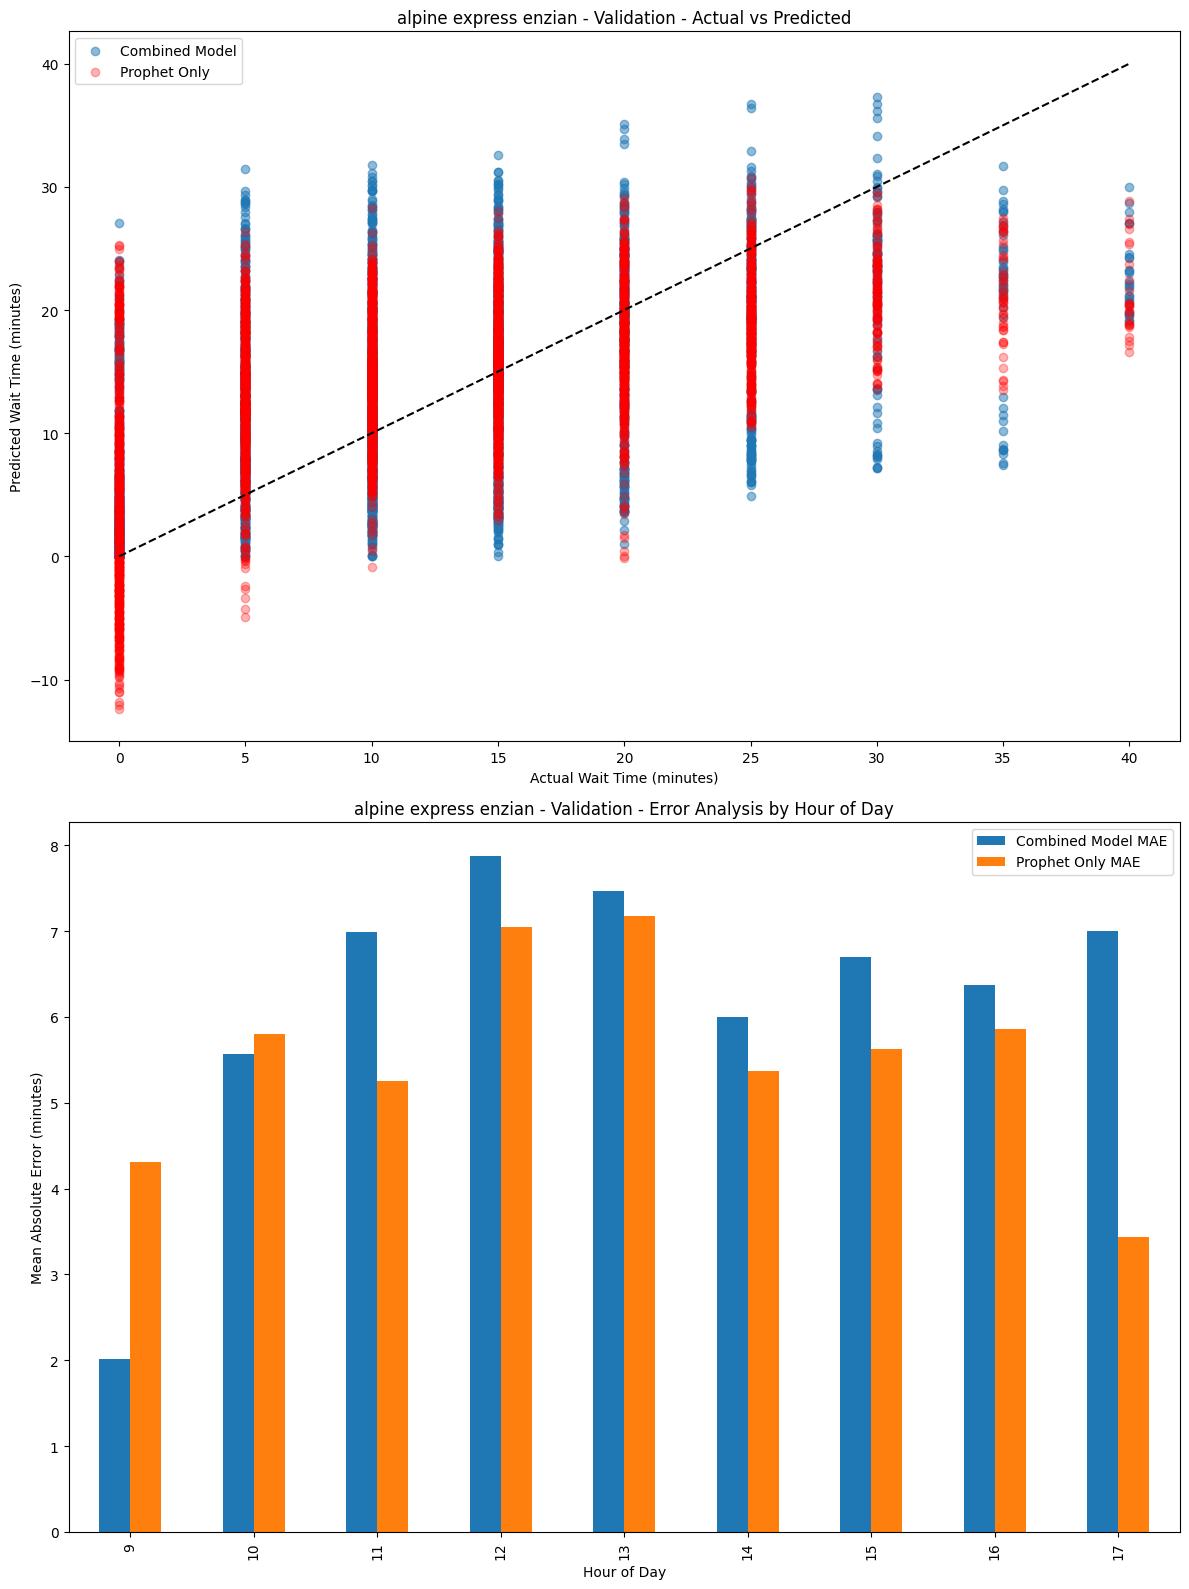

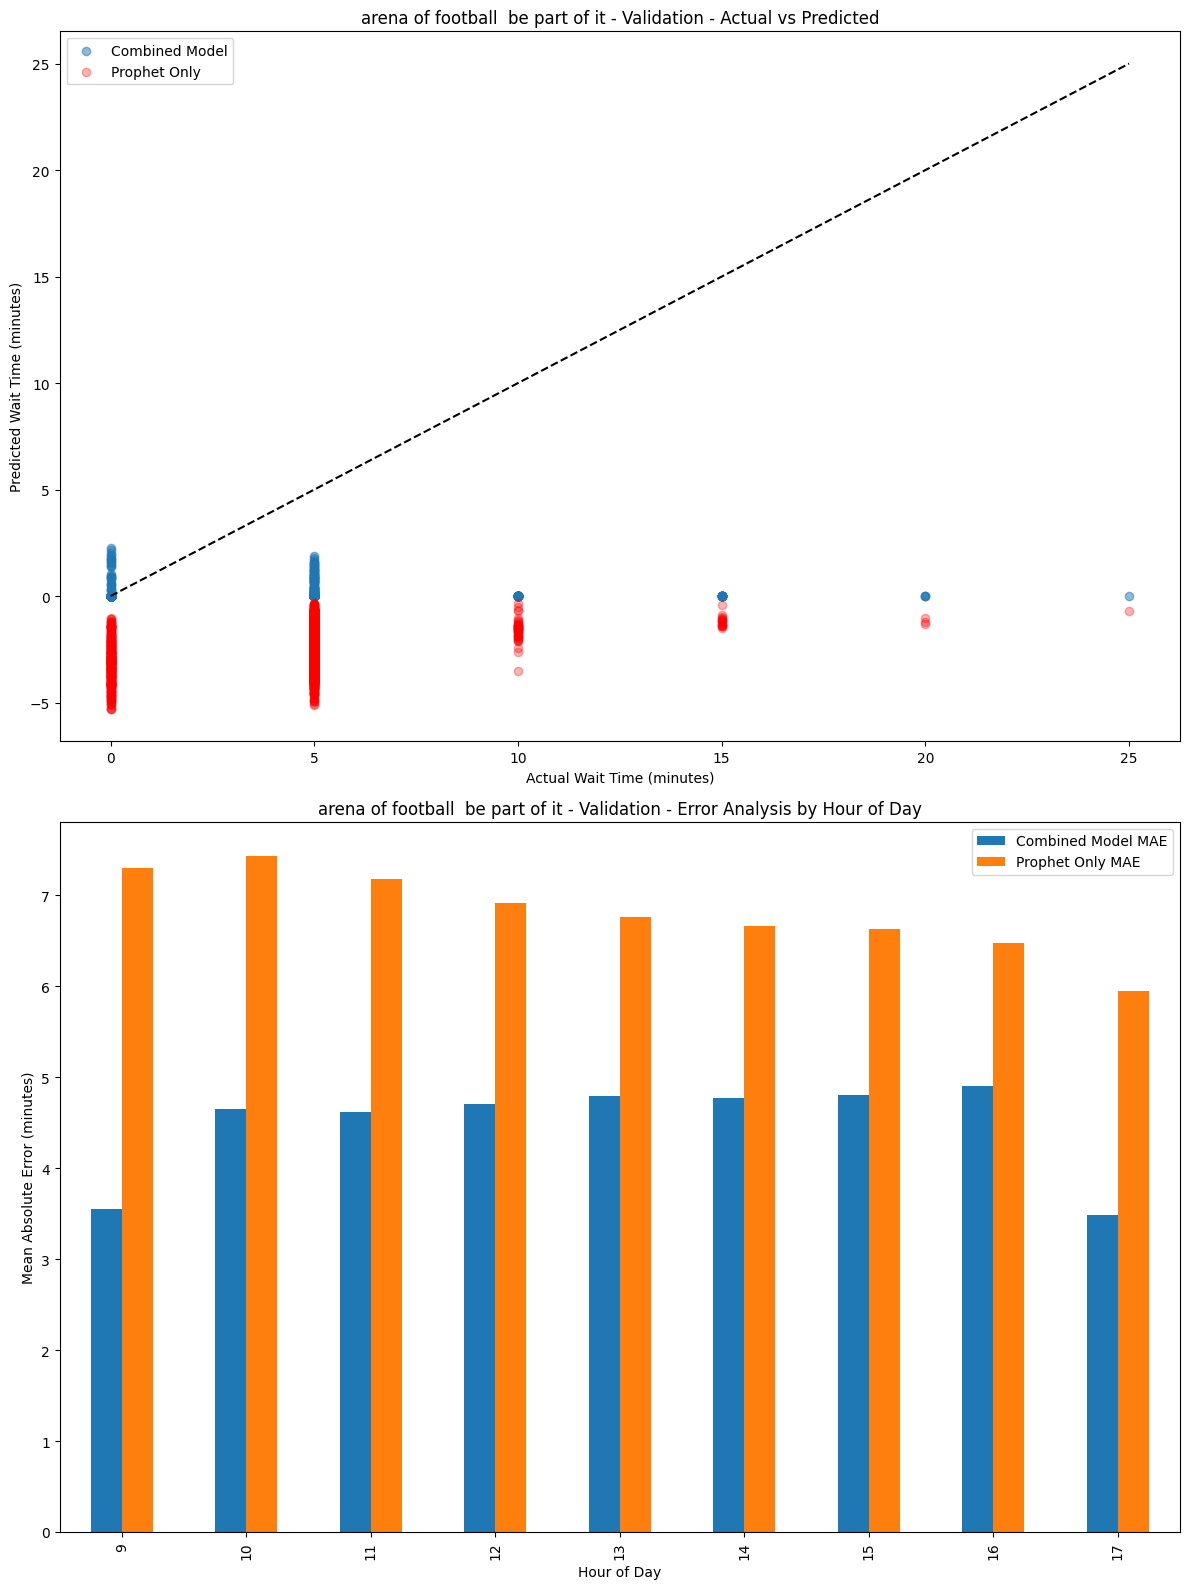

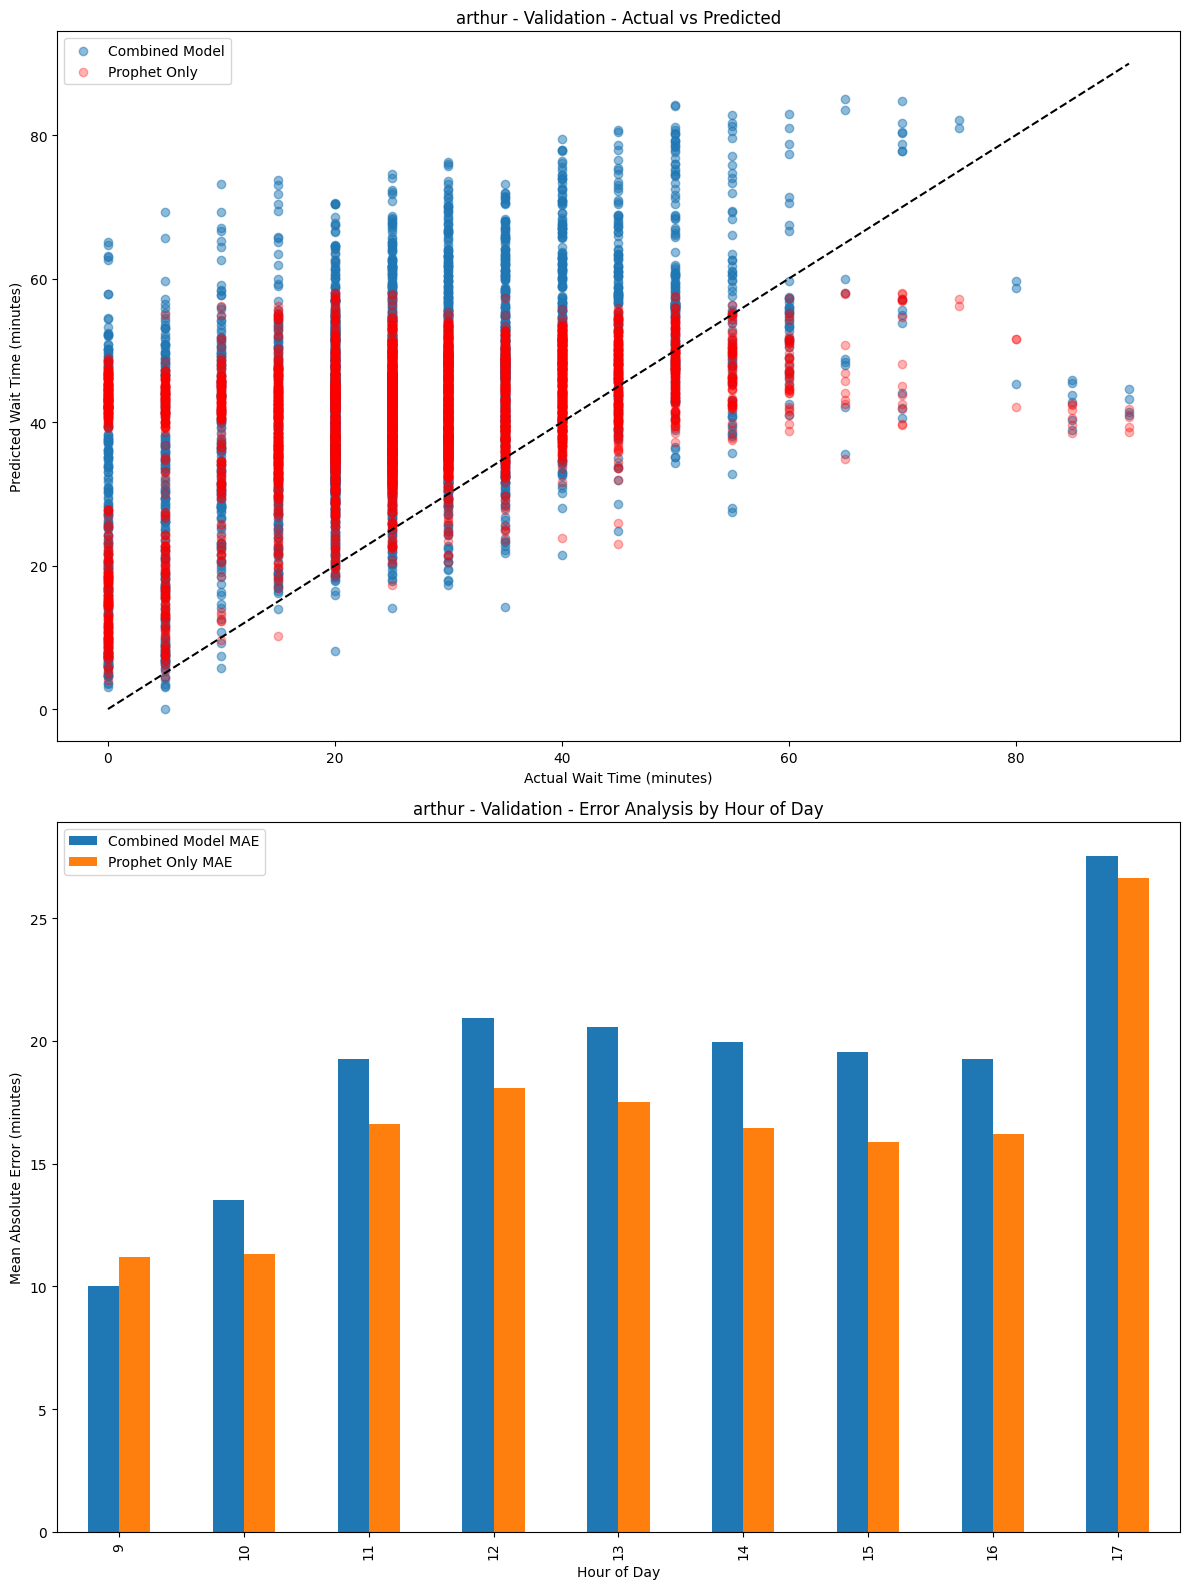

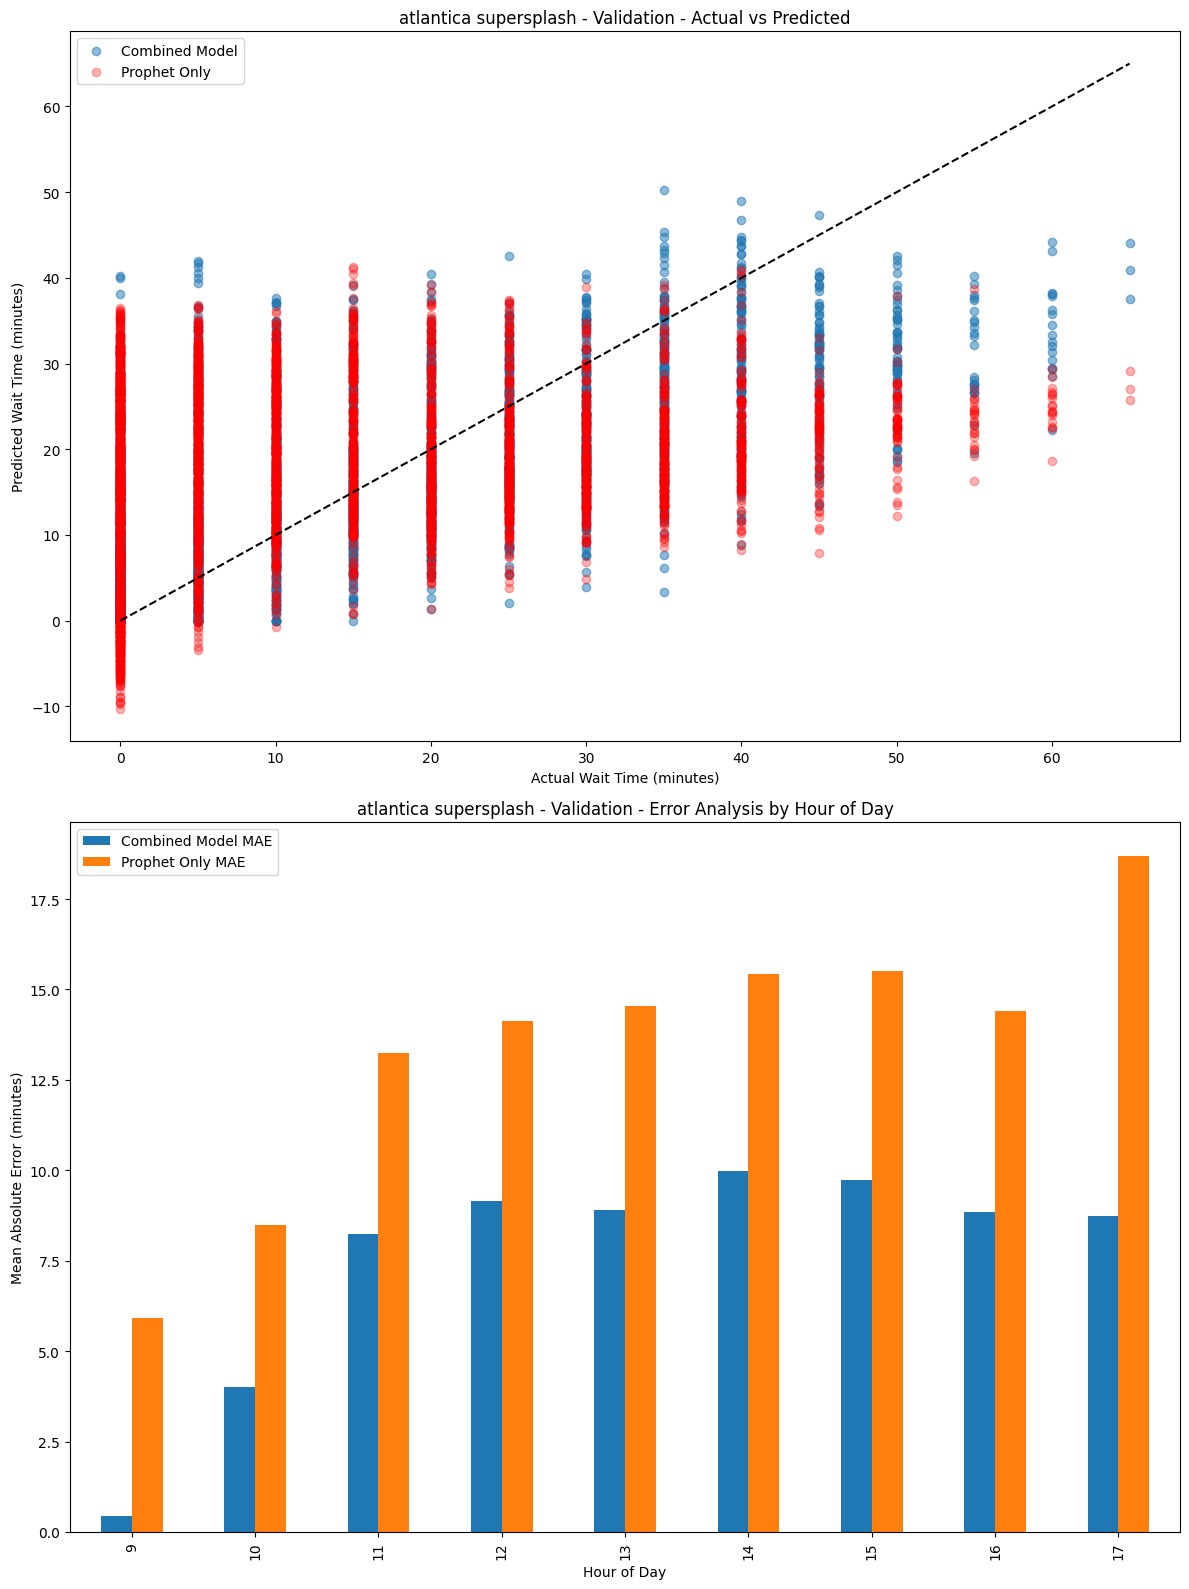

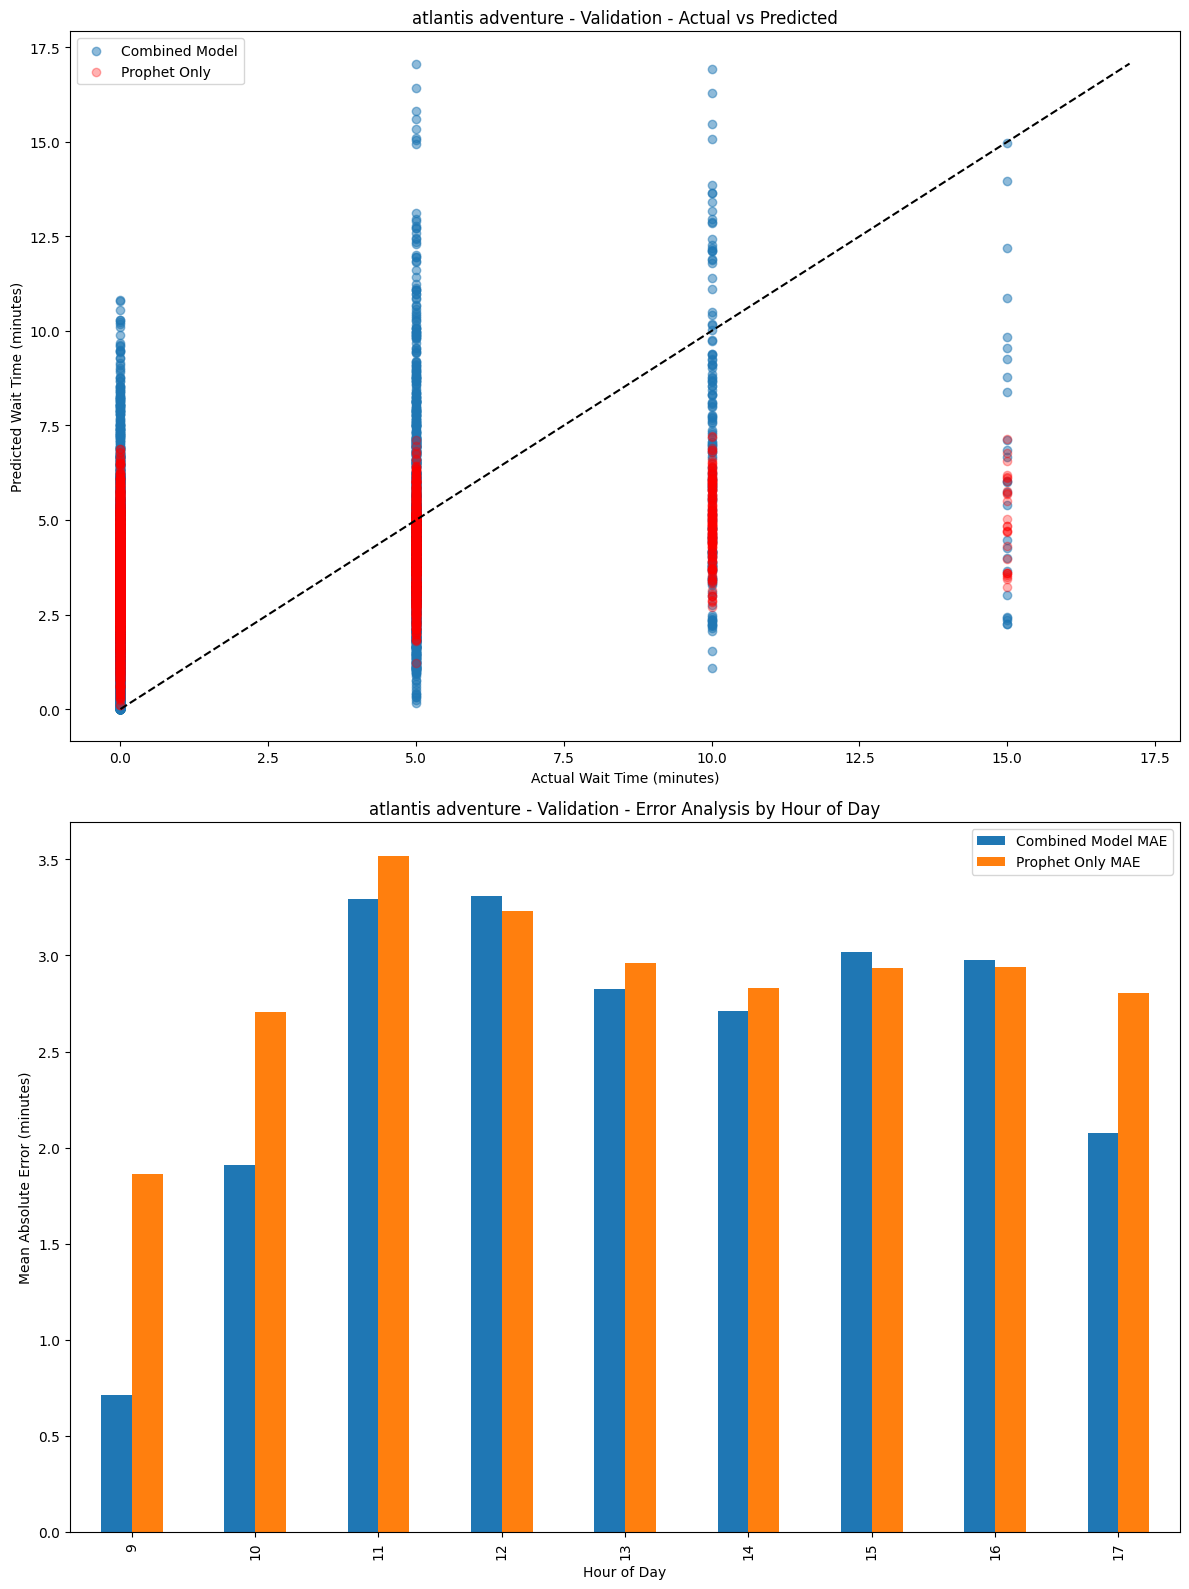

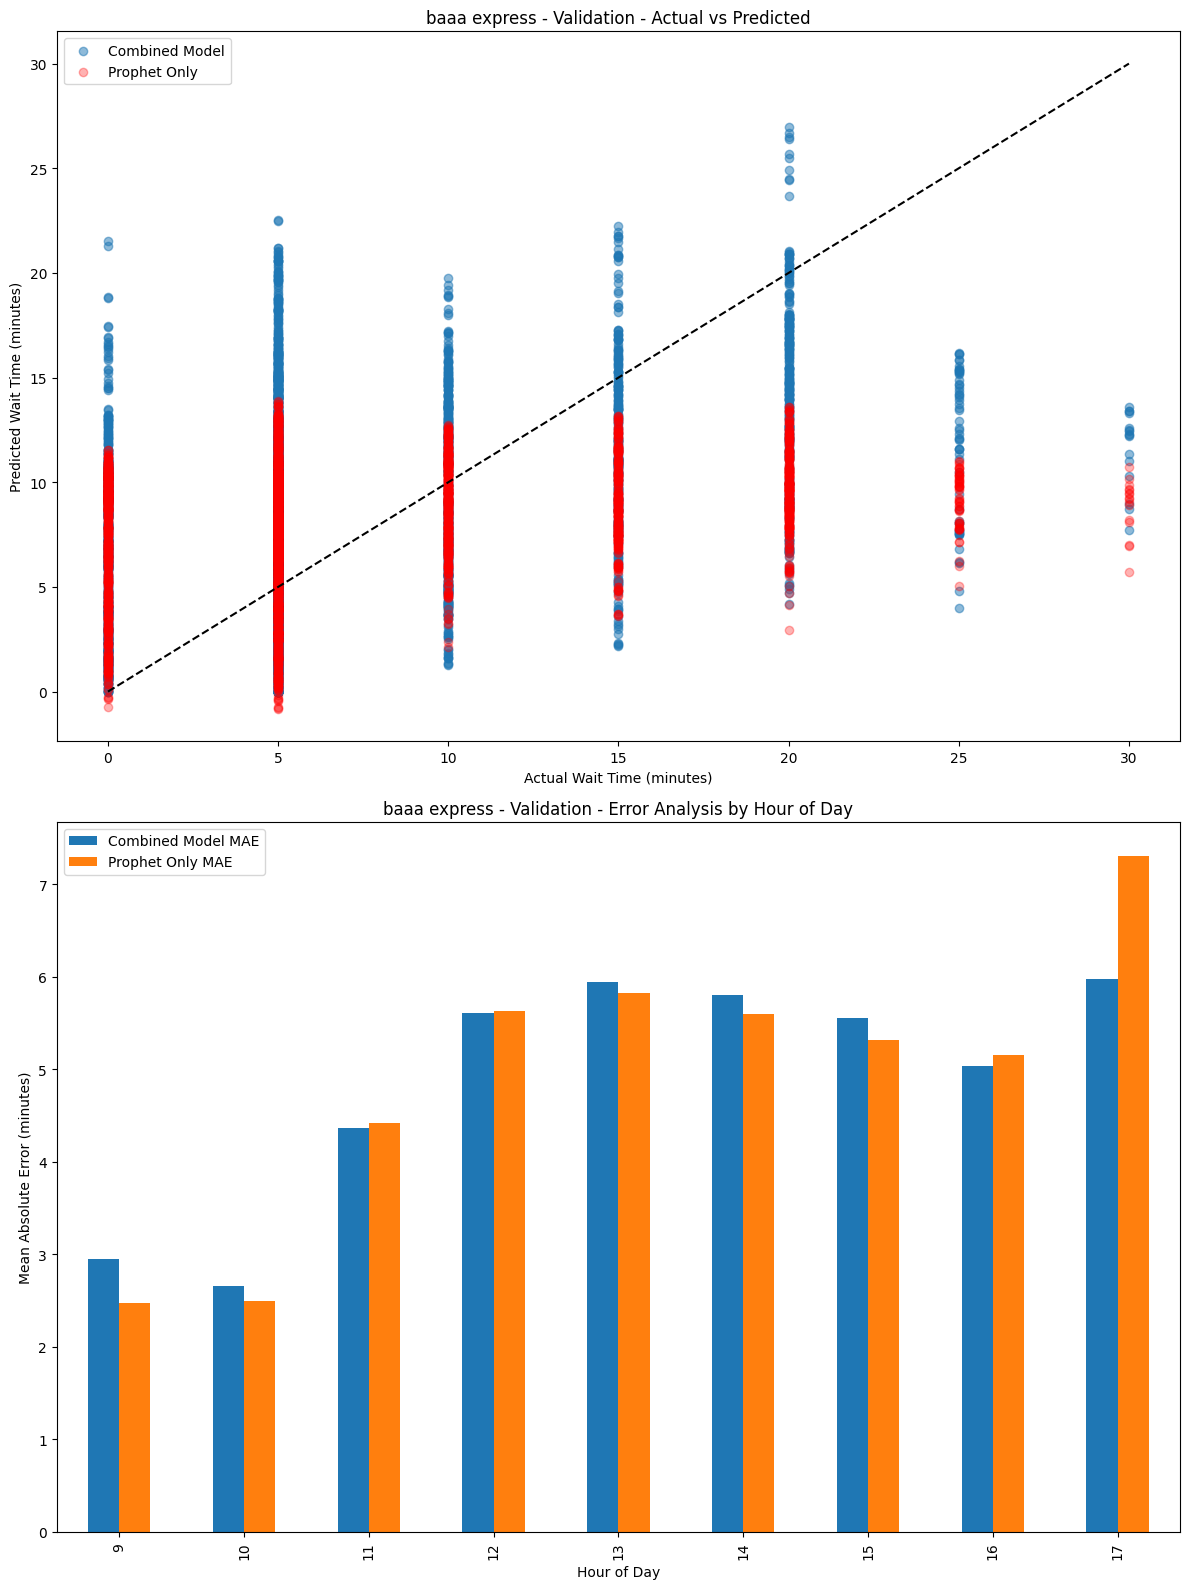

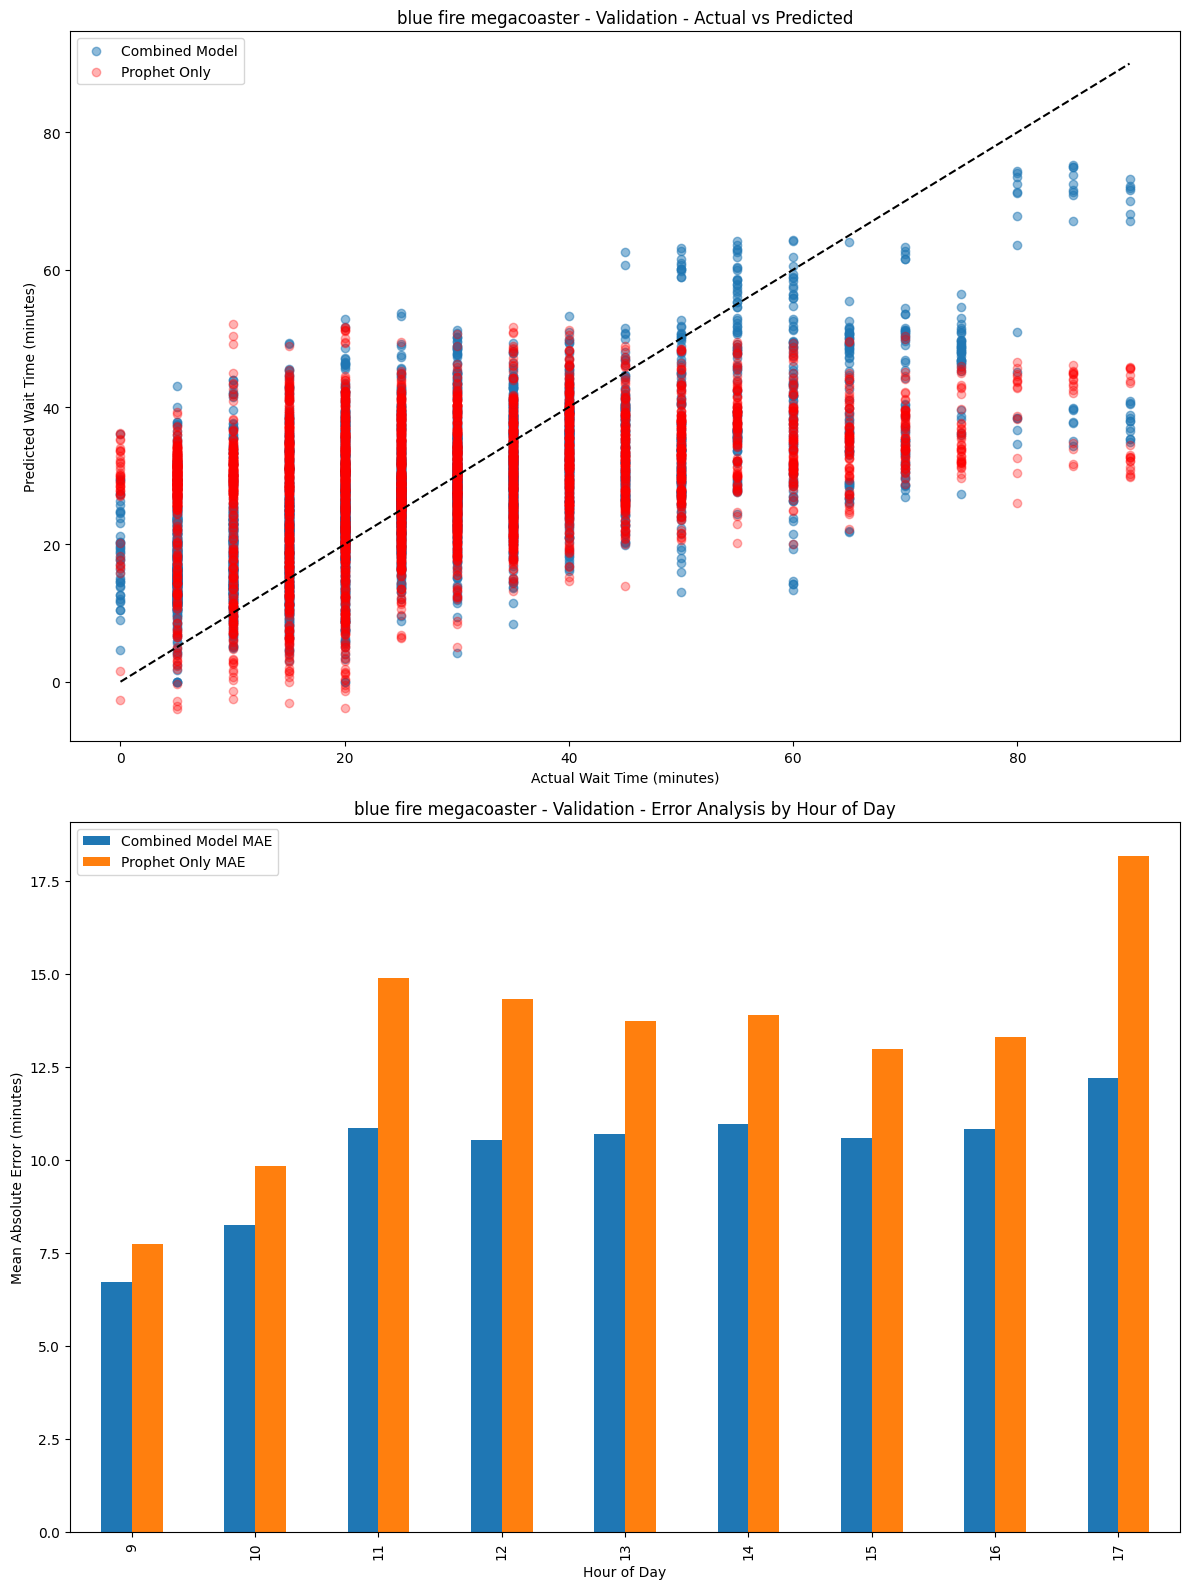

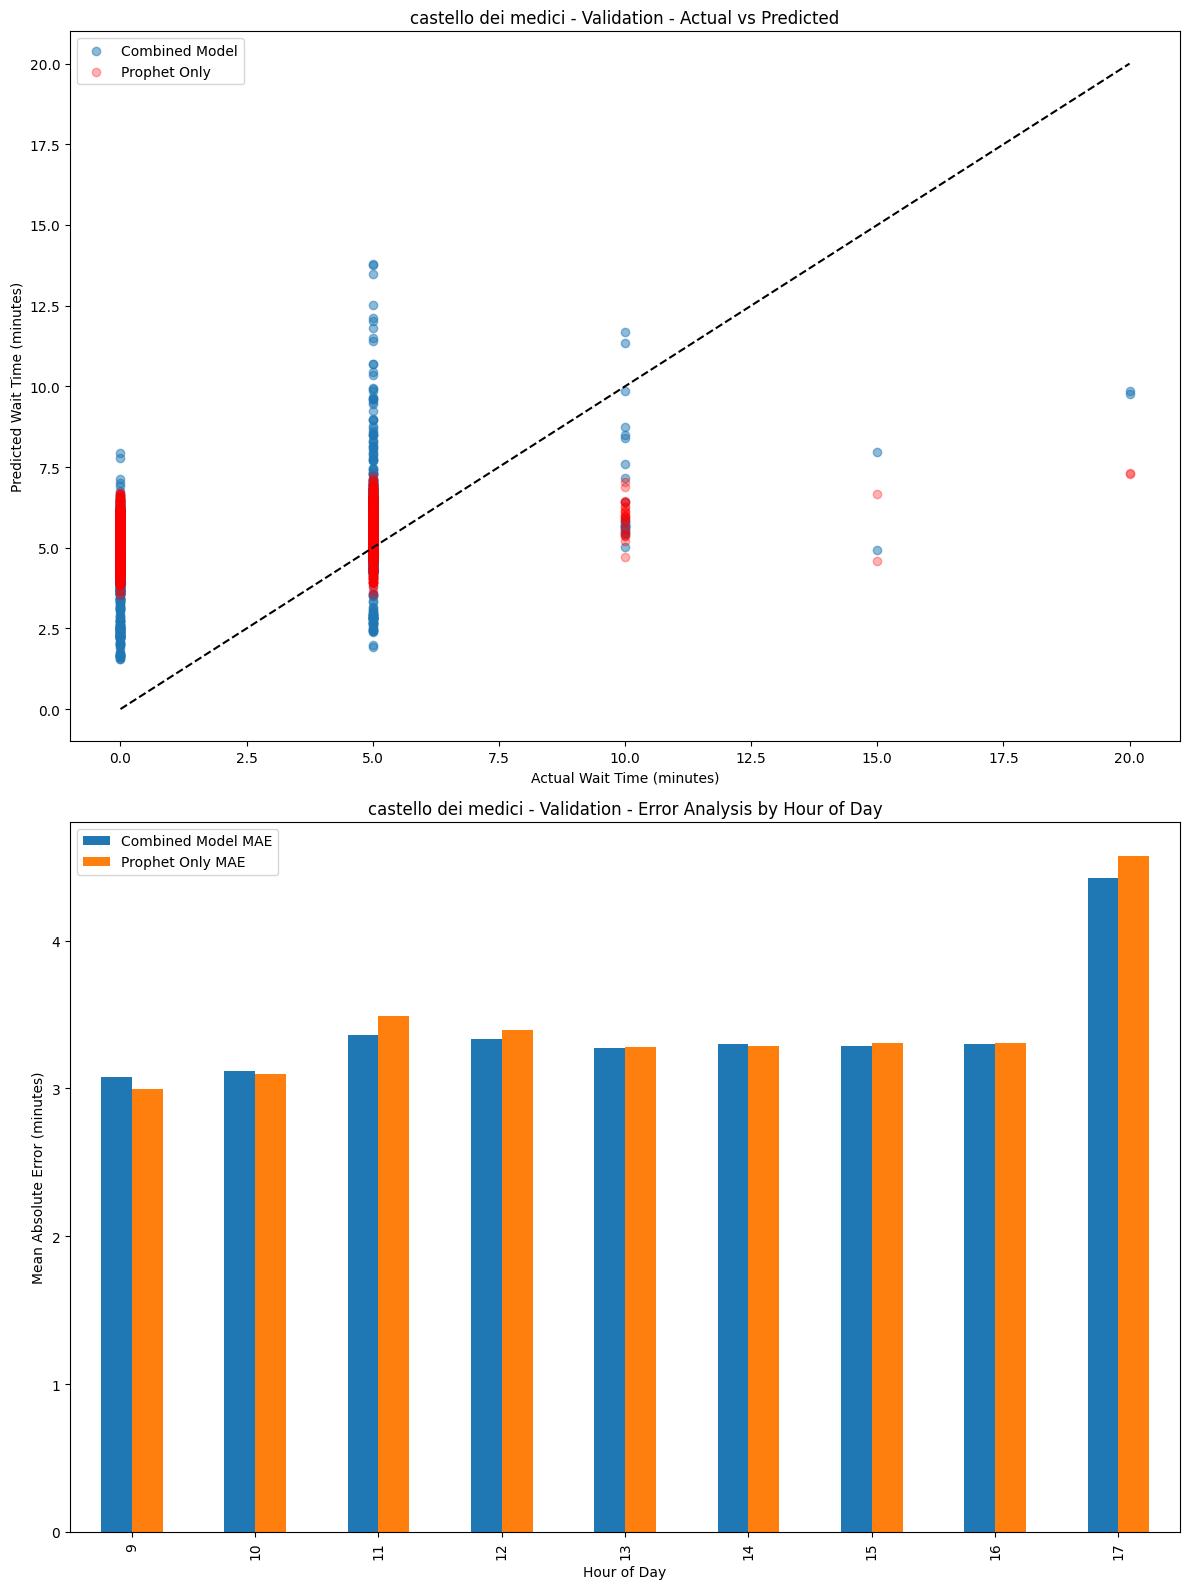

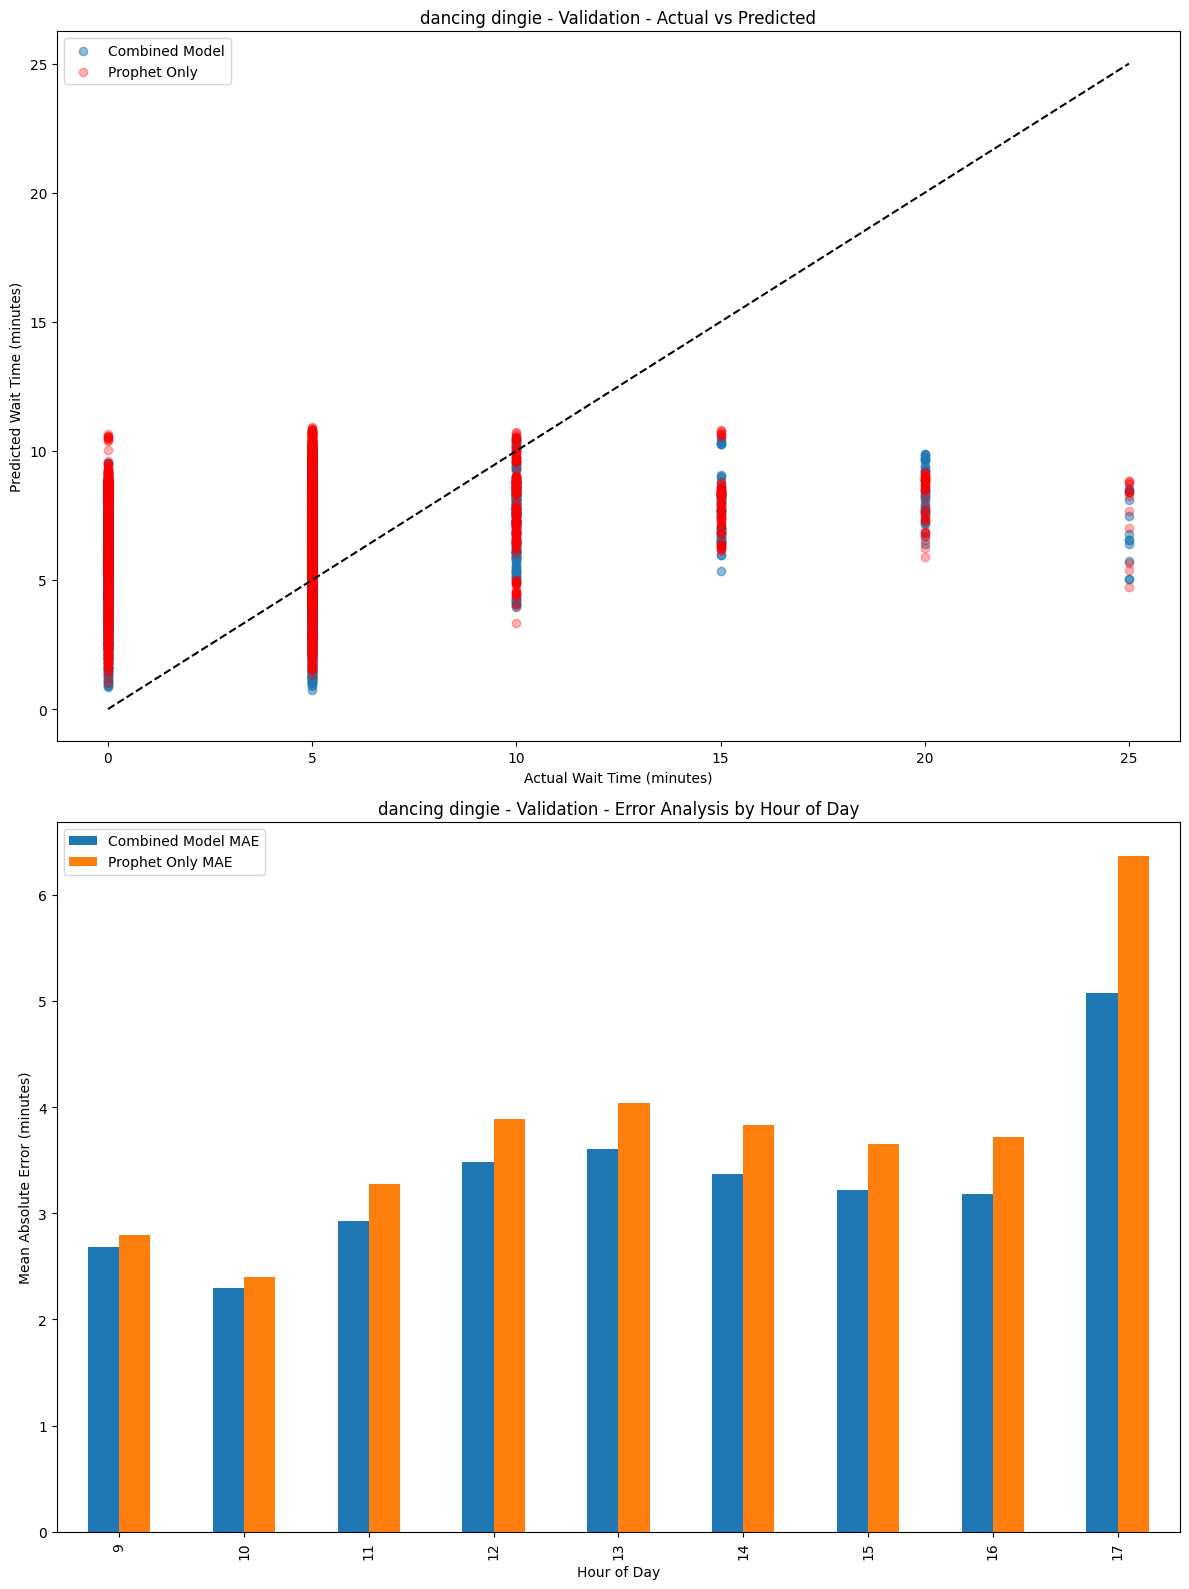

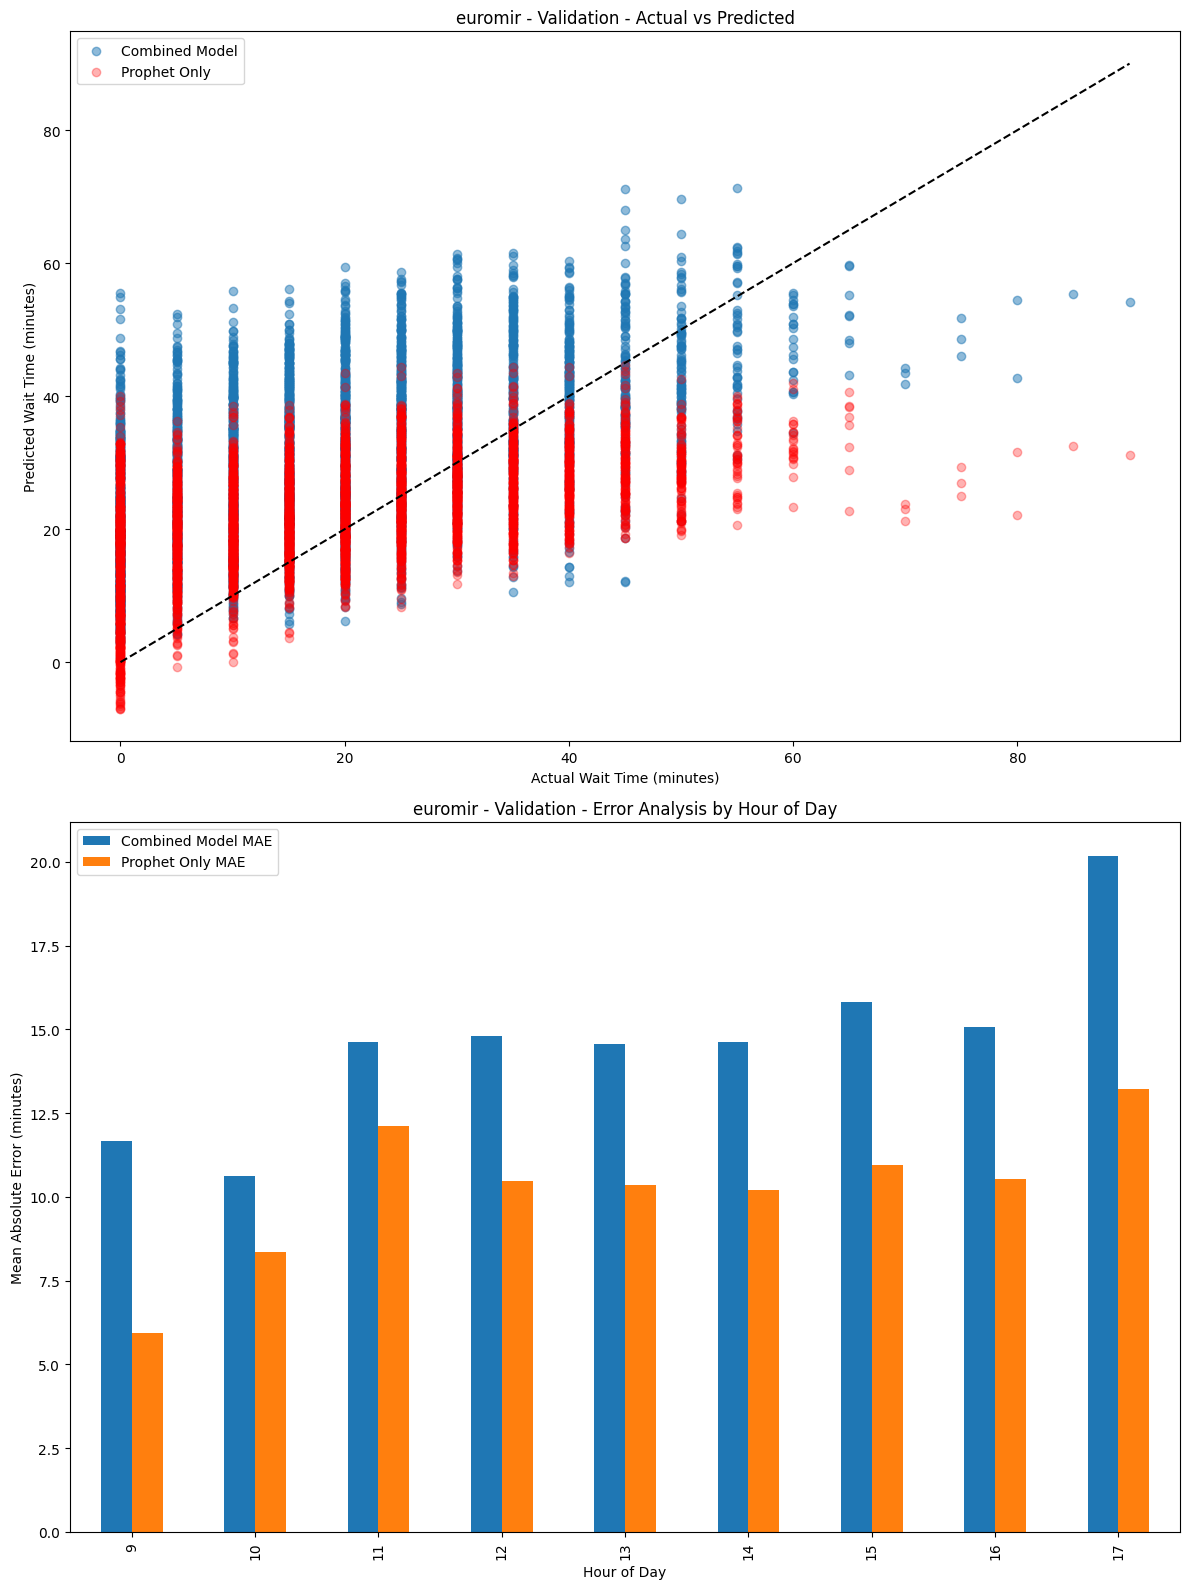

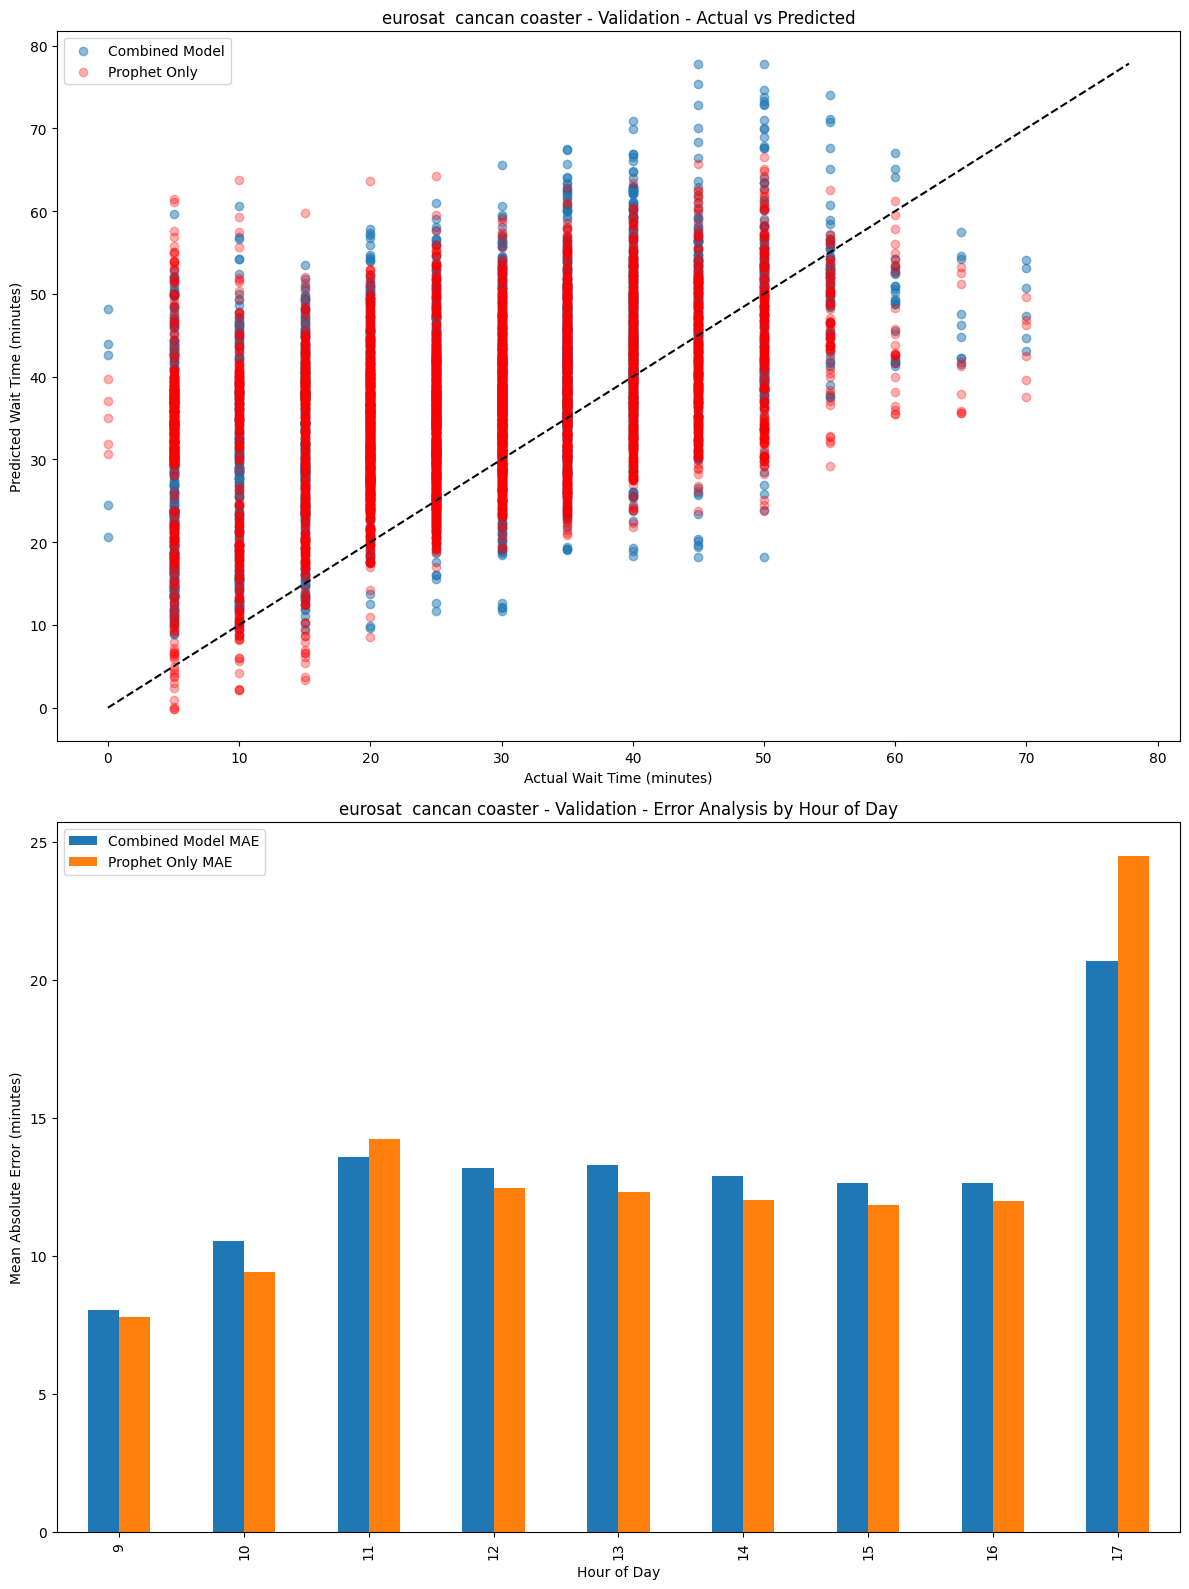

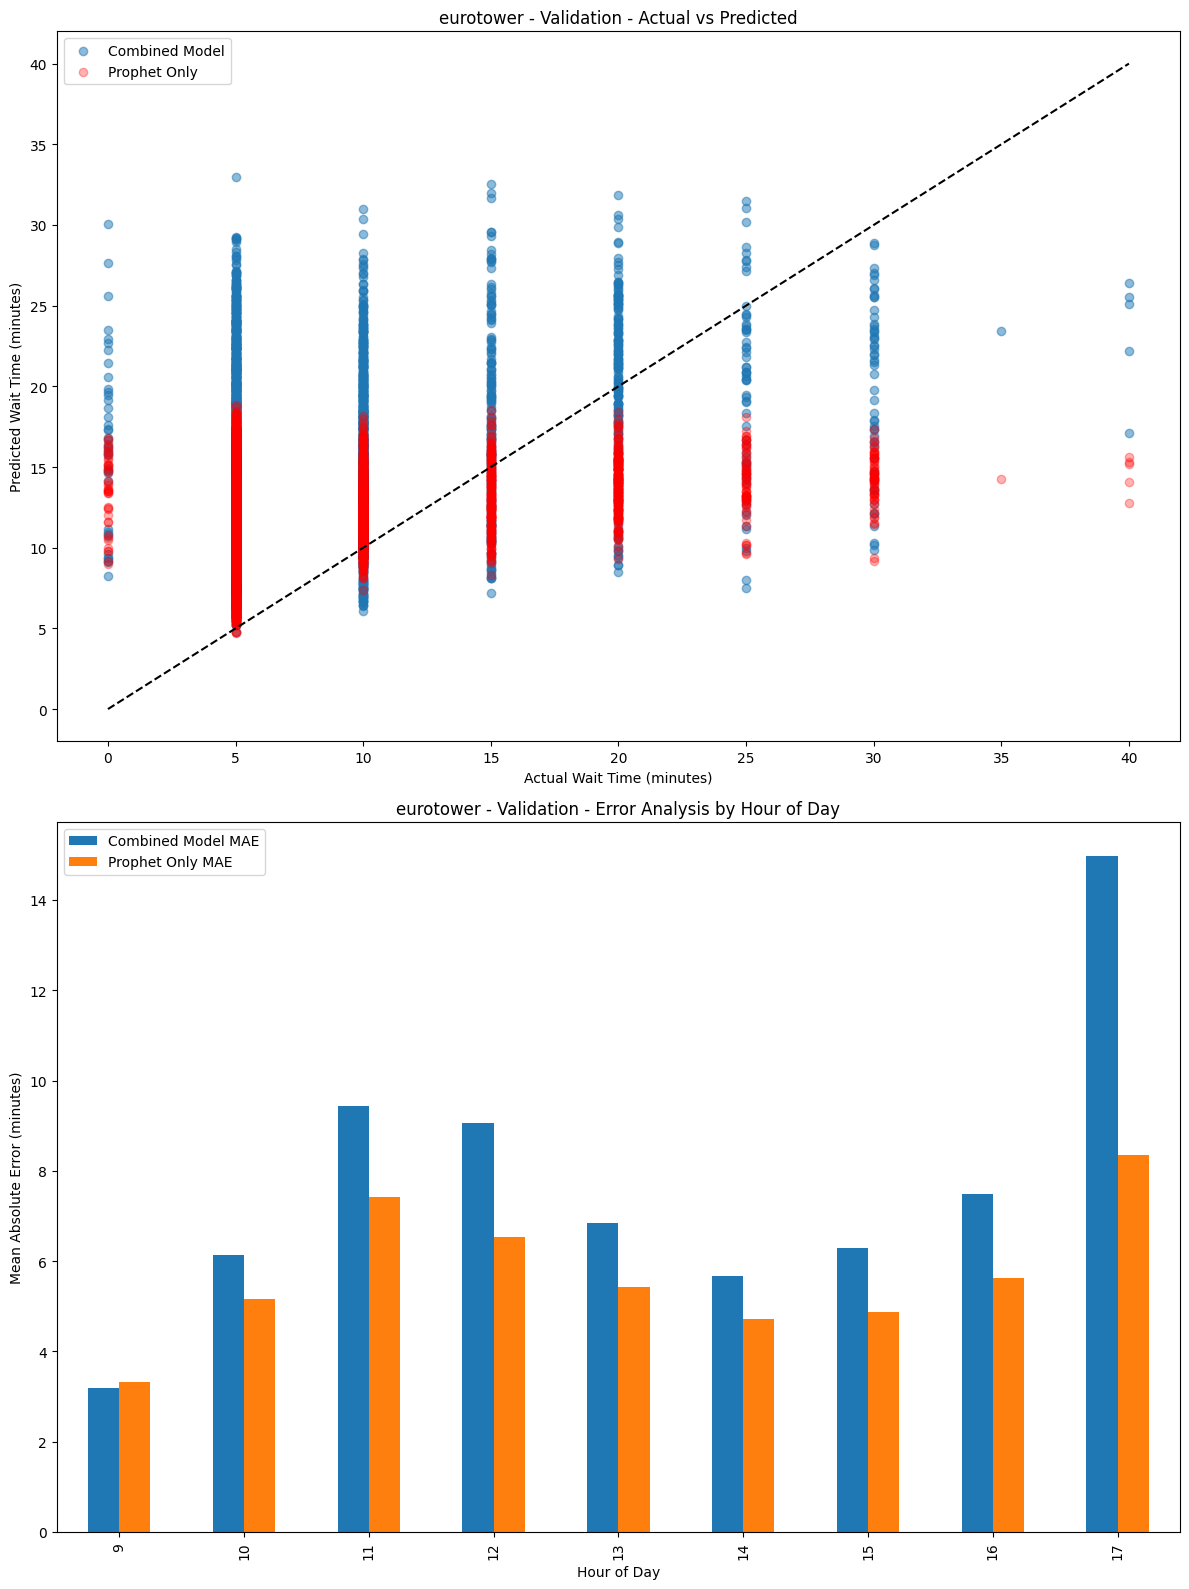

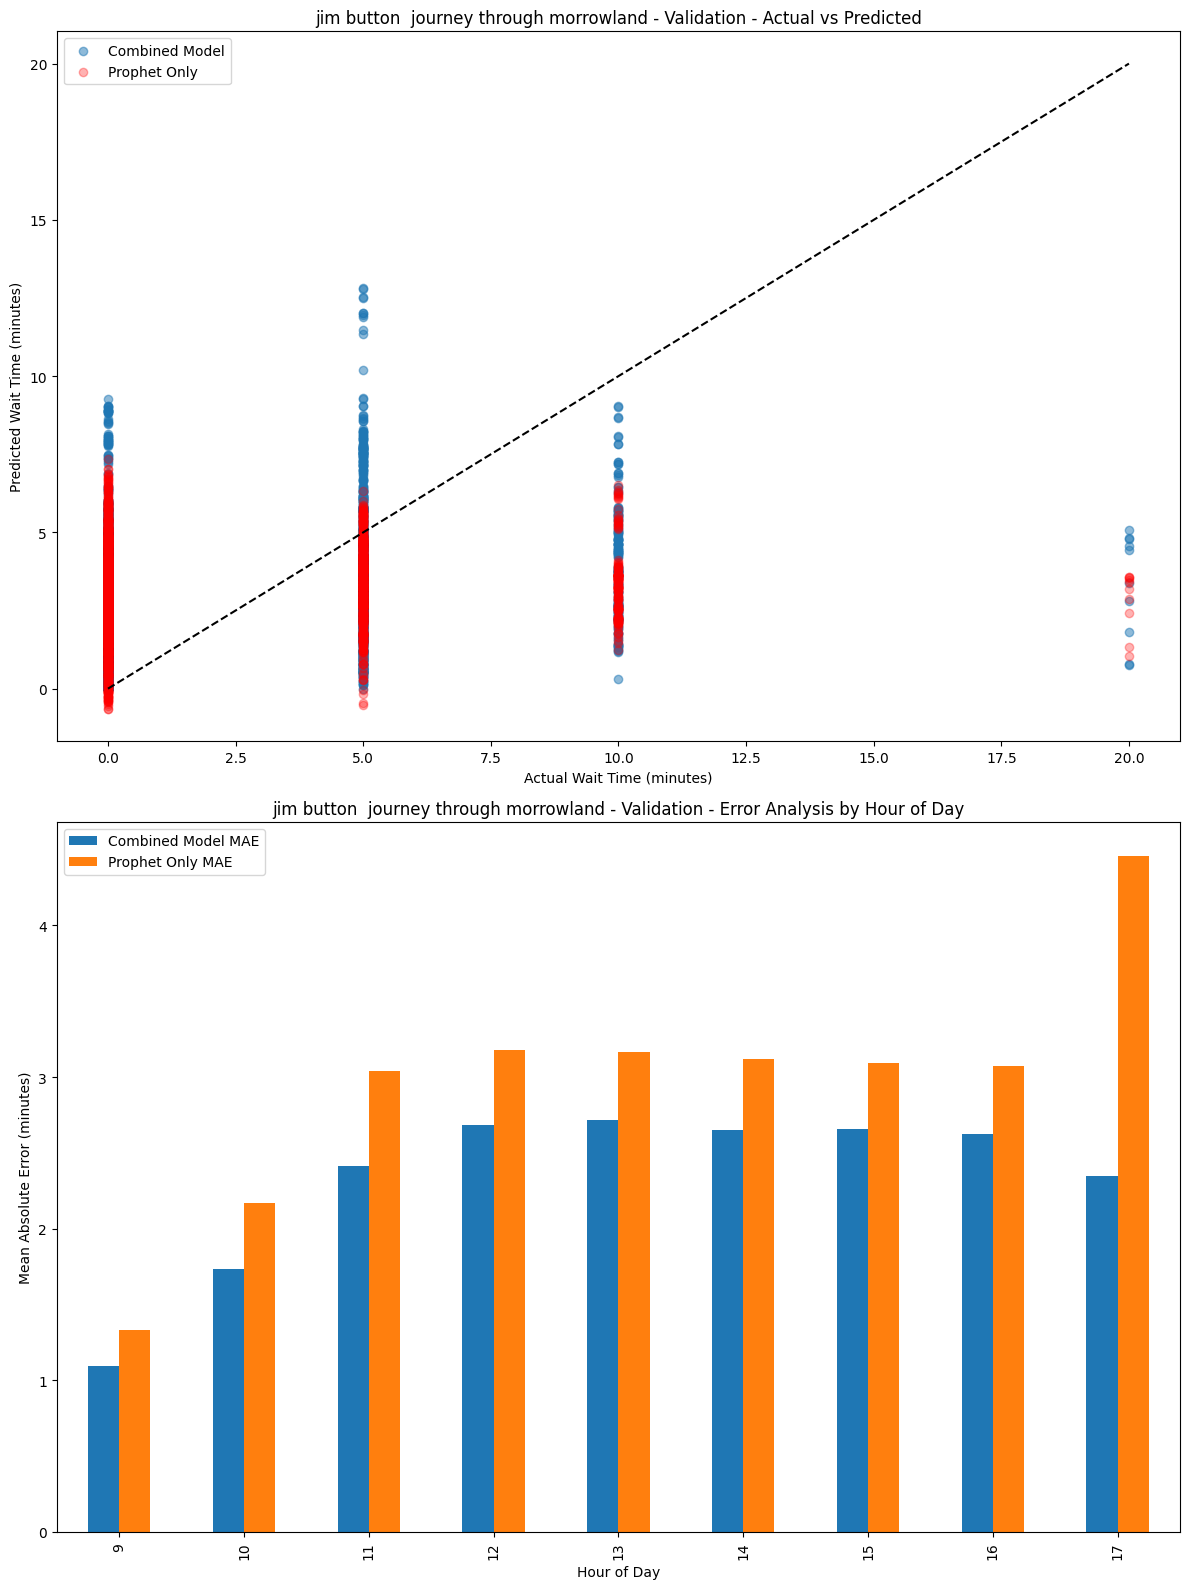

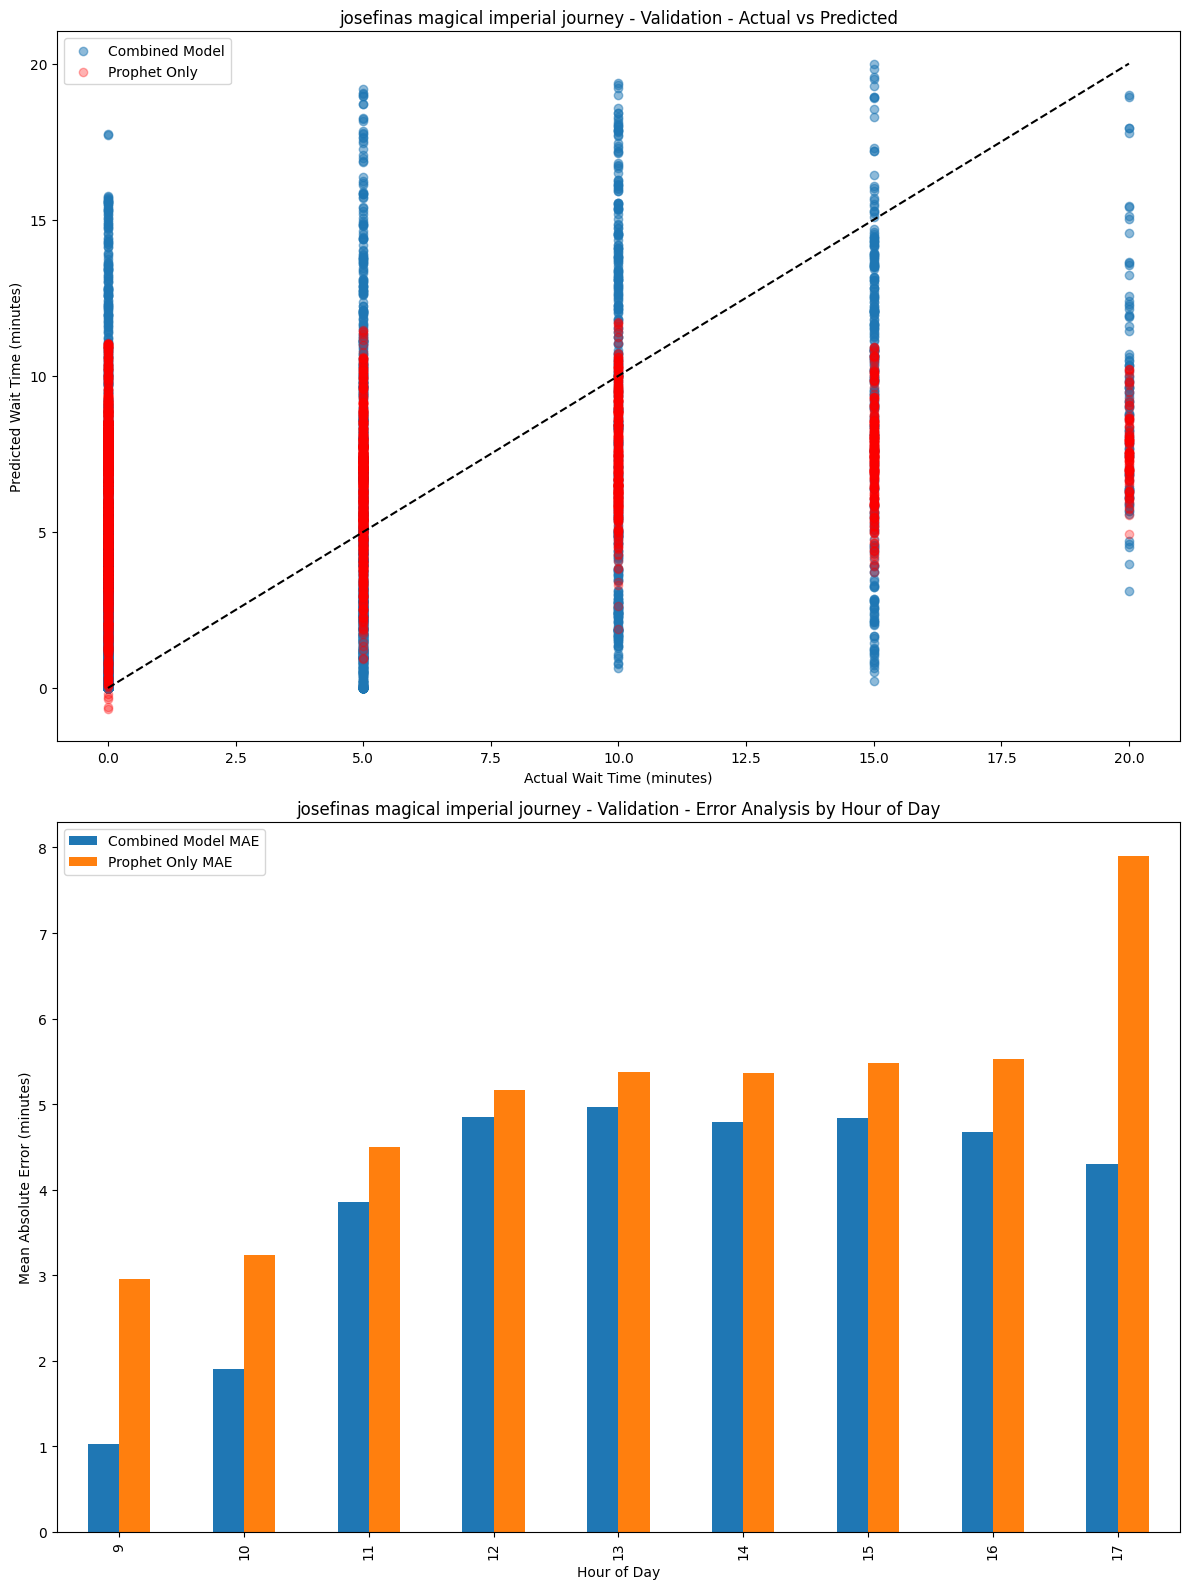

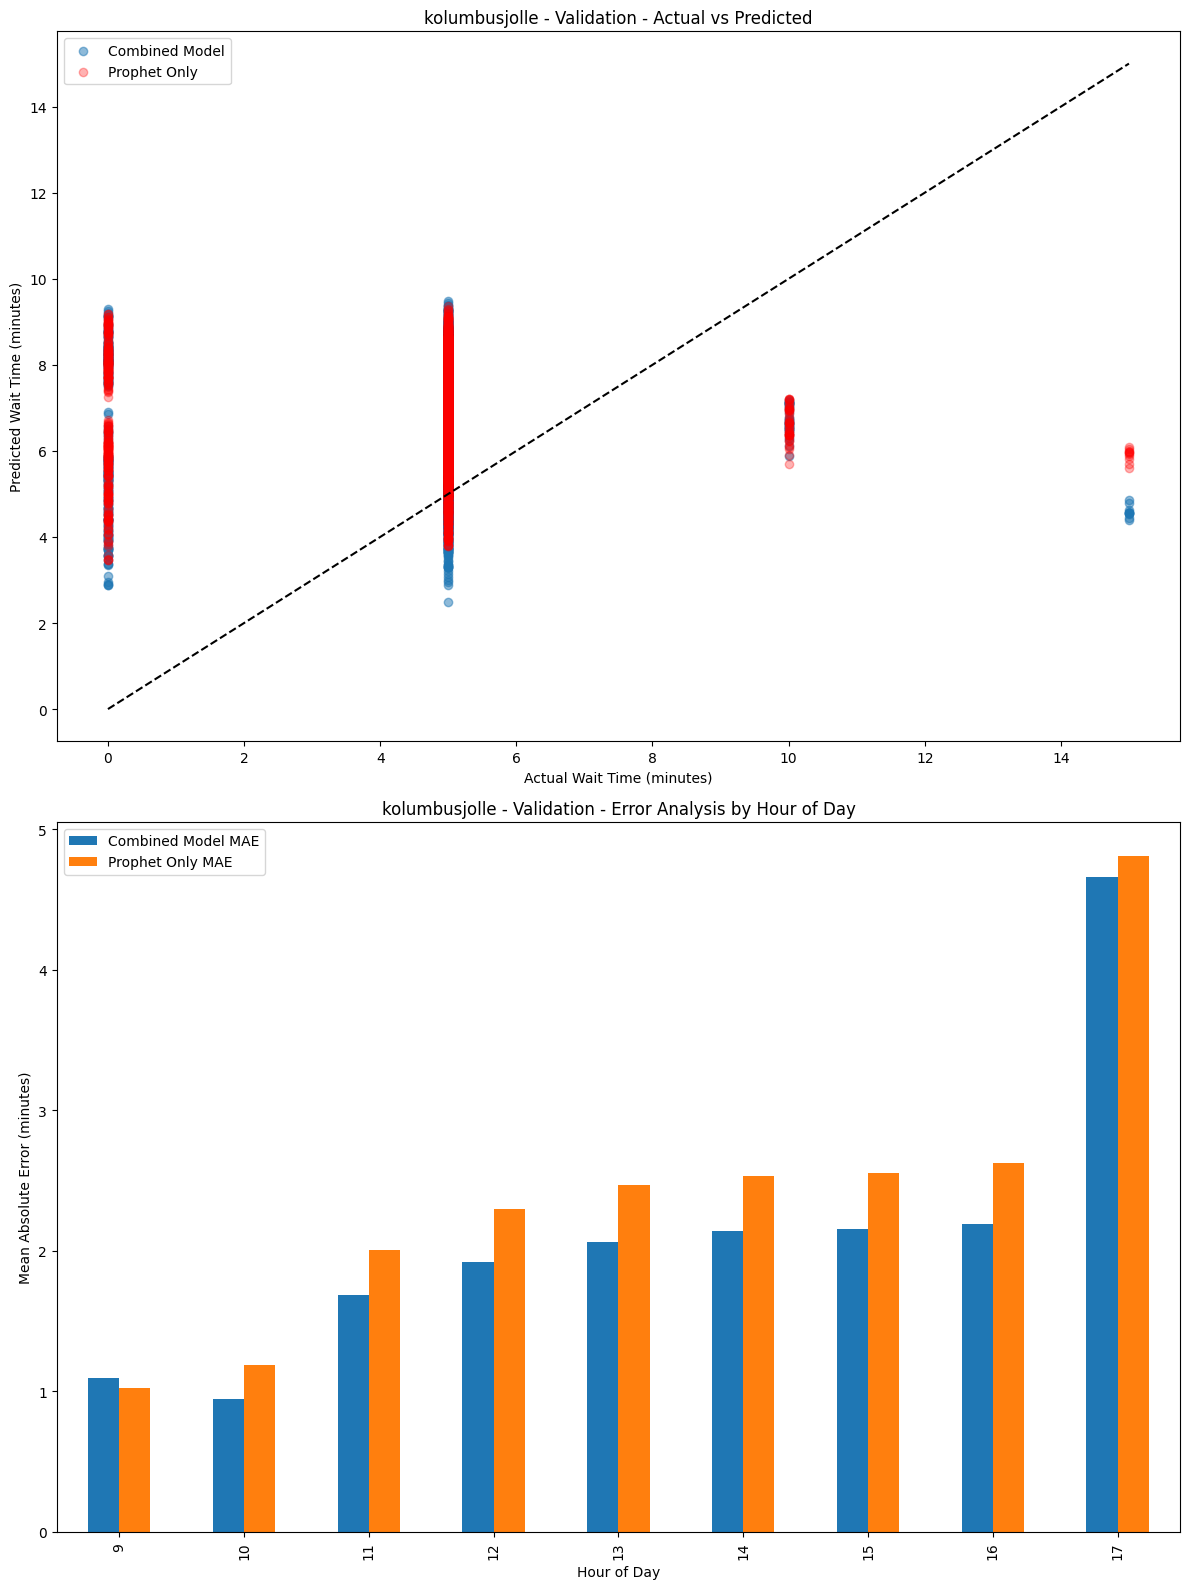

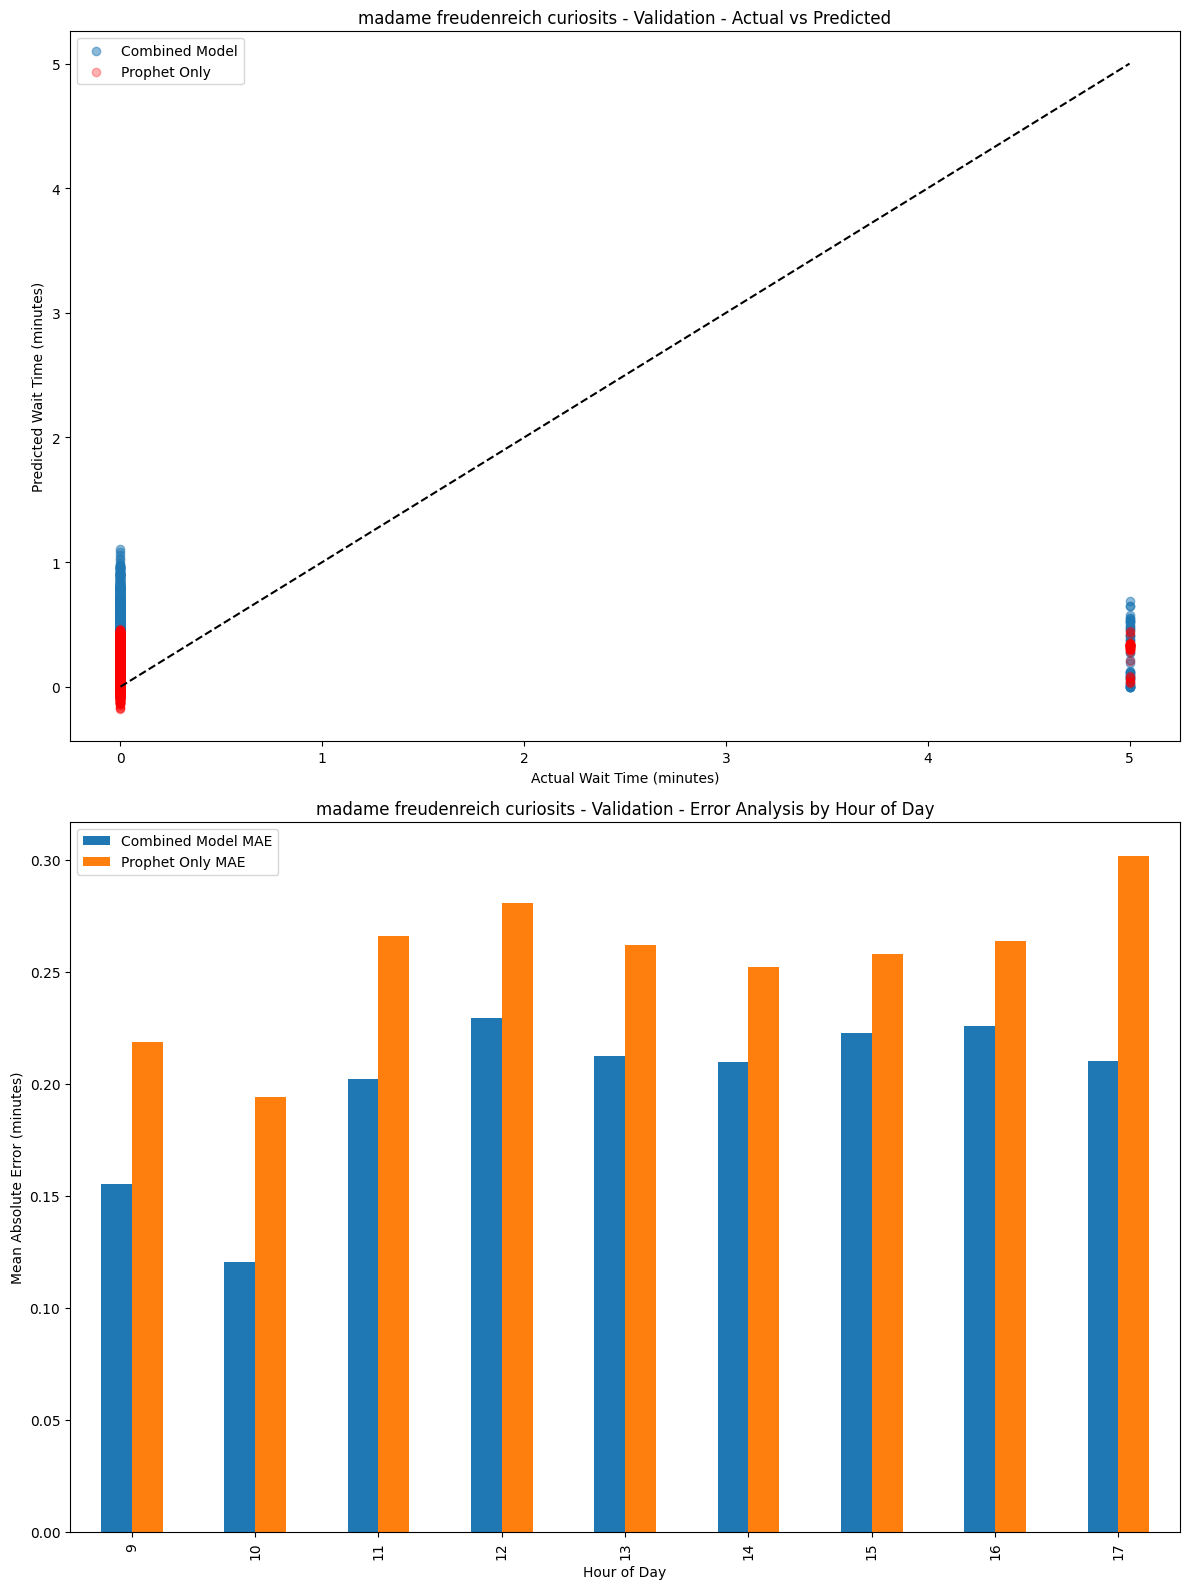

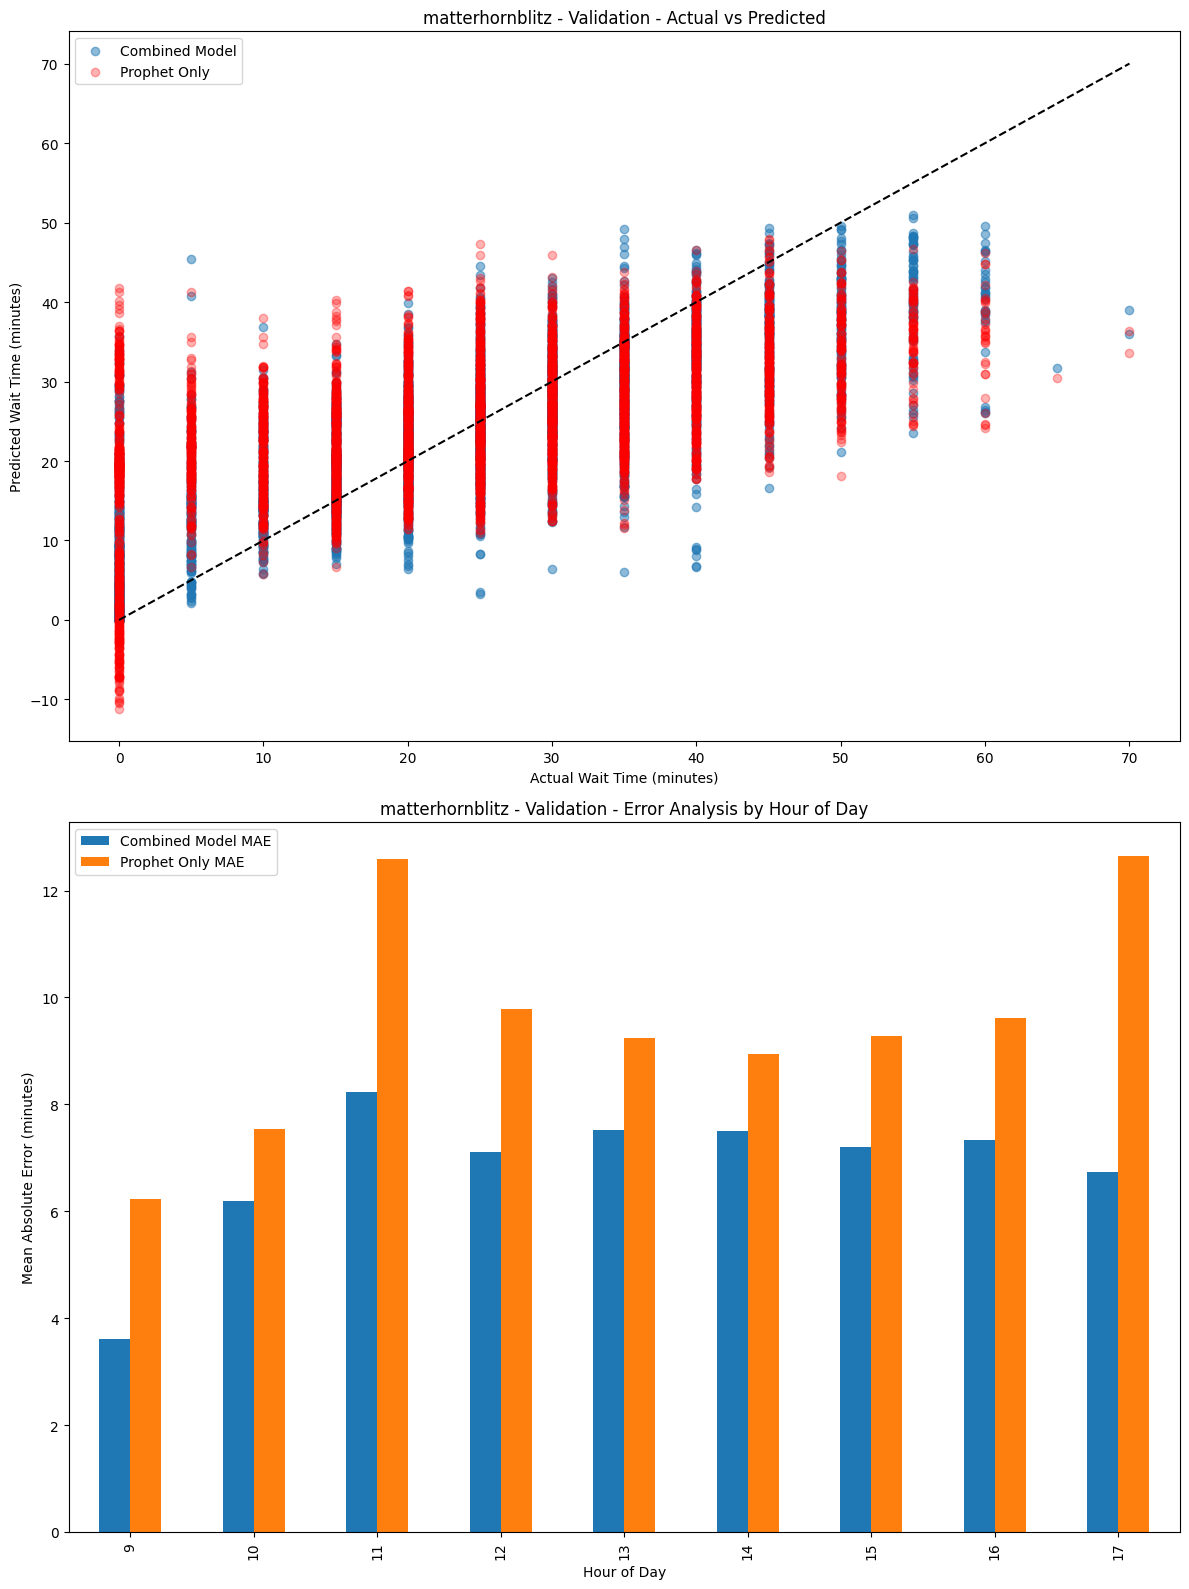

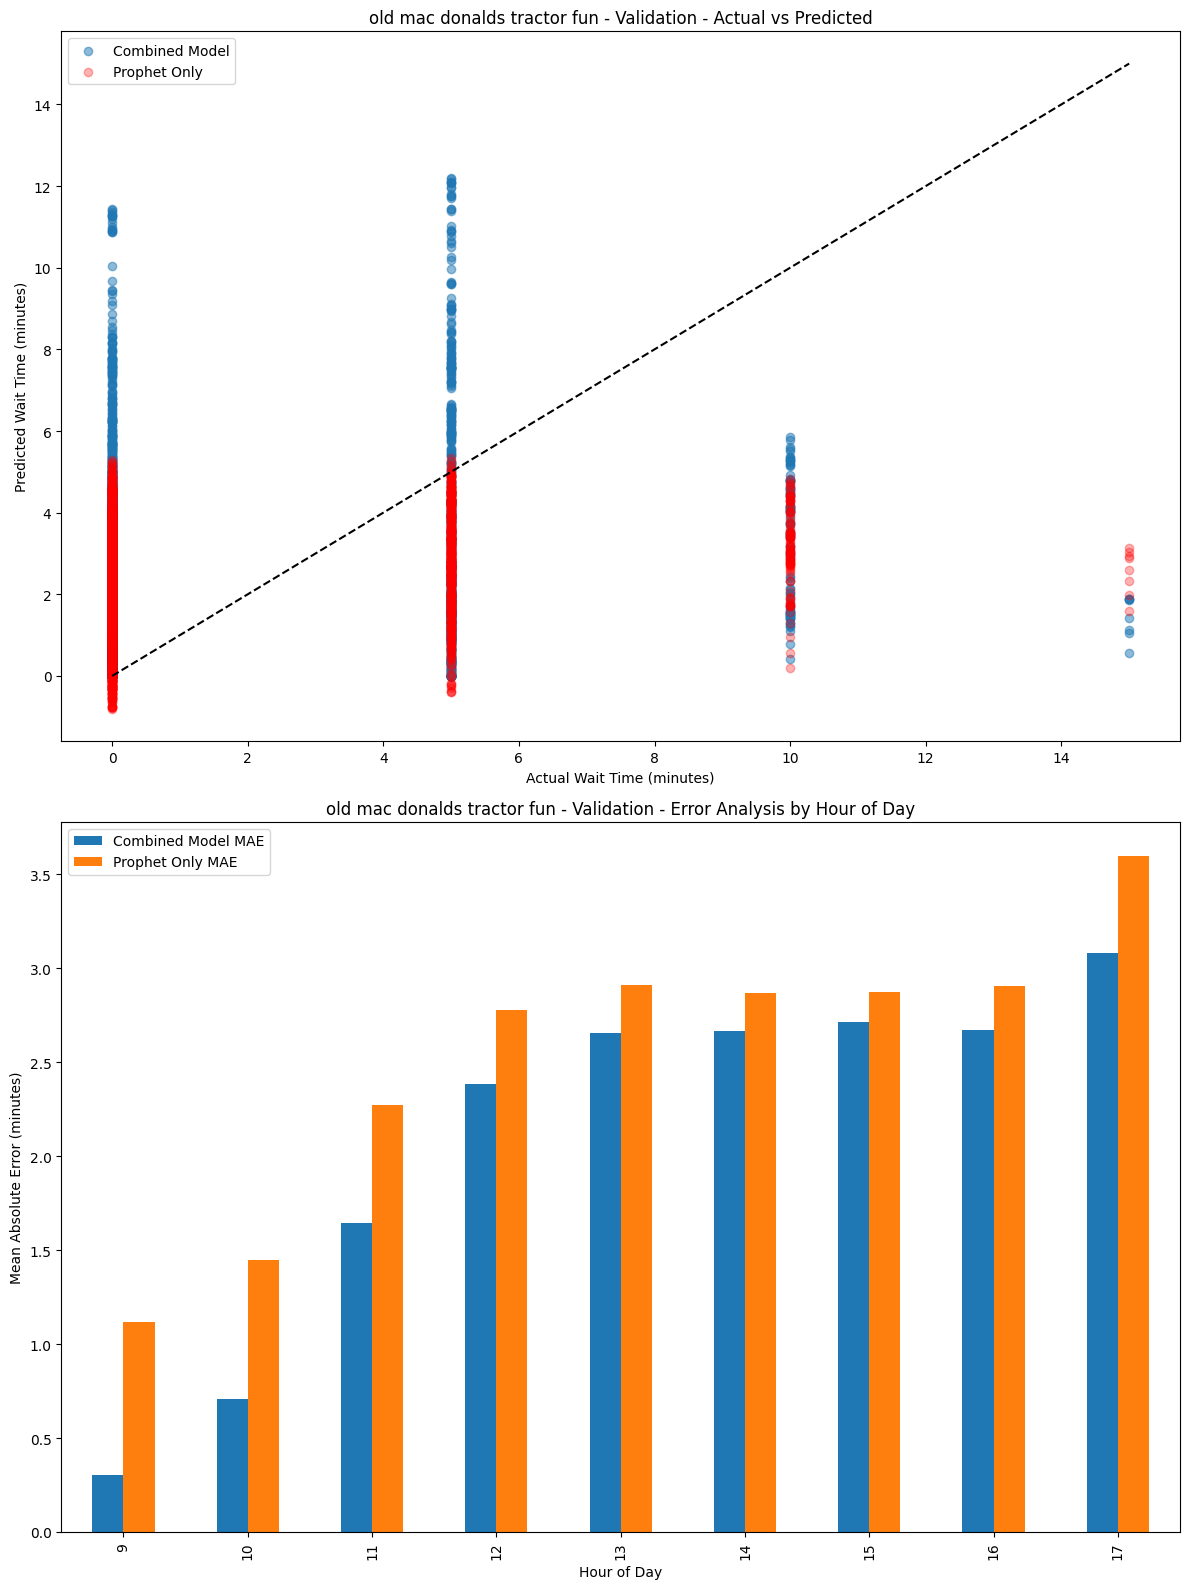

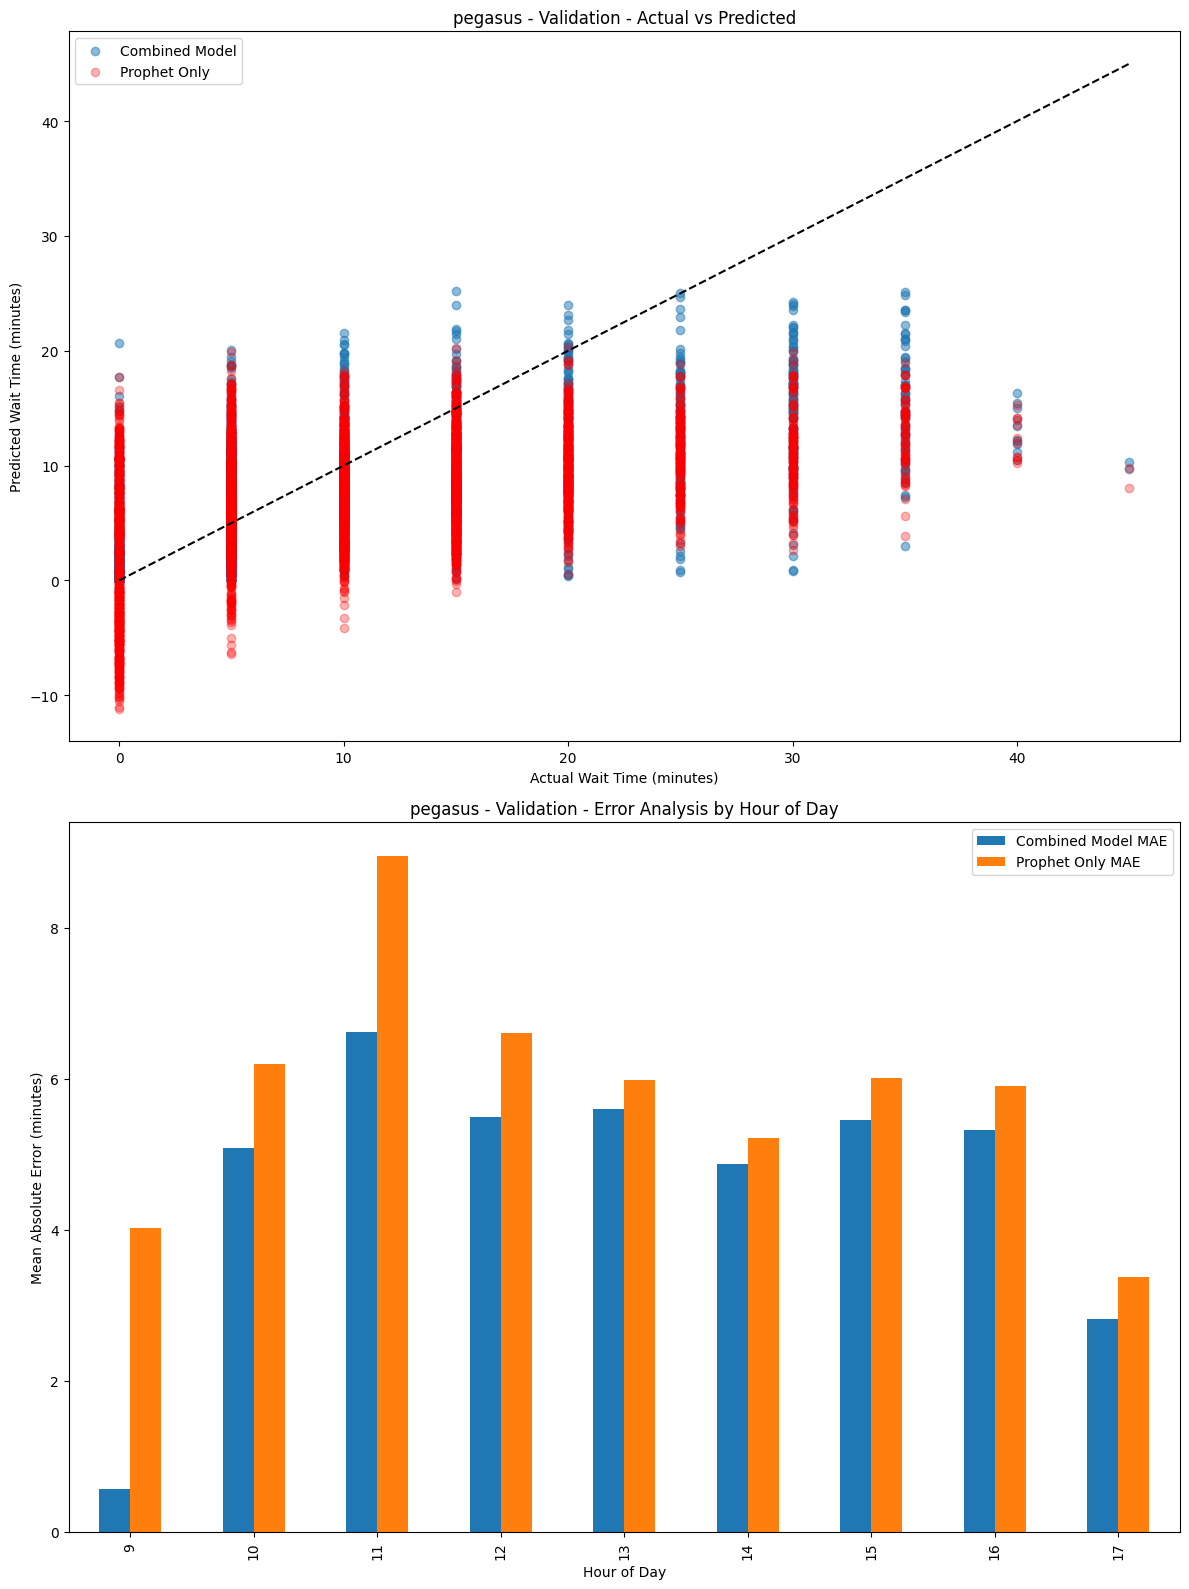

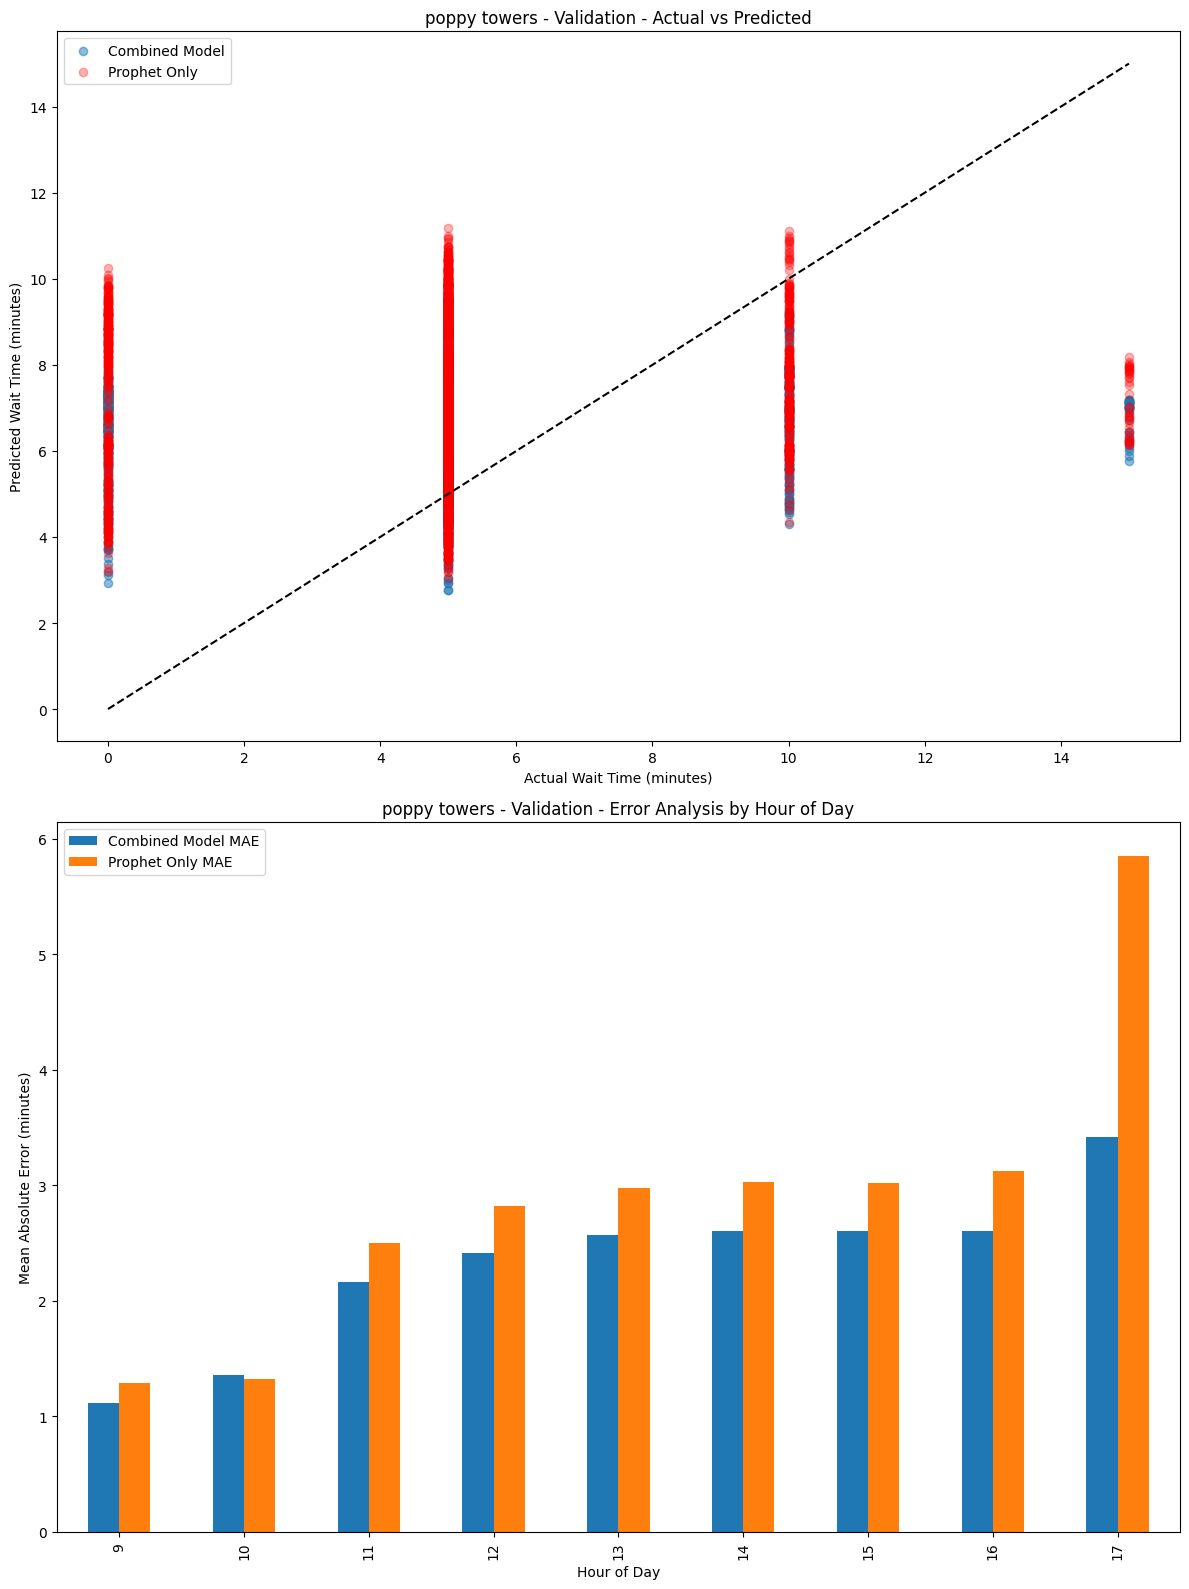

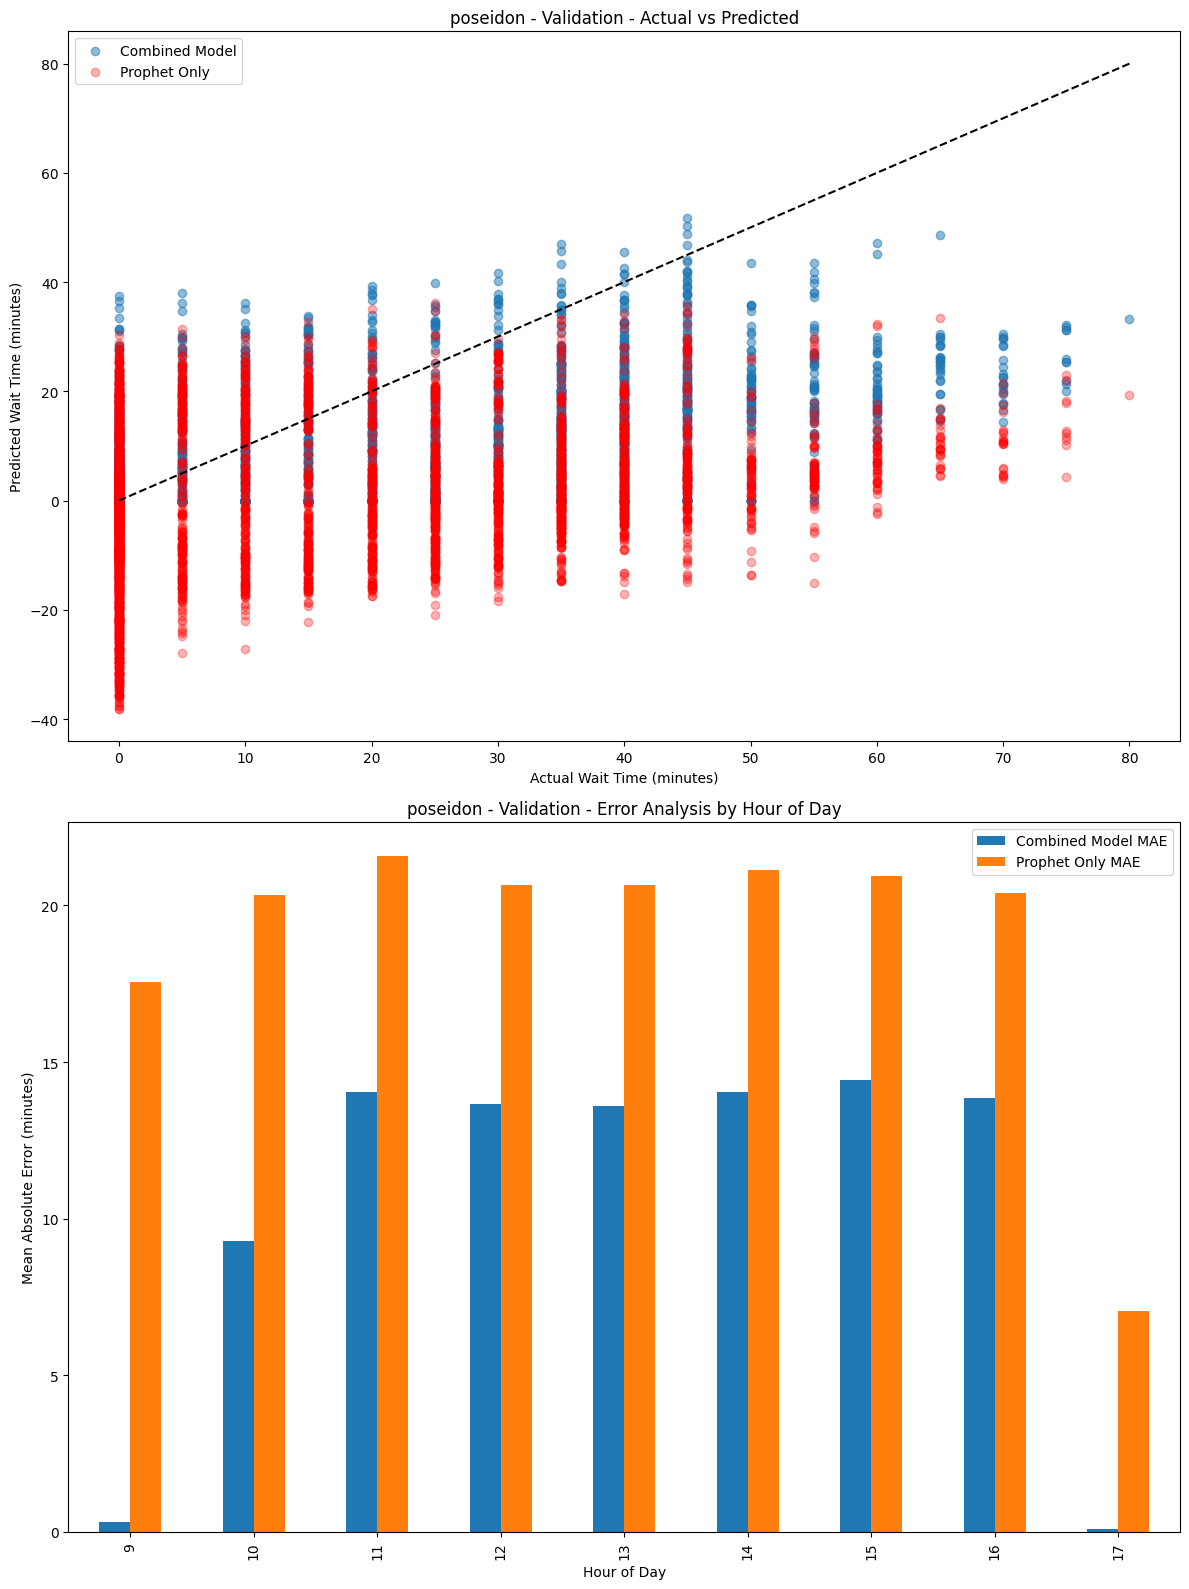

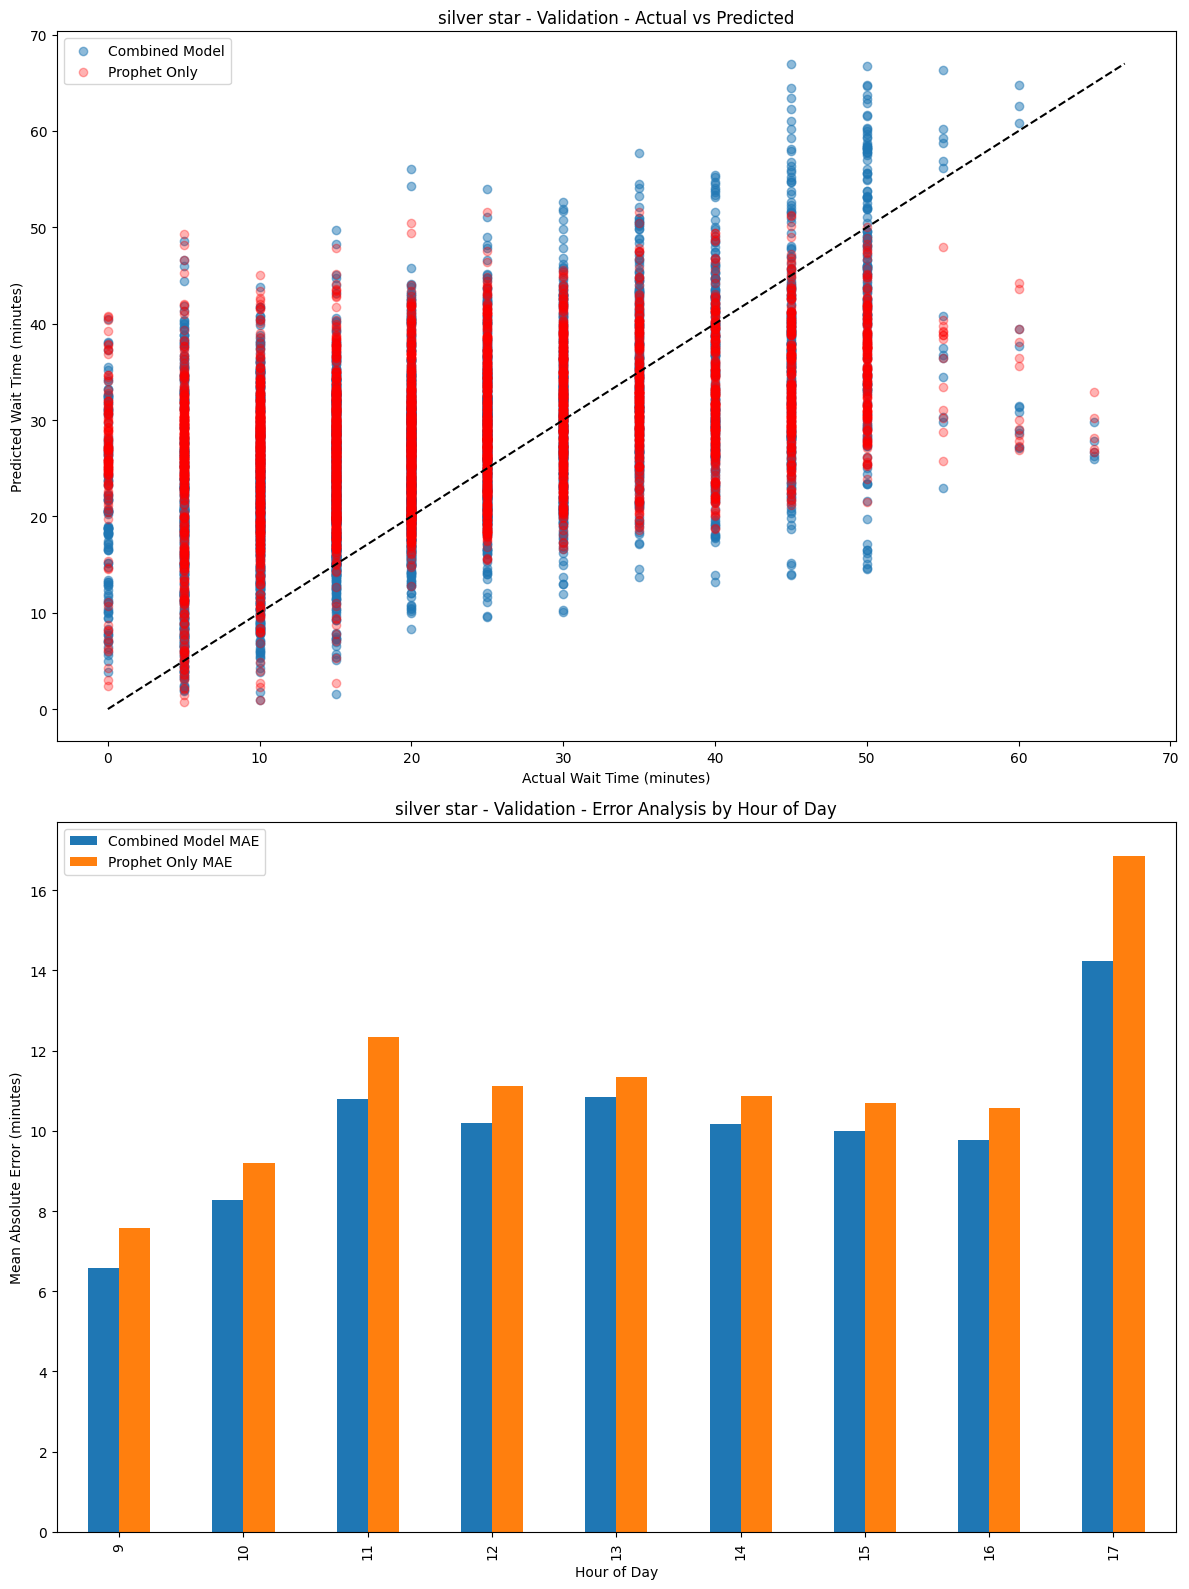

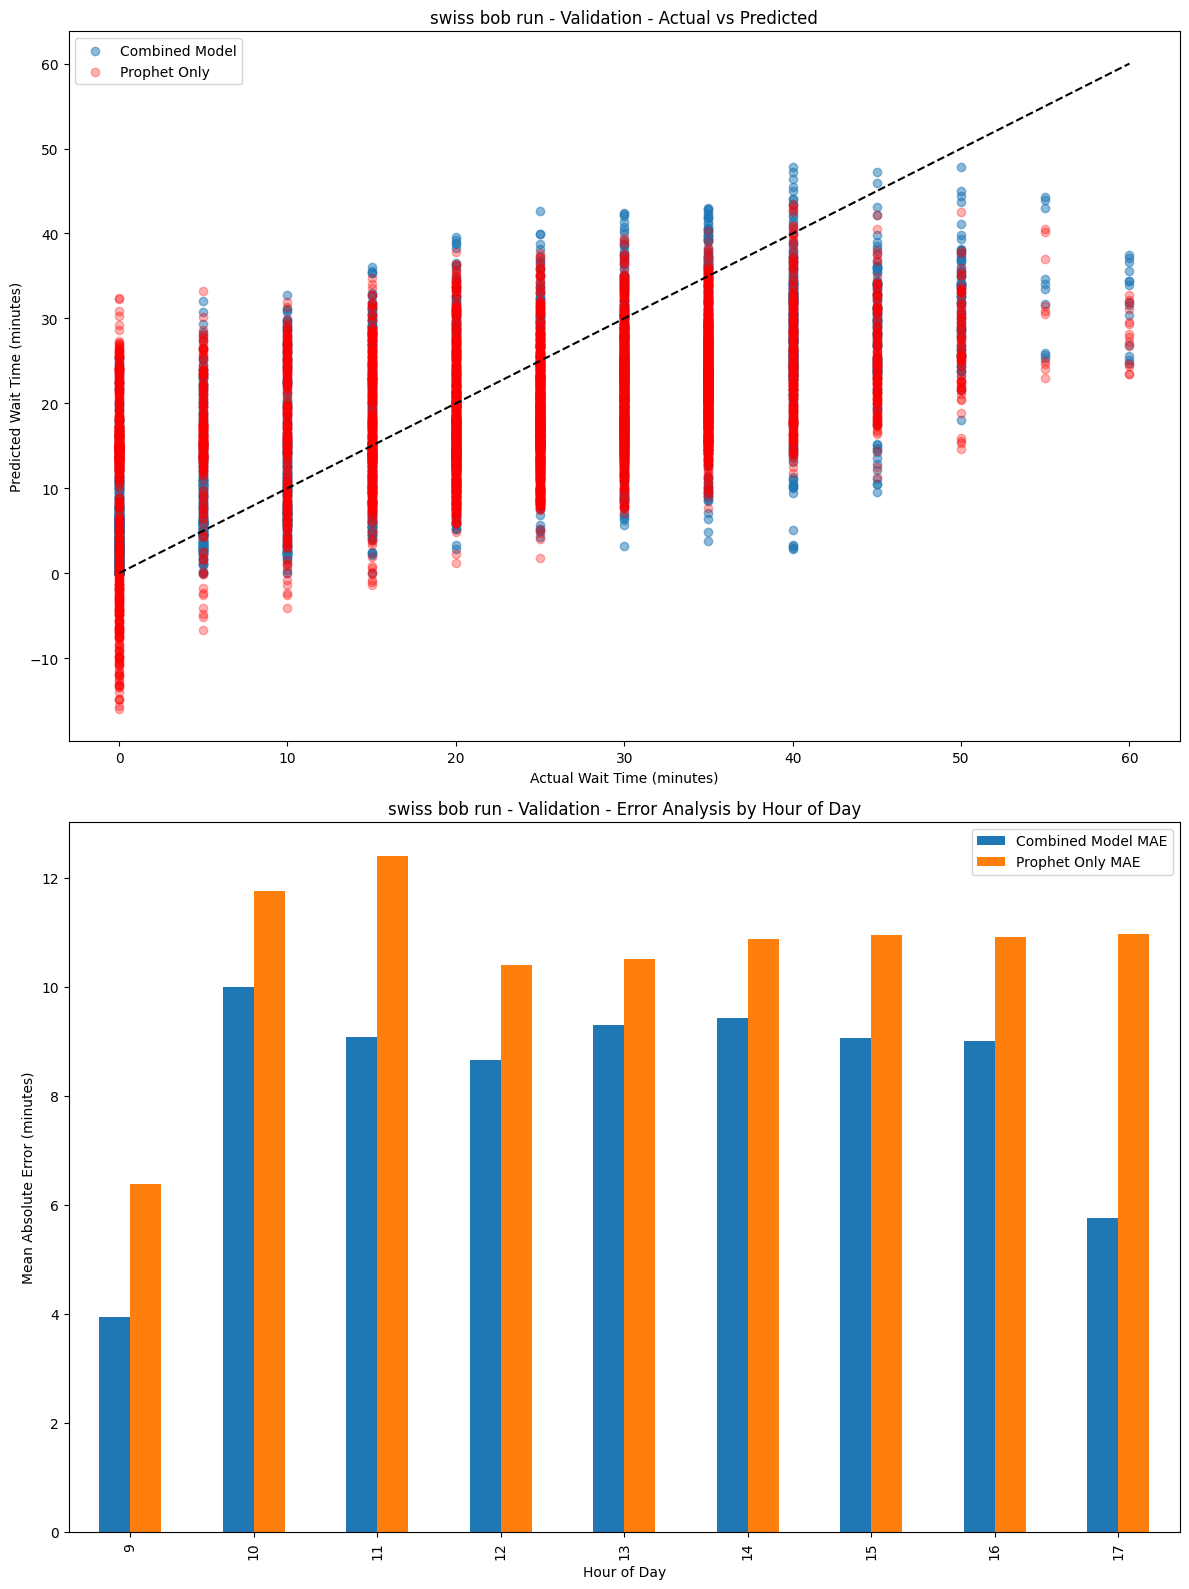

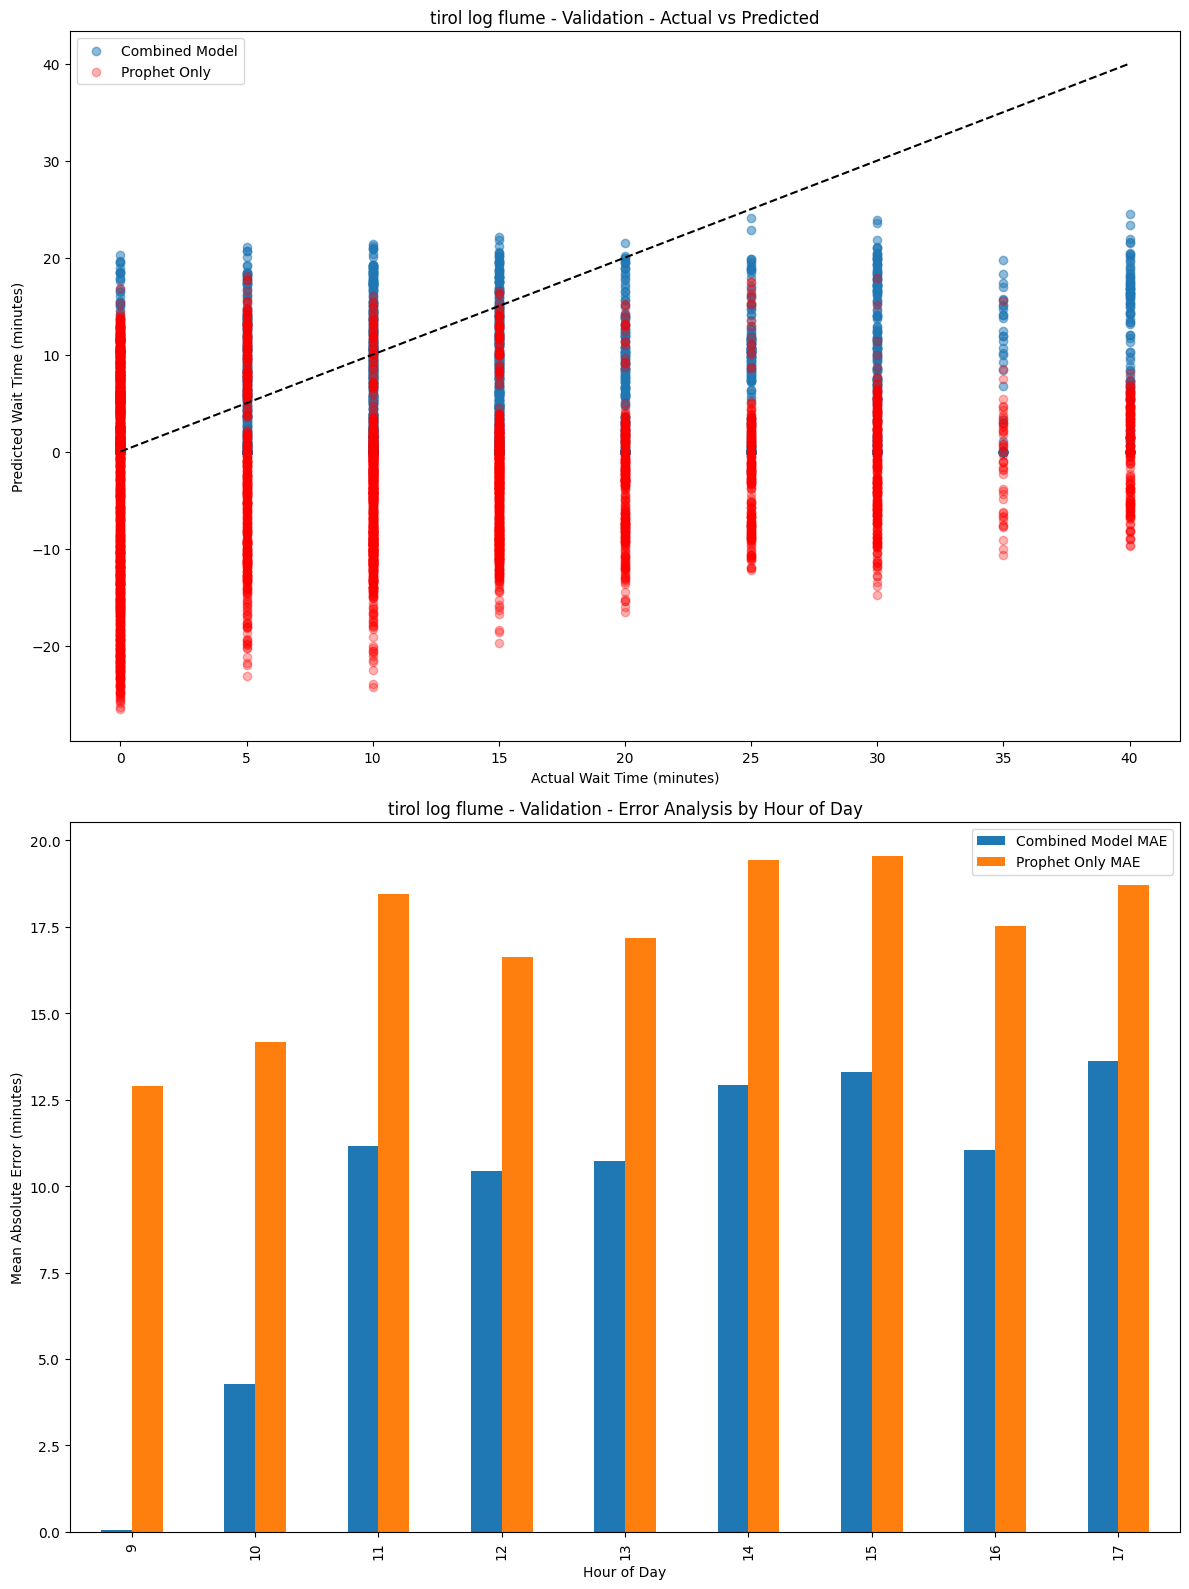

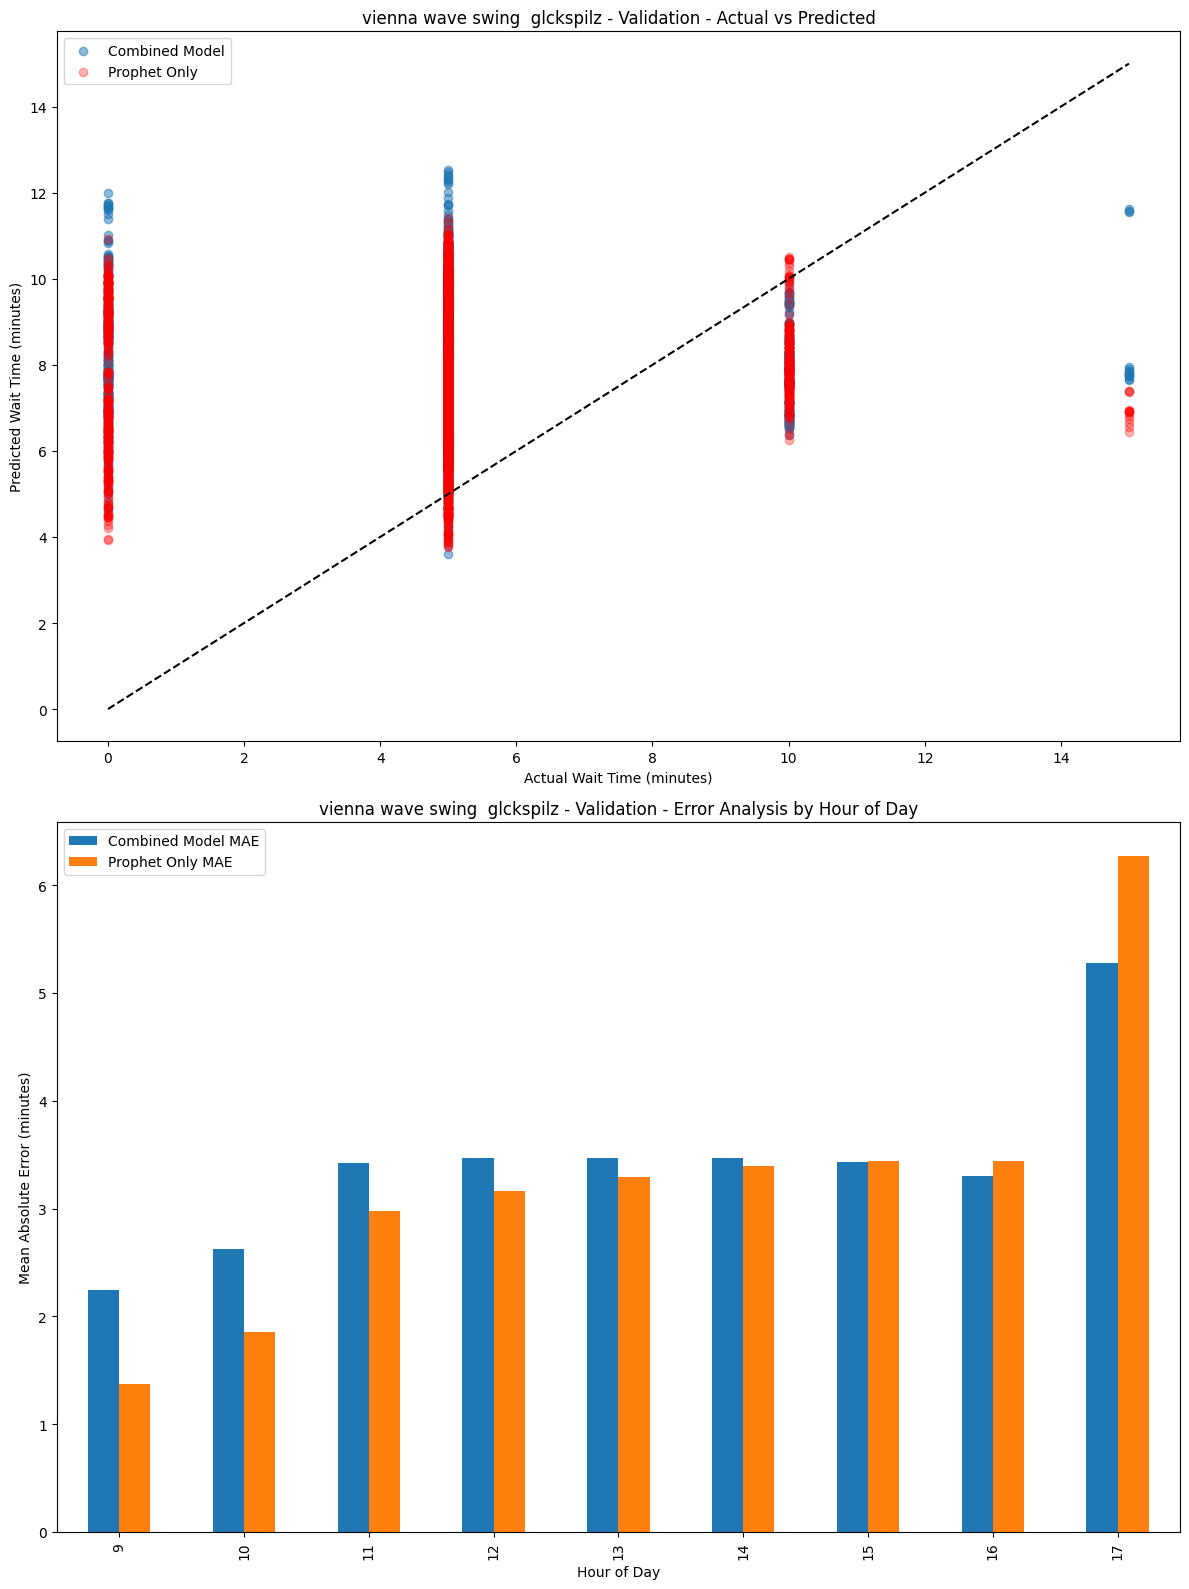

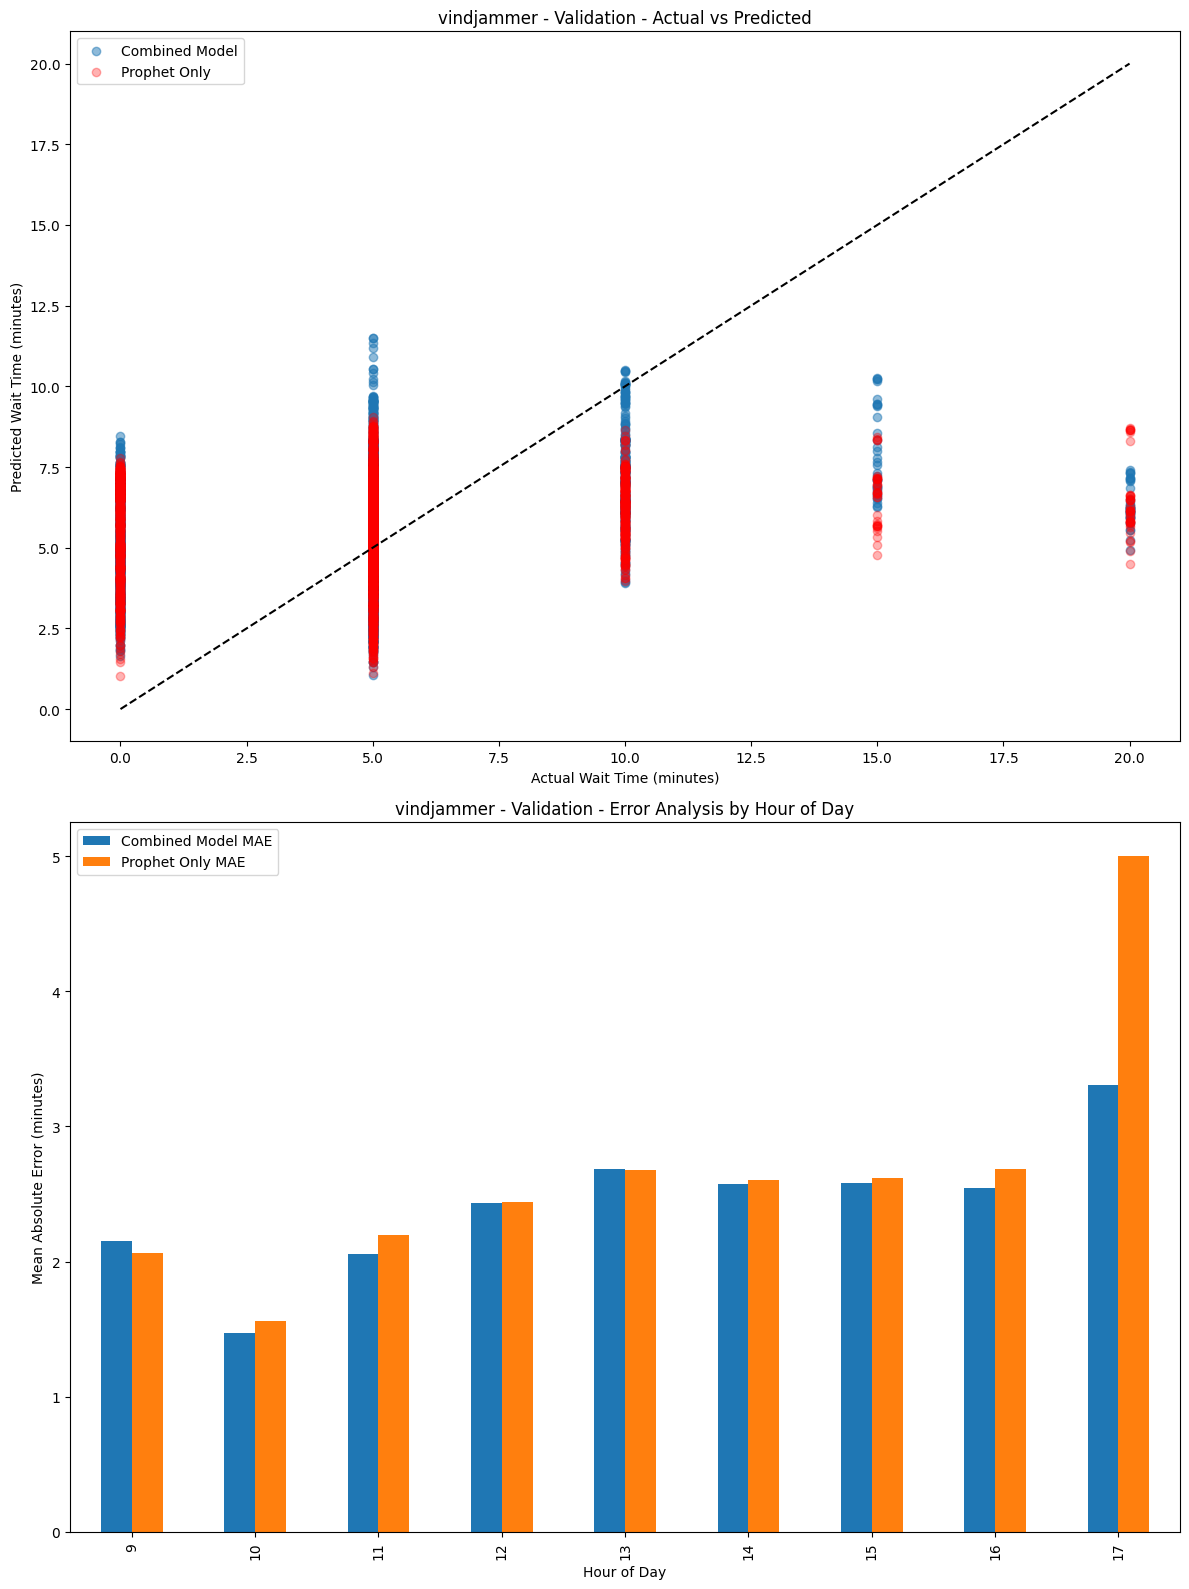

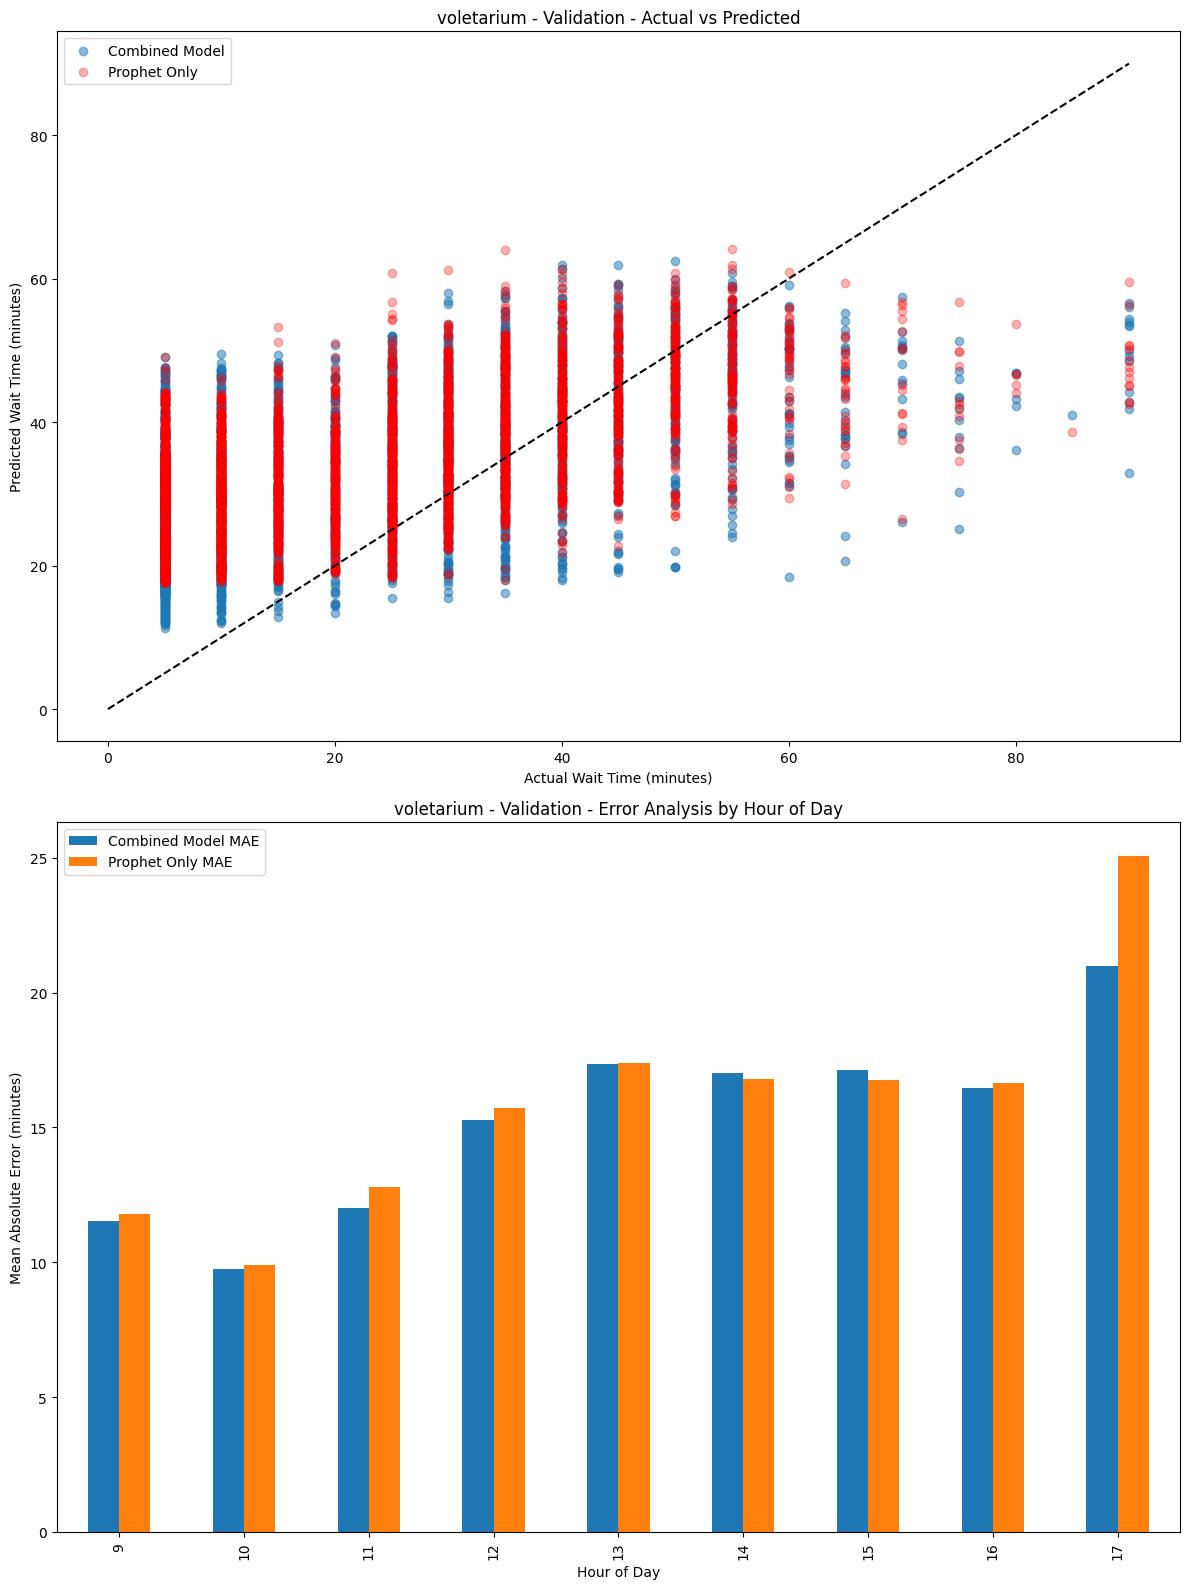

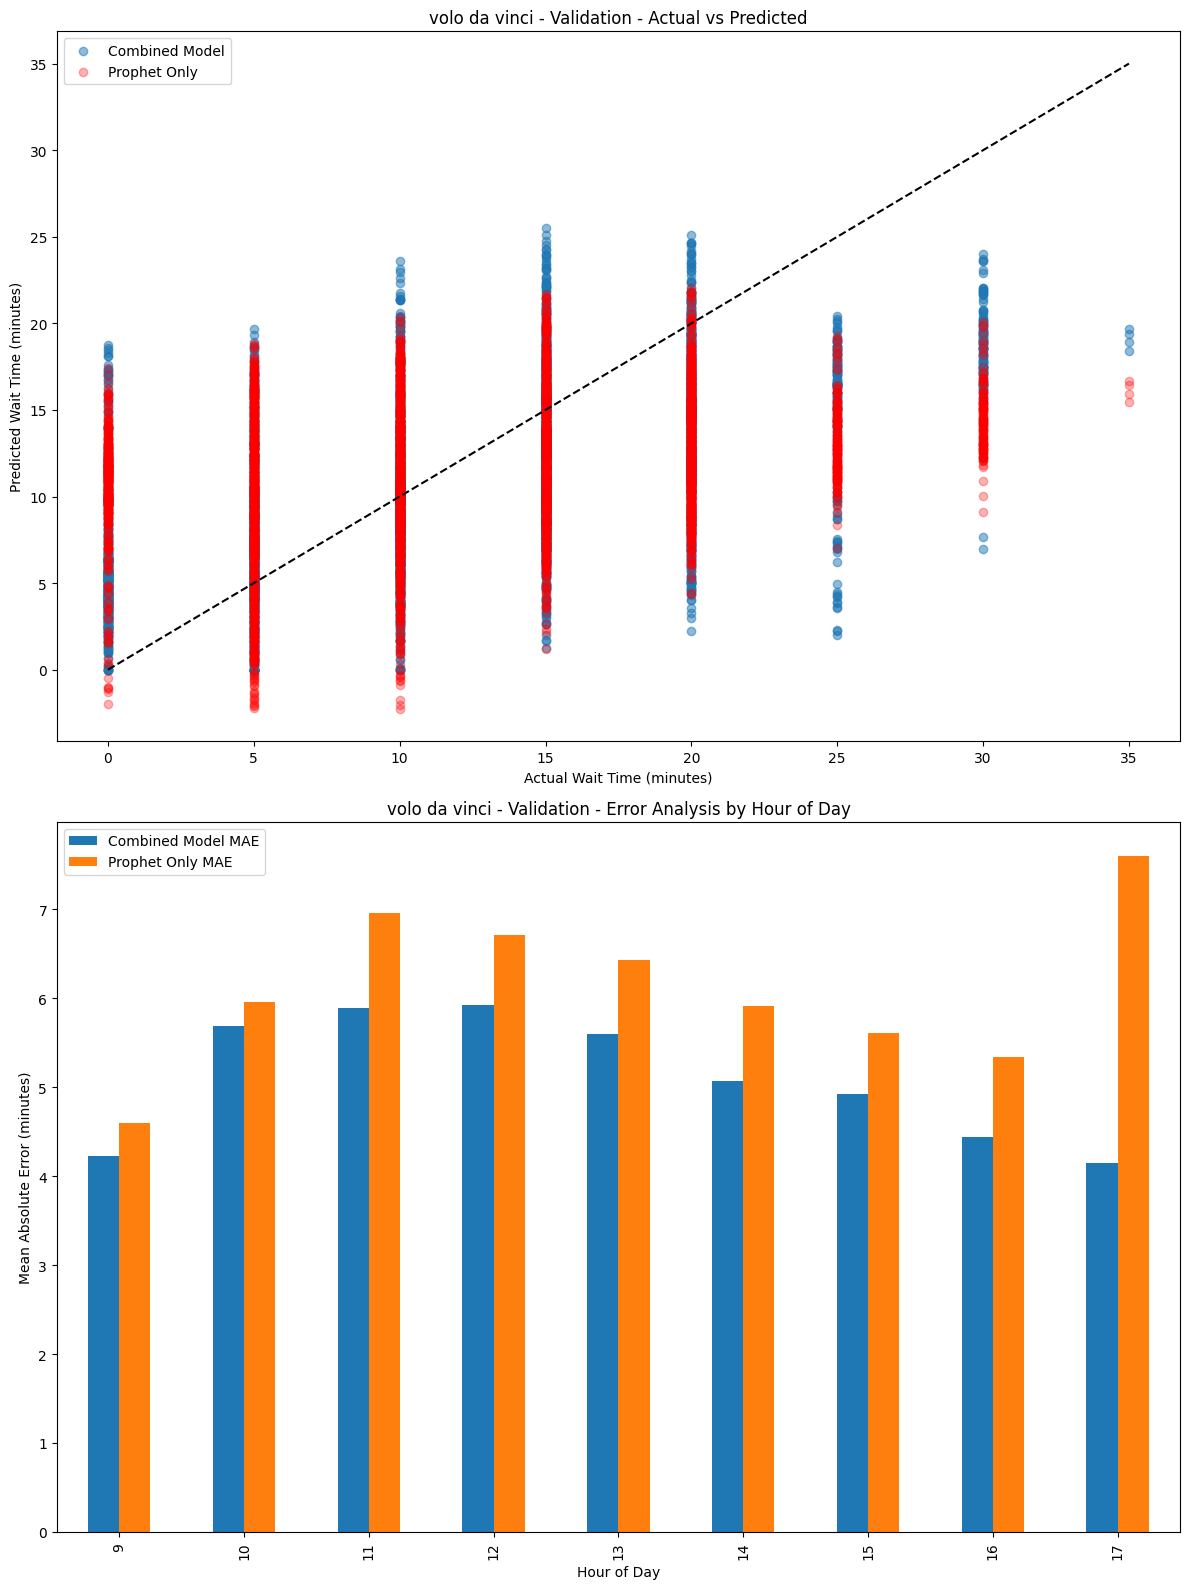

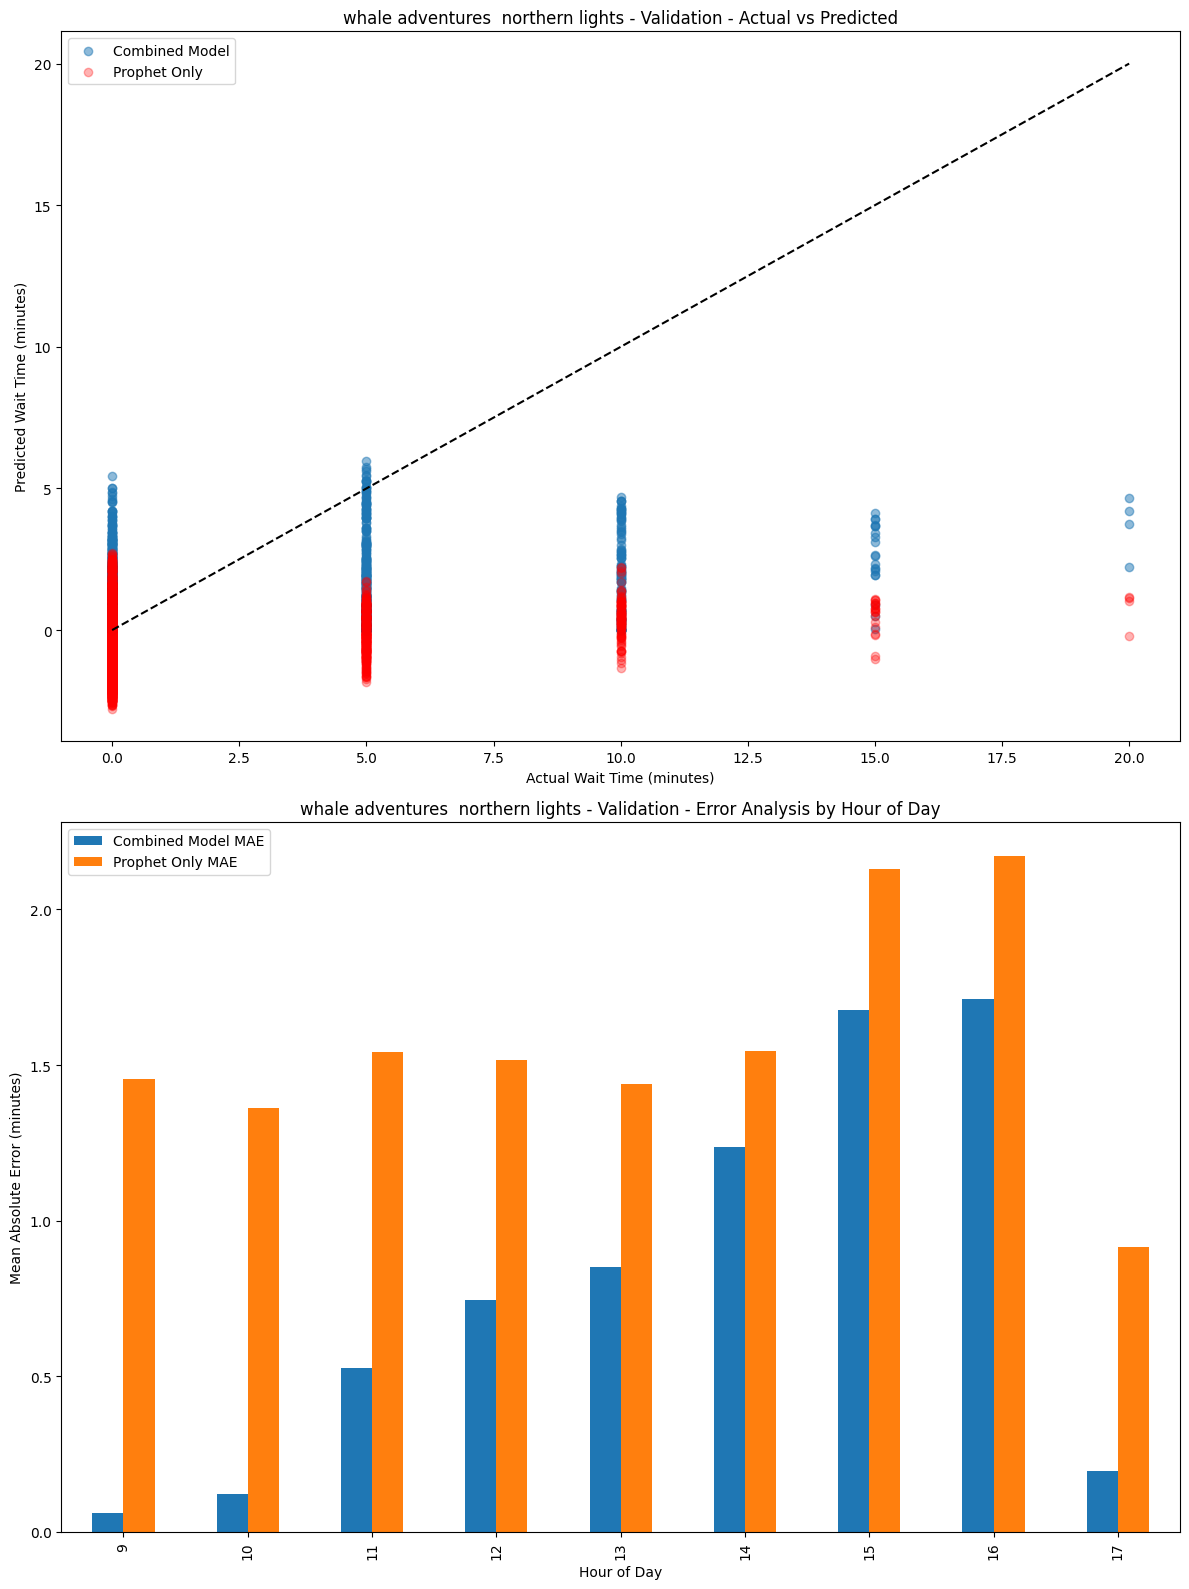

In [18]:
# Get device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set output directory for models and results
output_dir = "../models/prophet_residuals/"

# Process all rides
results = process_all_rides(
    all_rides=all_rides,
    train_data=train_data,
    val_data=val_data,
    output_dir=output_dir,
    device=device,
    resume=True  # Resume from checkpoint if available
)

## Load and Analyze Results

Top 10 rides by validation improvement:


Ride Name  Validation MAE  Validation RMSE  \
0  whale adventures  northern lights        0.891084         2.164317   
1                    tirol log flume        9.648000        13.433895   
2                           poseidon       11.717017        17.397589   
3              atlantica supersplash        7.706699        10.577746   
4   arena of football  be part of it        4.618612         4.959748   
5                    matterhornblitz        6.929798         9.177223   
6              blue fire megacoaster       10.104189        13.324826   
7      madame freudenreich curiosits        0.200617         0.560498   
8                      swiss bob run        8.569222        10.731571   
9                            pegasus        4.928326         7.081348   

   Validation Baseline MAE  Validation Improvement (%)  \
0                 1.639359                   45.644365   
1                17.163625                   43.788100   
2                20.143592                   41.832533   
3                13.138620                   41.343160   
4                 6.863572                   32.708333   
5                 9.345112                   25.845748   
6                12.911912                   21.745220   
7                 0.252821                   20.648794   
8                10.607250                   19.213531   
9                 6.088684                   19.057611   

               Data Counts  
0  Train: 17771, Val: 4229  
1  Train: 17715, Val: 4124  
2  Train: 17666, Val: 4230  
3  Train: 16905, Val: 4232  
4  Train: 16225, Val: 4137  
5  Train: 17731, Val: 4231  
6  Train: 17719, Val: 4234  
7  Train: 16080, Val: 4233  
8  Train: 18488, Val: 4233  
9  Train: 17743, Val: 4234

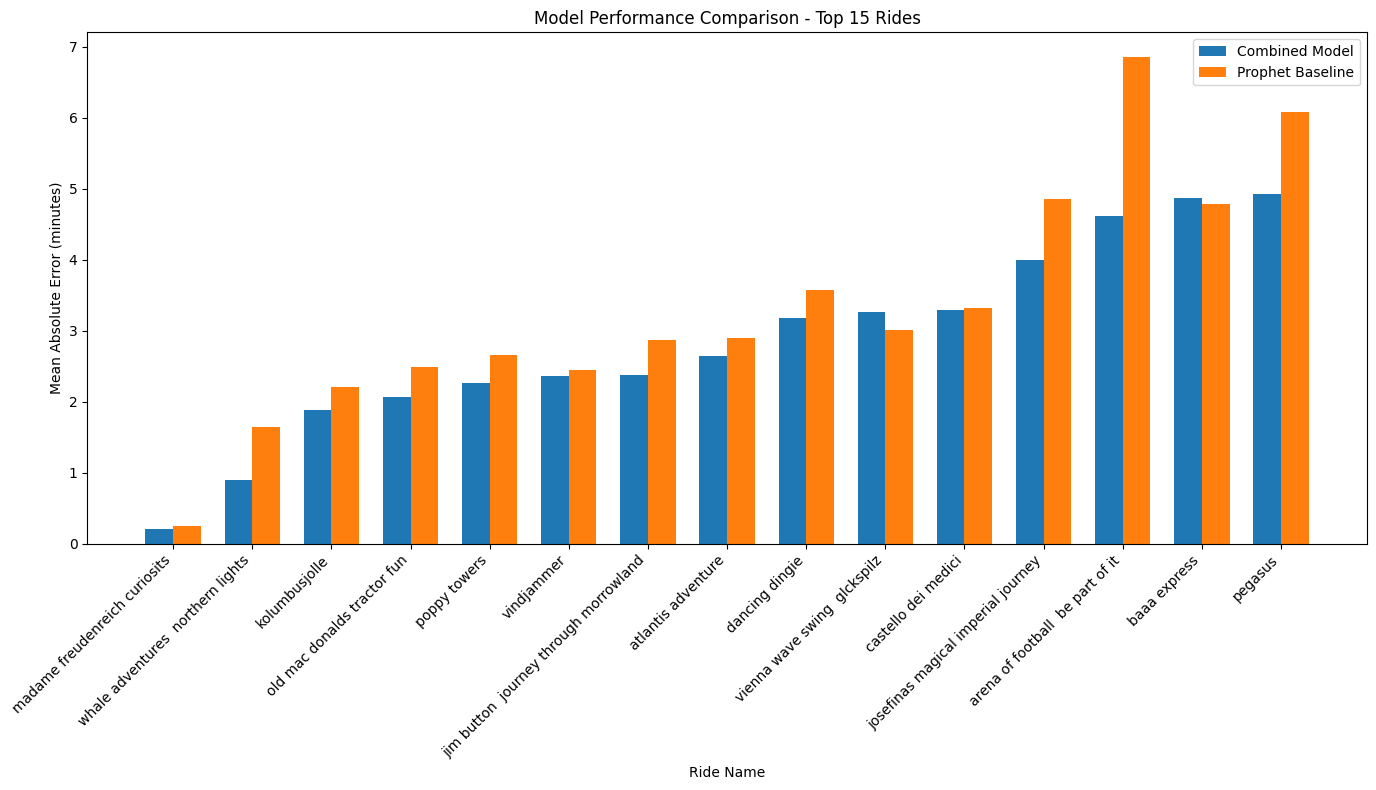

In [19]:
# Load the summary results
summary_path = os.path.join(output_dir, "model_summary.csv")
if os.path.exists(summary_path):
    summary_df = pd.read_csv(summary_path)
    
    # Display the top 10 performing rides
    print("Top 10 rides by validation improvement:")
    display(summary_df.head(10))
    
    # Create a visualization of MAE comparison
    plt.figure(figsize=(14, 8))
    
    # Sort rides by validation MAE for the plot (show top 15)
    top_rides = summary_df.sort_values("Validation MAE").head(15)
    
    # Plot side by side bars for combined model and baseline
    x = np.arange(len(top_rides))
    width = 0.35
    
    plt.bar(x - width/2, top_rides["Validation MAE"], width, label="Combined Model")
    plt.bar(x + width/2, top_rides["Validation Baseline MAE"], width, label="Prophet Baseline")
    
    plt.xlabel("Ride Name")
    plt.ylabel("Mean Absolute Error (minutes)")
    plt.title("Model Performance Comparison - Top 15 Rides")
    plt.xticks(x, top_rides["Ride Name"], rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(os.path.join(output_dir, "top_rides_mae_comparison.png"))
    plt.show()
else:
    print("Summary file not found. Run the processing pipeline first.")

In [25]:
summary_df.describe()

Validation MAE  Validation RMSE  Validation Baseline MAE  \
count       29.000000        29.000000                29.000000   
mean         6.411706         8.243606                 7.394944   
std          4.644409         5.757493                 5.359599   
min          0.200617         0.560498                 0.252821   
25%          2.645612         3.342963                 2.899942   
50%          4.928326         6.497969                 5.788069   
75%          9.648000        12.422066                10.723979   
max         18.435800        22.014772                20.143592   

       Validation Improvement (%)  
count                   29.000000  
mean                    11.476842  
std                     20.470541  
min                    -41.471102  
25%                      0.608438  
50%                     14.543290  
75%                     20.648794  
max                     45.644365